<a href="https://colab.research.google.com/github/nifemi-alonge/evcs_spatial_analysis/blob/main/Alonge_O_Dissertation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of EVCS location inequity and network constraint inequity in London

## Packages

In [ ]:
!pip install geodatasets
!pip install contextily
!pip install mapclassify
!pip install pysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import packages
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_white
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels
import contextily
import mapclassify
import pysal
from pysal.explore import esda
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
import spreg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

## Loading in Data

### NCR

In [ ]:
# downloaded on 8th July 2023 from https://www.gov.uk/guidance/find-and-use-data-on-public-electric-vehicle-chargepoints
ncr_data = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/national-charge-point-registry.csv")
ncr_data.shape

<ipython-input-3-eb4afcf40378>:2: DtypeWarning: Columns (5,10,11,16,17,18,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,79,90,101,112,115,119,122,123,126,130,133,134,137,141,144,148,152,155) have mixed types. Specify dtype option on import or set low_memory=False.
  ncr_data = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/national-charge-point-registry.csv")


(31662, 158)

In [ ]:
# subset columns
ncr_data = ncr_data[['chargeDeviceID', 'reference', 'name','latitude',
                     'longitude','thoroughfare','street','town','county',
                     'postcode','countryCode','deviceOwnerName',
                     'chargeDeviceStatus','onStreetFlag','locationType']]

ncr_data = ncr_data.loc[ncr_data['county'] == 'Greater London']
ncr_data.head()

chargeDeviceID reference                           name  \
1   fa6c94460e902005a0b660266190c8ba  PP-12295     Ancaster Nissan Dealership   
2   eb1848290d5a7de9c9ccabc67fefa211  PP-12290            Beadles Nissan Ltd    
4   65b1e92c585fd4c2159d5f33b5030ff2  PP-12198                    Circus Road   
11  7fa215c9efebb3811a7ef58409907899  PP-12283  Glyn Hopkin Nissan Dealership   
14  c6d6445d97e06d08b60853156601cf58  PP-12432                   HMP Belmarsh   

     latitude  longitude        thoroughfare street             town  \
1   51.411173  -0.055369        Croydon Road    NaN          Anerley   
2   51.451127   0.050619  Eltham High Street    NaN           Eltham   
4   51.533633  -0.172353         Circus Road    NaN  St. John's Wood   
11  51.574484   0.160184         London Road    NaN          Romford   
14  51.496067   0.093083       Belmarsh Road    NaN       Thamesmead   

            county  postcode countryCode deviceOwnerName chargeDeviceStatus  \
1   Greater London  SE20 7TF          gb       POD Point         In service   
2   Greater London   SE9 1DH          gb       POD Point         In service   
4   Greater London   NW8 6PE          gb       POD Point         In service   
11  Greater London   RM7 9NP          gb       POD Point         In service   
14  Greater London  SE28 0EB          gb       POD Point         In service   

    onStreetFlag          locationType  
1            1.0  Dealership forecourt  
2            1.0                 Other  
4            1.0                 Other  
11           1.0  Dealership forecourt  
14           1.0                 Other

### Census Boundaries

In [ ]:
oa_bound = gpd.read_file("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/OA_2011_London_gen_MHW.shp")
oa_bound

OA11CD   LSOA11CD   MSOA11CD  WD11CD_BF    WD11NM_BF    LAD11CD  \
0      E00023264  E01004612  E02000954  E05000626      Tooting  E09000032   
1      E00003359  E01000692  E02000128  E05000111  Chislehurst  E09000006   
2      E00023266  E01004615  E02000956  E05000626      Tooting  E09000032   
3      E00020264  E01004027  E02000809  E05000548    Riverside  E09000028   
4      E00023263  E01004613  E02000955  E05000626      Tooting  E09000032   
...          ...        ...        ...        ...          ...        ...   
25048  E00004047  E01000828  E02000137  E05000126   Shortlands  E09000006   
25049  E00007044  E01001420  E02000296  E05000196  Cockfosters  E09000010   
25050  E00003854  E01000791  E02000155  E05000122    Orpington  E09000006   
25051  E00014344  E01002862  E02000590  E05000390    Hans Town  E09000020   
25052  E00175248  E01004731  E02000979  E05000644   St James's  E09000033   

                      LAD11NM    RGN11CD RGN11NM                     LSOA11NM  \
0                  Wandsworth  E12000007  London              Wandsworth 032C   
1                     Bromley  E12000007  London                 Bromley 002D   
2                  Wandsworth  E12000007  London              Wandsworth 034B   
3                   Southwark  E12000007  London               Southwark 003E   
4                  Wandsworth  E12000007  London              Wandsworth 033D   
...                       ...        ...     ...                          ...   
25048                 Bromley  E12000007  London                 Bromley 011E   
25049                 Enfield  E12000007  London                 Enfield 020B   
25050                 Bromley  E12000007  London                 Bromley 029E   
25051  Kensington and Chelsea  E12000007  London  Kensington and Chelsea 014E   
25052             Westminster  E12000007  London             Westminster 020A   

                         MSOA11NM  USUALRES  HHOLDRES  COMESTRES   POPDEN  \
0                  Wandsworth 032       462       459          3    115.2   
1                     Bromley 002       269       259         10     36.7   
2                  Wandsworth 034       277       277          0    183.4   
3                   Southwark 003       415       415          0     96.1   
4                  Wandsworth 033       304       304          0    165.2   
...                           ...       ...       ...        ...      ...   
25048                 Bromley 011       349       349          0     43.7   
25049                 Enfield 020       288       288          0     30.5   
25050                 Bromley 029       284       284          0     32.1   
25051  Kensington and Chelsea 014       452       452          0  22600.0   
25052             Westminster 020       206       206          0  10300.0   

       HHOLDS  AVHHOLDSZ                                           geometry  
0         143        3.2  POLYGON ((527635.452 171810.058, 527495.957 17...  
1         133        1.9  POLYGON ((543581.516 171132.486, 543704.000 17...  
2         133        2.1  POLYGON ((526613.539 171839.165, 526546.840 17...  
3         191        2.2  POLYGON ((533563.521 179695.146, 533351.118 17...  
4         131        2.3  POLYGON ((527822.000 172020.000, 527979.000 17...  
...       ...        ...                                                ...  
25048     117        3.0  POLYGON ((539163.316 168360.071, 539026.000 16...  
25049     114        2.5  POLYGON ((528811.000 195161.000, 528814.206 19...  
25050     126        2.3  POLYGON ((546965.963 166027.878, 546947.923 16...  
25051     384        1.2  POLYGON ((527325.087 178641.434, 527321.728 17...  
25052     110        1.9  POLYGON ((529580.098 179194.237, 529586.108 17...  

[25053 rows x 18 columns]

In [ ]:
# QA CHECK
oa_bound[oa_bound['OA11CD']=='E00176932']

Empty GeoDataFrame
Columns: [OA11CD, LSOA11CD, MSOA11CD, WD11CD_BF, WD11NM_BF, LAD11CD, LAD11NM, RGN11CD, RGN11NM, LSOA11NM, MSOA11NM, USUALRES, HHOLDRES, COMESTRES, POPDEN, HHOLDS, AVHHOLDSZ, geometry]
Index: []

<Axes: >

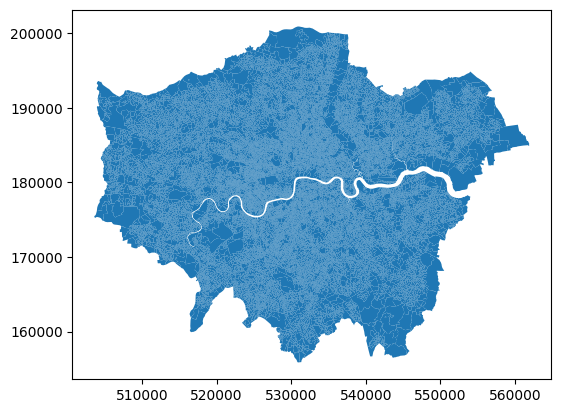

In [ ]:
oa_bound.plot()
# loughton and north west area not in Greater London
# in east Southall etc... not in UKPN area so missing later on

### Ethnicity

In [ ]:
# ethnic
# Load the census data into a pandas DataFrame
ethnic = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS021-2021-3-filtered-2023-07-08T16_16_10Z_ethnic.csv")

# Print the column names to verify correctness
print(ethnic.columns)

# Specify the column names for ethnicity and respondent count
ethnicity_column = 'Ethnic group (20 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
ethnicity_mapping = {
    'Asian, Asian British or Asian Welsh: Bangladeshi': 'Asian',
    'Asian, Asian British or Asian Welsh: Chinese': 'Asian',
    'Asian, Asian British or Asian Welsh: Indian': 'Asian',
    'Asian, Asian British or Asian Welsh: Other Asian': 'Asian',
    'Asian, Asian British or Asian Welsh: Pakistani': 'Asian',
    'Black, Black British, Black Welsh, Caribbean or African: African': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Caribbean': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Other Black': 'Black',
    'Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Asian': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black African': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black Caribbean': 'Mixed',
    'Other ethnic group: Any other ethnic group': 'Other',
    'Other ethnic group: Arab': 'Other',
    'White: English, Welsh, Scottish, Northern Irish or British': 'White',
    'White: Gypsy or Irish Traveller': 'White',
    'White: Irish': 'White',
    'White: Other White': 'White',
    'White: Roma': 'White',
    'Does not apply': 'NA'
    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
ethnic[ethnicity_column] = ethnic[ethnicity_column].map(ethnicity_mapping).fillna(ethnic[ethnicity_column])

# Group the data by output area and calculate the total respondents
grouped_data = ethnic.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
ethnicities_of_interest = ['Black', 'White']  # Add more ethnicities as needed
ethnicity_data = ethnic[ethnic[ethnicity_column].isin(ethnicities_of_interest)]

# Group the filtered data by output area and calculate the counts
ethnicity_counts = ethnicity_data.groupby(['Output Areas', ethnicity_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
ethnicity_pivot = ethnicity_counts.reset_index().pivot(index='Output Areas', columns=ethnicity_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(ethnicity_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for ethnicity in ethnicities_of_interest:
    merged_data[f'percentage_{ethnicity.lower()}'] = (merged_data[ethnicity] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
ethnic = merged_data

ethnic = ethnic.reset_index()

ethnic = ethnic.rename(columns = {'Output Areas': 'OA11CD'})
ethnic

Index(['Output Areas Code', 'Output Areas',
       'Ethnic group (20 categories) Code', 'Ethnic group (20 categories)',
       'Observation'],
      dtype='object')


OA11CD  Observation  Black  White  percentage_black  \
0      E00000001          176      3    155          1.704545   
1      E00000003          255      5    209          1.960784   
2      E00000005          112      0     85          0.000000   
3      E00000007          144      2    106          1.388889   
4      E00000010          175     12    120          6.857143   
...          ...          ...    ...    ...               ...   
26364  E00190465          301     17    109          5.647841   
26365  E00190466          606     55    181          9.075908   
26366  E00190467          407     28    165          6.879607   
26367  E00190468          260     14    153          5.384615   
26368  E00190469          327     52     75         15.902141   

       percentage_white  
0             88.068182  
1             81.960784  
2             75.892857  
3             73.611111  
4             68.571429  
...                 ...  
26364         36.212625  
26365         29.867987  
26366         40.540541  
26367         58.846154  
26368         22.935780  

[26369 rows x 6 columns]

In [ ]:
# QA Code
target_oa = 'E00021482'
target_oa = 'E00190384'
result_df = ethnic[ethnic['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  Black  White  percentage_black  \
26283  E00190384          250     10    132               4.0   

       percentage_white  
26283              52.8

### Population Density

In [ ]:
# pop density
pop_density = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/1903010332763141_pop_density.csv")
pop_density = pop_density.rename(columns = {'region': 'OA11CD','Usual residents per square kilometre' :'pop_density'})
pop_density = pop_density.dropna()
pop_density

OA11CD   mnemonic  pop_density
0      E00000138  E00000138       7395.1
1      E00000156  E00000156        386.4
2      E00000157  E00000157       8934.6
3      E00000158  E00000158       2044.0
4      E00000160  E00000160       4101.1
...          ...        ...          ...
26364  E00023981  E00023981      11968.5
26365  E00175202  E00175202      37948.7
26366  E00175203  E00175203      33170.7
26367  E00175258  E00175258      36744.2
26368  E00190386  E00190386      19881.0

[26369 rows x 3 columns]

In [ ]:
pop_density.sort_values(by = 'pop_density', ascending=False)
# E00014344 is outlier

OA11CD   mnemonic  pop_density
15593  E00014344  E00014344    1980000.0
23480  E00183987  E00183987     492500.0
11795  E00184428  E00184428     446666.7
14524  E00183898  E00183898     260000.0
10233  E00009354  E00009354     249200.0
...          ...        ...          ...
12675  E00011924  E00011924         34.3
12806  E00011695  E00011695         30.5
13604  E00012179  E00012179         30.1
7427   E00007029  E00007029         29.7
12911  E00012155  E00012155         28.6

[26369 rows x 3 columns]

### Household Deprivation

In [ ]:
# household deprivation
# Load the census data into a pandas DataFrame
hh_dep = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS011-2021-4-filtered-2023-07-08T18_12_32Z_hh_dep.csv")

# Print the column names to verify correctness
print(hh_dep.columns)

# Specify the column names for ethnicity and respondent count
h_column = 'Household deprivation (6 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
h_mapping = {
    'Household is not deprived in any dimension': 'Not_deprived',
    'Household is deprived in one dimension': 'Deprived',
    'Household is deprived in two dimensions': 'Deprived',
    'Household is deprived in three dimensions': 'Deprived',
    'Household is deprived in four dimensions': 'Deprived',
    'Does not apply': 'NA'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
hh_dep[h_column] = hh_dep[h_column].map(h_mapping).fillna(hh_dep[h_column])

# Group the data by output area and calculate the total respondents
grouped_data = hh_dep.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
dep_of_interest = ['Deprived', 'Not_deprived']  # Add more ethnicities as needed
h_data = hh_dep[hh_dep[h_column].isin(dep_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', h_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=h_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for h_dep in dep_of_interest:
    merged_data[f'percentage_{h_dep.lower()}'] = (merged_data[h_dep] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
hh_dep = merged_data

hh_dep = hh_dep.reset_index()

hh_dep = hh_dep.rename(columns = {'Output Areas': 'OA11CD'})
hh_dep

Index(['Output Areas Code', 'Output Areas',
       'Household deprivation (6 categories) Code',
       'Household deprivation (6 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  Deprived  Not_deprived  percentage_deprived  \
0      E00000001           91        25            66            27.472527   
1      E00000003          109        35            74            32.110092   
2      E00000005           65        17            48            26.153846   
3      E00000007           86        17            69            19.767442   
4      E00000010          126        86            40            68.253968   
...          ...          ...       ...           ...                  ...   
26364  E00190465          179        44           135            24.581006   
26365  E00190466          242       133           109            54.958678   
26366  E00190467          214        68           146            31.775701   
26367  E00190468          114        41            73            35.964912   
26368  E00190469          103        76            27            73.786408   

       percentage_not_deprived  
0                    72.527473  
1                    67.889908  
2                    73.846154  
3                    80.232558  
4                    31.746032  
...                        ...  
26364                75.418994  
26365                45.041322  
26366                68.224299  
26367                64.035088  
26368                26.213592  

[26369 rows x 6 columns]

In [ ]:
# QA Code
target_oa = 'E00007828'
result_df = hh_dep[hh_dep['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  Deprived  Not_deprived  percentage_deprived  \
7434  E00007828          130        83            47            63.846154   

      percentage_not_deprived  
7434                36.153846

### Household Size

In [ ]:
# household size option 1 keep

# household deprivation
# Load the census data into a pandas DataFrame
hh_size = pd.read_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS017-2021-3-filtered-2023-07-08T18_47_51Z_hh_size.csv')

# Print the column names to verify correctness
print(hh_size.columns)

# Specify the column names for ethnicity and respondent count
h_column = 'Household size (9 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
h_mapping = {
    '0 people in household': 'None_hh',
    '1 person in household': 'Small_hh',
    '2 people in household': 'Small_hh',
    '3 people in household': 'Medium_hh',
    '4 people in household': 'Medium_hh',
    '5 people in household': 'Large_hh',
    '6 people in household': 'Large_hh',
    '7 people in household': 'Large_hh',
    '8 or more people in household': 'Large_hh'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
hh_size[h_column] = hh_size[h_column].map(h_mapping).fillna(hh_size[h_column])

# Group the data by output area and calculate the total respondents
grouped_data = hh_size.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
hhs_of_interest = ['Small_hh', 'Medium_hh', 'Large_hh']  # Add more ethnicities as needed
h_data = hh_size[hh_size[h_column].isin(hhs_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', h_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=h_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for hs in hhs_of_interest:
    merged_data[f'percentage_{hs.lower()}'] = (merged_data[hs] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
hh_size = merged_data

hh_size = hh_size.reset_index()

hh_size = hh_size.rename(columns = {'Output Areas': 'OA11CD'})
hh_size

Index(['Output Areas Code', 'Output Areas',
       'Household size (9 categories) Code', 'Household size (9 categories)',
       'Observation'],
      dtype='object')


OA11CD  Observation  Large_hh  Medium_hh  Small_hh  \
0      E00000001           94         0         16        78   
1      E00000003          109         4         36        69   
2      E00000005           63         0         10        53   
3      E00000007           87         1          4        82   
4      E00000010          125         3          7       115   
...          ...          ...       ...        ...       ...   
26364  E00190465          179         2         22       155   
26365  E00190466          242        20         84       138   
26366  E00190467          212         9         44       159   
26367  E00190468          118         7         34        77   
26368  E00190469          103        29         25        49   

       percentage_small_hh  percentage_medium_hh  percentage_large_hh  
0                82.978723             17.021277             0.000000  
1                63.302752             33.027523             3.669725  
2                84.126984             15.873016             0.000000  
3                94.252874              4.597701             1.149425  
4                92.000000              5.600000             2.400000  
...                    ...                   ...                  ...  
26364            86.592179             12.290503             1.117318  
26365            57.024793             34.710744             8.264463  
26366            75.000000             20.754717             4.245283  
26367            65.254237             28.813559             5.932203  
26368            47.572816             24.271845            28.155340  

[26369 rows x 8 columns]

In [ ]:
# QA Code
target_oa = 'E00021843'
result_df = hh_size[hh_size['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  Large_hh  Medium_hh  Small_hh  \
20452  E00021843          129        20         47        62   

       percentage_small_hh  percentage_medium_hh  percentage_large_hh  
20452            48.062016             36.434109            15.503876

### Education

In [ ]:
# edu
# Load the census data into a pandas DataFrame
edu = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS067-2021-3-filtered-2023-07-08T19_58_31Z_edu.csv")

# Print the column names to verify correctness
print(edu.columns)

# Specify the column names for ethnicity and respondent count
e_column = 'Highest level of qualification (8 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
e_mapping = {
    'Does not apply': 'NA',
    'No qualifications': 'No_edu',
    'Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills': 'School_edu',
    'Level 2 qualifications: 5 or more GCSEs (A* to C or 9 to 4), O levels (passes), CSEs (grade 1), School Certification, 1 A level, 2 to 3 AS levels, VCEs, Intermediate or Higher Diploma, Welsh Baccalaureate Intermediate Diploma, NVQ level 2, Intermediate GNVQ, City and Guilds Craft, BTEC First or General Diploma, RSA Diploma': 'School_edu',
    'Apprenticeship': 'Other_edu',
    'Level 3 qualifications: 2 or more A levels or VCEs, 4 or more AS levels, Higher School Certificate, Progression or Advanced Diploma, Welsh Baccalaureate Advance Diploma, NVQ level 3; Advanced GNVQ, City and Guilds Advanced Craft, ONC, OND, BTEC National, RSA Advanced Diploma': 'School_edu',
    'Level 4 qualifications or above: degree (BA, BSc), higher degree (MA, PhD, PGCE), NVQ level 4 to 5, HNC, HND, RSA Higher Diploma, BTEC Higher level, professional qualifications (for example, teaching, nursing, accountancy)': 'University_edu',
    'Other: vocational or work-related qualifications, other qualifications achieved in England or Wales, qualifications achieved outside England or Wales (equivalent not stated or unknown)': 'Other_edu'



    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
edu[e_column] = edu[e_column].map(e_mapping).fillna(edu[e_column])

# Group the data by output area and calculate the total respondents
grouped_data = edu.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
e_of_interest = ['No_edu', 'Other_edu', 'School_edu', 'University_edu']  # Add more ethnicities as needed
e_data = edu[edu[e_column].isin(e_of_interest)]

# Group the filtered data by output area and calculate the counts
e_counts = e_data.groupby(['Output Areas', e_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
e_pivot = e_counts.reset_index().pivot(index='Output Areas', columns=e_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(e_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for e_dep in e_of_interest:
    merged_data[f'percentage_{e_dep.lower()}'] = (merged_data[e_dep] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
edu = merged_data

edu = edu.reset_index()

edu = edu.rename(columns = {'Output Areas': 'OA11CD'})
edu

Index(['Output Areas Code', 'Output Areas',
       'Highest level of qualification (8 categories) Code',
       'Highest level of qualification (8 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  No_edu  Other_edu  School_edu  University_edu  \
0      E00000001          175       4          6          28             122   
1      E00000003          257       5          1          31             184   
2      E00000005          113       3          3          12              88   
3      E00000007          144       5          3          14             117   
4      E00000010          179      15          8          56              93   
...          ...          ...     ...        ...         ...             ...   
26364  E00190465          298      18         14          46             203   
26365  E00190466          602      55         33         114             271   
26366  E00190467          412      19         18          72             229   
26367  E00190468          263      20          7          45             149   
26368  E00190469          327      59         13         101              85   

       percentage_no_edu  percentage_other_edu  percentage_school_edu  \
0               2.285714              3.428571              16.000000   
1               1.945525              0.389105              12.062257   
2               2.654867              2.654867              10.619469   
3               3.472222              2.083333               9.722222   
4               8.379888              4.469274              31.284916   
...                  ...                   ...                    ...   
26364           6.040268              4.697987              15.436242   
26365           9.136213              5.481728              18.936877   
26366           4.611650              4.368932              17.475728   
26367           7.604563              2.661597              17.110266   
26368          18.042813              3.975535              30.886850   

       percentage_university_edu  
0                      69.714286  
1                      71.595331  
2                      77.876106  
3                      81.250000  
4                      51.955307  
...                          ...  
26364                  68.120805  
26365                  45.016611  
26366                  55.582524  
26367                  56.653992  
26368                  25.993884  

[26369 rows x 10 columns]

In [ ]:
# QA Code
target_oa = 'E00009956'
result_df = edu[edu['OA11CD'] == target_oa]
result_df
# ANSWERS SYSTEMATICALLY LOWER THAN CENSUS WEBSITE HOWEVER, EXTENSIVE CHECK, CENSUS WEBSITE APPEARS INCORRECT

OA11CD  Observation  No_edu  Other_edu  School_edu  University_edu  \
9370  E00009956          305      14         13          40             189   

      percentage_no_edu  percentage_other_edu  percentage_school_edu  \
9370           4.590164              4.262295              13.114754   

      percentage_university_edu  
9370                  61.967213

### Car

In [ ]:
# CHANGE TO CAR
# number of cars
# Load the census data into a pandas DataFrame
car = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS045-2021-4-filtered-2023-07-08T20_45_48Z_car.csv")

# Print the column names to verify correctness
print(car.columns)

# Specify the column names for ethnicity and respondent count
c_column = 'Car or van availability (5 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
c_mapping = {
    'Does not apply': 'NA',
    'No cars or vans in household': 'No_cars',
    '1 car or van in household': 'One_car',
    '2 cars or vans in household': '2+_cars',
    '3 or more cars or vans in household': '2+_cars'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
car[c_column] = car[c_column].map(c_mapping).fillna(car[c_column])

# Group the data by output area and calculate the total respondents
grouped_data = car.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
c_of_interest = ['No_cars', 'One_car', '2+_cars']  # Add more ethnicities as needed
c_data = car[car[c_column].isin(c_of_interest)]

# Group the filtered data by output area and calculate the counts
c_counts = c_data.groupby(['Output Areas', c_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
c_pivot = c_counts.reset_index().pivot(index='Output Areas', columns=c_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(c_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for car_no in c_of_interest:
    merged_data[f'percentage_{car_no.lower()}'] = (merged_data[car_no] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
car = merged_data

car = car.reset_index()

car = car.rename(columns = {'Output Areas': 'OA11CD'})
car

Index(['Output Areas Code', 'Output Areas',
       'Car or van availability (5 categories) Code',
       'Car or van availability (5 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  2+_cars  No_cars  One_car  percentage_no_cars  \
0      E00000001           95        8       46       41           48.421053   
1      E00000003          109       11       51       47           46.788991   
2      E00000005           61        6       37       18           60.655738   
3      E00000007           86        4       66       16           76.744186   
4      E00000010          126        0      109       17           86.507937   
...          ...          ...      ...      ...      ...                 ...   
26364  E00190465          179        4      140       35           78.212291   
26365  E00190466          242       19      113      110           46.694215   
26366  E00190467          212       11      137       64           64.622642   
26367  E00190468          113       21       48       44           42.477876   
26368  E00190469          103        4       60       39           58.252427   

       percentage_one_car  percentage_2+_cars  
0               43.157895            8.421053  
1               43.119266           10.091743  
2               29.508197            9.836066  
3               18.604651            4.651163  
4               13.492063            0.000000  
...                   ...                 ...  
26364           19.553073            2.234637  
26365           45.454545            7.851240  
26366           30.188679            5.188679  
26367           38.938053           18.584071  
26368           37.864078            3.883495  

[26369 rows x 8 columns]

In [ ]:
# QA Code
target_oa = 'E00012887'
result_df = car[car['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  2+_cars  No_cars  One_car  percentage_no_cars  \
12166  E00012887          142       47       39       56           27.464789   

       percentage_one_car  percentage_2+_cars  
12166            39.43662           33.098592

### Drive to work

In [ ]:
# method of travel to work - drive car
# Load the census data into a pandas DataFrame
drive = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS061-2021-4-filtered-2023-07-10T15_23_25Z_drive.csv")

# Print the column names to verify correctness
print(drive.columns)

# Specify the column names for ethnicity and respondent count
d_column = 'Method used to travel to workplace (12 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
d_mapping = {
    'Work mainly at or from home': 'NA',
    'Underground, metro, light rail, tram': 'public_transport',
    'Train': 'public_transport',
    'Bus, minibus or coach': 'public_transport',
    'Taxi': 'paid',
    'Motorcycle, scooter or moped': 'moto',
    'Driving a car or van': 'drive_car',
    'Passenger in a car or van': 'passenger_car',
    'Bicycle': 'cycle',
    'On foot': 'foot',
    'Other method of travel to work': 'other',
    'Not in employment or aged 15 years and under': 'NA'


    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
drive[d_column] = drive[d_column].map(d_mapping).fillna(drive[d_column])

# Group the data by output area and calculate the total respondents
grouped_data = drive.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
d_of_interest = ['public_transport', 'drive_car', 'passenger_car']  # Add more ethnicities as needed
c_data = drive[drive[d_column].isin(d_of_interest)]

# Group the filtered data by output area and calculate the counts
c_counts = c_data.groupby(['Output Areas', d_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
c_pivot = c_counts.reset_index().pivot(index='Output Areas', columns=d_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(c_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for drive_no in d_of_interest:
    merged_data[f'percentage_{drive_no.lower()}'] = (merged_data[drive_no] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
drive = merged_data

drive = drive.reset_index()

drive = drive.rename(columns = {'Output Areas': 'OA11CD'})
drive

Index(['Output Areas Code', 'Output Areas',
       'Method used to travel to workplace (12 categories) Code',
       'Method used to travel to workplace (12 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  drive_car  passenger_car  public_transport  \
0      E00000001          176          1              0                 8   
1      E00000003          255          7              0                11   
2      E00000005          112          3              0                 9   
3      E00000007          145          5              0                 6   
4      E00000010          180          4              0                23   
...          ...          ...        ...            ...               ...   
26364  E00190465          299         10              0                16   
26365  E00190466          605         31              2                49   
26366  E00190467          409         12              3                25   
26367  E00190468          263         11              0                16   
26368  E00190469          327         10              1                38   

       percentage_public_transport  percentage_drive_car  \
0                         4.545455              0.568182   
1                         4.313725              2.745098   
2                         8.035714              2.678571   
3                         4.137931              3.448276   
4                        12.777778              2.222222   
...                            ...                   ...   
26364                     5.351171              3.344482   
26365                     8.099174              5.123967   
26366                     6.112469              2.933985   
26367                     6.083650              4.182510   
26368                    11.620795              3.058104   

       percentage_passenger_car  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.000000  
4                      0.000000  
...                         ...  
26364                  0.000000  
26365                  0.330579  
26366                  0.733496  
26367                  0.000000  
26368                  0.305810  

[26369 rows x 8 columns]

In [ ]:
# QA Code
#print (drive['Method used to travel to workplace (12 categories)'].str.split(';\s*', expand=True).stack().unique())

#target_oa = ['E00021761','E00021754','E00021753','E00021756','E00021755','E00021757','E00021736','E00021760','E00021759',
             #'E00021737','E00021764','E00021763','E00021758','E00021762','E00183855','E00183810','E00021767','E00021740','E00021745']
#subset_df = drive[drive['OA11CD'].isin(target_oa)]

#subset_df.describe()
# UNABLE TO TEST AS CENSUS LISTS MSOA BUT DOWNLOADED AS OA, CODE CHECKS COMPLETE

### Median Age

In [ ]:
#edits here
# changed age, 0 = aged under 1, 100 includes 100 and over
# msoa
# Load the CSV data into a pandas DataFrame
age_data = pd.read_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/1253589504620498_age.csv')
age_data = age_data.dropna()

# Specify the columns for MSOA, total, and age data
msoa_column = 'mnemonic'
total_column = 'Total: All usual residents'
age_columns = age_data.columns[3:]  # Exclude non-age columns

# Calculate the median age for each MSOA
median_age_data = pd.DataFrame()
ageey = pd.DataFrame()

for index, row in age_data.iterrows():
    msoa = row[msoa_column]
    total = row[total_column]
    age_values = [int(age_column) for age_column in age_columns]
    age_counts = [int(row[age_column]) for age_column in age_columns]
    ageey['age'] = pd.DataFrame(age_values)
    median_age = ageey['age'].repeat(age_counts).median()
    #median_age = np.average(age_values, weights=age_counts, axis=0)
    msoa_median_age = pd.DataFrame({'MSOA': [msoa], 'Median Age': [median_age]})
    median_age_data = pd.concat([median_age_data, msoa_median_age], ignore_index=True)

# Print the median age for each MSOA
median_age_data = median_age_data.rename(columns = {'Median Age': 'median_age'})
median_age_data

MSOA  median_age
0     E02000002        33.0
1     E02000003        34.0
2     E02000004        37.0
3     E02000005        33.0
4     E02000007        33.0
...         ...         ...
997   E02000979        35.0
998   E02000980        36.0
999   E02000981        36.0
1000  E02000982        38.0
1001  E02000983        36.0

[1002 rows x 2 columns]

### Average Income

In [ ]:
income = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/totalannualincome2018.csv", encoding='latin-1')
income = income.rename(columns = {'Total annual income (£)': 'average_income'})
income
# No QA necessary

MSOA code          MSOA name Local authority code Local authority name  \
0     E02004297  County Durham 001            E06000047        County Durham   
1     E02004290  County Durham 002            E06000047        County Durham   
2     E02004298  County Durham 003            E06000047        County Durham   
3     E02004299  County Durham 004            E06000047        County Durham   
4     E02004291  County Durham 005            E06000047        County Durham   
...         ...                ...                  ...                  ...   
7196  W02000362        Newport 016            W06000022              Newport   
7197  W02000363        Newport 017            W06000022              Newport   
7198  W02000364        Newport 018            W06000022              Newport   
7199  W02000365        Newport 019            W06000022              Newport   
7200  W02000366        Newport 020            W06000022              Newport   

     Region code Region name  average_income  Upper confidence limit (£)  \
0      E12000001  North East           39800                       47800   
1      E12000001  North East           42200                       50700   
2      E12000001  North East           40100                       48000   
3      E12000001  North East           33800                       40500   
4      E12000001  North East           33400                       40000   
...          ...         ...             ...                         ...   
7196   W92000004       Wales           47300                       57700   
7197   W92000004       Wales           35800                       43600   
7198   W92000004       Wales           28200                       35100   
7199   W92000004       Wales           35500                       43200   
7200   W92000004       Wales           52600                       63900   

      Lower confidence limit (£)  Confidence interval (£)  
0                          33100                    14700  
1                          35200                    15500  
2                          33400                    14600  
3                          28200                    12300  
4                          27800                    12200  
...                          ...                      ...  
7196                       38800                    18900  
7197                       29500                    14100  
7198                       22600                    12500  
7199                       29200                    14000  
7200                       43300                    20600  

[7201 rows x 10 columns]

### Accommodation Type

In [ ]:
# accommodation type

# Load the census data into a pandas DataFrame
acc_type = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS044-2021-4-filtered-2023-07-09T14_53_14Z_house.csv")

# Print the column names to verify correctness
print(acc_type.columns)

# Specify the column names for ethnicity and respondent count
a_column = 'Accommodation type (8 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
a_mapping = {
    'A caravan or other mobile or temporary structure': 'NA',
    'In a commercial building, for example, in an office building, hotel or over a shop': 'NA',
    'Part of another converted building, for example, former school, church or warehouse': 'Shared_flat',
    'Part of a converted or shared house, including bedsits': 'Shared_flat',
    'In a purpose-built block of flats or tenement': 'Shared_flat',
    'Terraced': 'House',
    'Semi-detached': 'House',
    'Detached': 'House'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
acc_type[a_column] = acc_type[a_column].map(a_mapping).fillna(acc_type[a_column])

# Group the data by output area and calculate the total respondents
grouped_data = acc_type.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
a_of_interest = ['Shared_flat', 'House']  # Add more ethnicities as needed
h_data = acc_type[acc_type[a_column].isin(a_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', a_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=a_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for acc in a_of_interest:
    merged_data[f'percentage_{acc.lower()}'] = (merged_data[acc] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
acc_type = merged_data

acc_type = acc_type.reset_index()

acc_type = acc_type.rename(columns = {'Output Areas': 'OA11CD'})
acc_type

Index(['Output Areas Code', 'Output Areas',
       'Accommodation type (8 categories) Code',
       'Accommodation type (8 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  House  Shared_flat  percentage_shared_flat  \
0      E00000001           94      1           93               98.936170   
1      E00000003          109     12           97               88.990826   
2      E00000005           63      1           62               98.412698   
3      E00000007           86      2           81               94.186047   
4      E00000010          125      0          121               96.800000   
...          ...          ...    ...          ...                     ...   
26364  E00190465          179      0          178               99.441341   
26365  E00190466          243      0          241               99.176955   
26366  E00190467          210      1          209               99.523810   
26367  E00190468          117     32           83               70.940171   
26368  E00190469          103      2          101               98.058252   

       percentage_house  
0              1.063830  
1             11.009174  
2              1.587302  
3              2.325581  
4              0.000000  
...                 ...  
26364          0.000000  
26365          0.000000  
26366          0.476190  
26367         27.350427  
26368          1.941748  

[26369 rows x 6 columns]

In [ ]:
# QA Code
target_oa = 'E00019984'
result_df = acc_type[acc_type['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  House  Shared_flat  percentage_shared_flat  \
18791  E00019984          109      3          106               97.247706   

       percentage_house  
18791          2.752294

### Tenure

In [ ]:
# tenure
# Load the census data into a pandas DataFrame
tenure = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS054-2021-4-filtered-2023-07-10T15_41_28Z_tenure.csv")

# Print the column names to verify correctness
print(tenure.columns)

# Specify the column names for ethnicity and respondent count
t_column = 'Tenure of household (9 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
t_mapping = {
    'Does not apply': 'NA',
    'Lives rent free': 'NA',
    'Owned: Owns outright': 'owner',
    'Owned: Owns with a mortgage or loan': 'owner',
    'Shared ownership: Shared ownership': 'shared_owner',
    'Social rented: Rents from council or Local Authority': 'renter',
    'Social rented: Other social rented': 'renter',
    'Private rented: Private landlord or letting agency': 'renter',
    'Private rented: Other private rented': 'renter'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
tenure[t_column] = tenure[t_column].map(t_mapping).fillna(tenure[t_column])

# Group the data by output area and calculate the total respondents
grouped_data = tenure.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
t_of_interest = ['owner', 'shared_owner', 'renter']  # Add more ethnicities as needed
h_data = tenure[tenure[t_column].isin(t_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', t_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=t_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for ten in t_of_interest:
    merged_data[f'percentage_{ten.lower()}'] = (merged_data[ten] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
tenure = merged_data

tenure = tenure.reset_index()

tenure = tenure.rename(columns = {'Output Areas': 'OA11CD'})
tenure

Index(['Output Areas Code', 'Output Areas',
       'Tenure of household (9 categories) Code',
       'Tenure of household (9 categories)', 'Observation'],
      dtype='object')


OA11CD  Observation  owner  renter  shared_owner  percentage_owner  \
0      E00000001           94     72      22             0         76.595745   
1      E00000003          111     91      19             0         81.981982   
2      E00000005           63     40      23             0         63.492063   
3      E00000007           87     28      58             1         32.183908   
4      E00000010          126     25     101             0         19.841270   
...          ...          ...    ...     ...           ...               ...   
26364  E00190465          179     37     141             1         20.670391   
26365  E00190466          242     53     175            13         21.900826   
26366  E00190467          213     61     152             0         28.638498   
26367  E00190468          114     70      44             0         61.403509   
26368  E00190469          102     17      84             0         16.666667   

       percentage_shared_owner  percentage_renter  
0                     0.000000          23.404255  
1                     0.000000          17.117117  
2                     0.000000          36.507937  
3                     1.149425          66.666667  
4                     0.000000          80.158730  
...                        ...                ...  
26364                 0.558659          78.770950  
26365                 5.371901          72.314050  
26366                 0.000000          71.361502  
26367                 0.000000          38.596491  
26368                 0.000000          82.352941  

[26369 rows x 8 columns]

In [ ]:
# QA Code
target_oa = 'E00016409'
result_df = tenure[tenure['OA11CD'] == target_oa]
result_df
# PASSED TESTS

OA11CD  Observation  owner  renter  shared_owner  percentage_owner  \
15469  E00016409          136     17     109            10              12.5   

       percentage_shared_owner  percentage_renter  
15469                 7.352941          80.147059

### Commercial Activity and Roads

In [ ]:
# roads and commercial
comm_roads = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA_comm_roads.csv")
comm_roads = comm_roads[comm_roads['MSOA code'].notna()]
comm_roads = comm_roads.rename(columns = {'Industry and Commerce Total': 'percentage_commercial_land', 'Highways and road transport':'percentage_roads'})

comm_roads
# NO QA NECESSARY

LSOA code  LSOA name  MSOA code MSOA name                   MSOA Names  \
0      E01031349  Adur 001A  E02006534  Adur 001                     Hillside   
1      E01031350  Adur 001B  E02006534  Adur 001                     Hillside   
2      E01031351  Adur 001C  E02006534  Adur 001                     Hillside   
3      E01031352  Adur 001D  E02006534  Adur 001                     Hillside   
4      E01031370  Adur 001E  E02006534  Adur 001                     Hillside   
...          ...        ...        ...       ...                          ...   
33750  E01013341  York 024B  E02002795  York 024  Bishopthorpe & Copmanthorpe   
33751  E01013342  York 024C  E02002795  York 024  Bishopthorpe & Copmanthorpe   
33752  E01013423  York 024D  E02002795  York 024  Bishopthorpe & Copmanthorpe   
33753  E01013424  York 024E  E02002795  York 024  Bishopthorpe & Copmanthorpe   
33754  E01013425  York 024F  E02002795  York 024  Bishopthorpe & Copmanthorpe   

       Industry  Offices  Retail  Storage and warehousing  \
0           NaN      NaN     0.1                      NaN   
1           NaN      NaN     NaN                      0.0   
2           0.0      NaN     0.5                      0.0   
3           0.0      NaN     0.7                      NaN   
4           0.0      NaN     0.5                      NaN   
...         ...      ...     ...                      ...   
33750       NaN      NaN     0.0                      NaN   
33751       0.0      0.0     0.0                      0.0   
33752       0.0      NaN     NaN                      NaN   
33753       NaN      NaN     0.0                      NaN   
33754       NaN      0.0     0.0                      0.0   

       percentage_commercial_land  percentage_roads  Transport (other)  \
0                             0.1              11.8                0.3   
1                             0.0              14.6                0.0   
2                             0.5               4.0                0.0   
3                             0.7              19.9                0.0   
4                             0.8              21.7                0.0   
...                           ...               ...                ...   
33750                         0.0               9.6                NaN   
33751                         0.1               2.7                0.0   
33752                         0.0              20.2                1.1   
33753                         0.0               6.3                0.6   
33754                         0.0               3.4                1.8   

       Utilities  Transport and Utilities Total  
0            4.2                           16.3  
1            0.0                           14.6  
2            0.0                            4.0  
3            0.1                           19.9  
4            0.0                           21.7  
...          ...                            ...  
33750        0.0                            9.6  
33751        0.0                            2.8  
33752        0.1                           21.3  
33753        0.0                            7.0  
33754        0.0                            5.3  

[33755 rows x 14 columns]

### UKPN Data

In [ ]:
ukpn = gpd.read_file("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/ukpn_primary_postcode_area.shp")
ukpn['demand_perc'] = ukpn['demand'].str.replace('%', '').astype(float)
ukpn.head()

primarysite                      primary primaryalia  \
0  EPN-S0000000F4055      B53 LITTLE BARFORD 11KV      0F4055   
1  EPN-S0000000F5014     L23 THORPE LOCAL PRIMARY      0F5014   
2  EPN-S0000000F6037  C04 PETERBOROUGH NORTH GRID      0F6037   
3  EPN-S0000000F6039   C53 PETERBOROUGH SOUTH PRI      0F6039   
4  EPN-S0000000F6057  C09 PETERBOROUGH EAST 33-11      0F6057   

                    primarysubs  firmcapacit  demand  \
0           Little Barford 11kV         36.6  23.22%   
1          Thorpe Gd Local 11kV         74.9  68.75%   
2  Peterborough North Grid 11kV         73.2  25.69%   
3  Peterborough South Grid 11kV         73.2   59.9%   
4   Peterborough East Grid 11kV         73.2  42.88%   

                  demandrag seasonofcon  \
0  Green (Over 5% headroom)      Winter   
1  Green (Over 5% headroom)      Summer   
2  Green (Over 5% headroom)      Summer   
3  Green (Over 5% headroom)      Summer   
4  Green (Over 5% headroom)      Summer   

                                            geometry  demand_perc  
0  MULTIPOLYGON (((521574.004 251643.997, 521560....        23.22  
1  MULTIPOLYGON (((628839.825 305029.715, 628750....        68.75  
2  MULTIPOLYGON (((519374.511 299365.060, 519384....        25.69  
3  MULTIPOLYGON (((516775.305 293559.496, 516713....        59.90  
4  MULTIPOLYGON (((519874.244 298065.019, 519844....        42.88

## Spatial Joins

### Join all variables to Census boundaries

In [ ]:
# merge all
merged_gdf = oa_bound.merge(ethnic[['OA11CD', 'percentage_black','percentage_white']], on='OA11CD')
merged_gdf = merged_gdf.merge(pop_density[['OA11CD','pop_density']], on='OA11CD')
merged_gdf = merged_gdf.merge(hh_dep[['OA11CD', 'percentage_deprived','percentage_not_deprived']], on='OA11CD')
merged_gdf = merged_gdf.merge(hh_size[['OA11CD', 'percentage_small_hh','percentage_medium_hh', 'percentage_large_hh']], on='OA11CD')
merged_gdf = merged_gdf.merge(edu[['OA11CD', 'percentage_no_edu','percentage_school_edu', 'percentage_university_edu']], on='OA11CD')
merged_gdf = merged_gdf.merge(car[['OA11CD', 'percentage_no_cars','percentage_one_car', 'percentage_2+_cars']], on='OA11CD')
merged_gdf = merged_gdf.merge(drive[['OA11CD', 'percentage_public_transport','percentage_drive_car', 'percentage_passenger_car']], on='OA11CD')
merged_gdf = merged_gdf.merge(median_age_data[['MSOA', 'median_age']], left_on='MSOA11CD', right_on='MSOA')
merged_gdf = merged_gdf.merge(income[['MSOA code', 'average_income']], left_on='MSOA11CD', right_on='MSOA code')
merged_gdf = merged_gdf.merge(acc_type[['OA11CD', 'percentage_shared_flat','percentage_house']], on='OA11CD')
merged_gdf = merged_gdf.merge(tenure[['OA11CD', 'percentage_owner','percentage_shared_owner', 'percentage_renter']], on='OA11CD')
merged_gdf = merged_gdf.merge(comm_roads[['MSOA code', 'percentage_commercial_land','percentage_roads']], left_on='MSOA11CD', right_on='MSOA code')
merged_gdf = merged_gdf.drop(columns=['WD11CD_BF', 'WD11NM_BF','RGN11CD', 'RGN11NM', 'MSOA', 'MSOA code_x', 'MSOA code_y'])
merged_gdf.shape
merged_gdf.head()

OA11CD   LSOA11CD   MSOA11CD    LAD11CD     LAD11NM         LSOA11NM  \
0  E00023264  E01004612  E02000954  E09000032  Wandsworth  Wandsworth 032C   
1  E00023264  E01004612  E02000954  E09000032  Wandsworth  Wandsworth 032C   
2  E00023264  E01004612  E02000954  E09000032  Wandsworth  Wandsworth 032C   
3  E00023264  E01004612  E02000954  E09000032  Wandsworth  Wandsworth 032C   
4  E00023262  E01004611  E02000954  E09000032  Wandsworth  Wandsworth 032B   

         MSOA11NM  USUALRES  HHOLDRES  COMESTRES  ...  \
0  Wandsworth 032       462       459          3  ...   
1  Wandsworth 032       462       459          3  ...   
2  Wandsworth 032       462       459          3  ...   
3  Wandsworth 032       462       459          3  ...   
4  Wandsworth 032       418       418          0  ...   

   percentage_passenger_car  median_age  average_income  \
0                    0.4662        32.0           60700   
1                    0.4662        32.0           60700   
2                    0.4662        32.0           60700   
3                    0.4662        32.0           60700   
4                    0.0000        32.0           60700   

  percentage_shared_flat  percentage_house  percentage_owner  \
0              14.184397         85.815603          51.06383   
1              14.184397         85.815603          51.06383   
2              14.184397         85.815603          51.06383   
3              14.184397         85.815603          51.06383   
4               4.347826         95.652174          59.42029   

   percentage_shared_owner  percentage_renter  percentage_commercial_land  \
0                      0.0           48.93617                         0.9   
1                      0.0           48.93617                         2.3   
2                      0.0           48.93617                         2.8   
3                      0.0           48.93617                         0.6   
4                      0.0           40.57971                         0.9   

   percentage_roads  
0              21.2  
1              22.2  
2              22.2  
3              24.3  
4              21.2  

[5 rows x 40 columns]

### Spatially join NCR dataset to merged Census dataset

#### Convert ncr to gpd

In [ ]:
# creating a geometry column
geometry = [Point(xy) for xy in zip(ncr_data['longitude'], ncr_data['latitude'])]

# Creating a Geographic data frame
ncr_gdf = gpd.GeoDataFrame(ncr_data, geometry=geometry, crs='EPSG:27700')
# Coordinate reference system : brittish National Grid
ncr_gdf = ncr_gdf.to_crs(merged_gdf.crs)

ncr_gdf

chargeDeviceID     reference  \
1      fa6c94460e902005a0b660266190c8ba      PP-12295   
2      eb1848290d5a7de9c9ccabc67fefa211      PP-12290   
4      65b1e92c585fd4c2159d5f33b5030ff2      PP-12198   
11     7fa215c9efebb3811a7ef58409907899      PP-12283   
14     c6d6445d97e06d08b60853156601cf58      PP-12432   
...                                 ...           ...   
31640  beda5247b438e17ae9e5315917e1c446  GB-LCL-A0754   
31641  ea66fa454d49a2c3e2b6306b03610bab  GB-LCL-A0599   
31642  2db19e3bd21f4c98857305ce42d22e79  GB-LCL-A0752   
31643  f2428770f72f91a1ad2ffd1bf230e731  GB-LCL-A0751   
31644  b79b6ae1f17e5bdae98b340146b2fec0  GB-LCL-A0753   

                                name   latitude  longitude  \
1         Ancaster Nissan Dealership  51.411173  -0.055369   
2                Beadles Nissan Ltd   51.451127   0.050619   
4                        Circus Road  51.533633  -0.172353   
11     Glyn Hopkin Nissan Dealership  51.574484   0.160184   
14                      HMP Belmarsh  51.496067   0.093083   
...                              ...        ...        ...   
31640                  Arundel Close  51.552356   0.008111   
31641                  41 James Lane  51.575674   0.004427   
31642                  38 The Avenue  51.499697  -0.256412   
31643                  38 The Avenue  51.499697  -0.256412   
31644                   2 Manor Road  51.596460  -0.034803   

             thoroughfare street             town          county  postcode  \
1            Croydon Road    NaN          Anerley  Greater London  SE20 7TF   
2      Eltham High Street    NaN           Eltham  Greater London   SE9 1DH   
4             Circus Road    NaN  St. John's Wood  Greater London   NW8 6PE   
11            London Road    NaN          Romford  Greater London   RM7 9NP   
14          Belmarsh Road    NaN       Thamesmead  Greater London  SE28 0EB   
...                   ...    ...              ...             ...       ...   
31640                 NaN    NaN        Stratford  Greater London   E15 1UH   
31641                 NaN    NaN      Leytonstone  Greater London   E11 1NS   
31642                 NaN    NaN         Chiswick  Greater London    W4 1HS   
31643                 NaN    NaN         Chiswick  Greater London    W4 1HS   
31644                 NaN    NaN      Walthamstow  Greater London   E17 5RY   

      countryCode deviceOwnerName chargeDeviceStatus  onStreetFlag  \
1              gb       POD Point         In service           1.0   
2              gb       POD Point         In service           1.0   
4              gb       POD Point         In service           1.0   
11             gb       POD Point         In service           1.0   
14             gb       POD Point         In service           1.0   
...           ...             ...                ...           ...   
31640          gb          Believ         In service           NaN   
31641          gb          Believ         In service           NaN   
31642          gb          Believ         In service           NaN   
31643          gb          Believ         In service           NaN   
31644          gb          Believ         In service           NaN   

               locationType               geometry  
1      Dealership forecourt  POINT (-0.055 51.411)  
2                     Other   POINT (0.050 51.451)  
4                     Other  POINT (-0.172 51.534)  
11     Dealership forecourt   POINT (0.160 51.575)  
14                    Other   POINT (0.093 51.496)  
...                     ...                    ...  
31640             On-street   POINT (0.008 51.552)  
31641             On-street   POINT (0.004 51.576)  
31642             On-street  POINT (-0.257 51.500)  
31643             On-street  POINT (-0.257 51.500)  
31644             On-street  POINT (-0.035 51.596)  

[6116 rows x 16 columns]

In [ ]:
# QA
ncr_gdf['chargeDeviceID'].isna().sum()

0

In [ ]:
# set EVCS_number to be equal to the amount of EVCS within each OA boundary

# Perform the spatial join
ncr_census = gpd.sjoin(merged_gdf, ncr_gdf, how='left', predicate='contains')

# Calculate the EVCS counts within each census output area
evcs_counts = ncr_census.groupby('OA11CD').size().reset_index(name='evcs_count')

# Merge the EVCS counts with the merged_gdf GeoDataFrame
merged_gdf = merged_gdf.merge(evcs_counts, on='OA11CD', how='left')

# drop duplicates
merged_gdf = merged_gdf.drop_duplicates(subset='OA11CD')

# Print the updated merged_gdf with EVCS counts
merged_gdf

OA11CD   LSOA11CD   MSOA11CD    LAD11CD                 LAD11NM  \
0       E00023264  E01004612  E02000954  E09000032              Wandsworth   
4       E00023262  E01004611  E02000954  E09000032              Wandsworth   
8       E00023267  E01004611  E02000954  E09000032              Wandsworth   
12      E00023254  E01004618  E02000954  E09000032              Wandsworth   
16      E00023257  E01004618  E02000954  E09000032              Wandsworth   
...           ...        ...        ...        ...                     ...   
119206  E00014623  E01002905  E02000578  E09000020  Kensington and Chelsea   
119210  E00014633  E01002906  E02000578  E09000020  Kensington and Chelsea   
119214  E00014632  E01002907  E02000578  E09000020  Kensington and Chelsea   
119218  E00014634  E01002905  E02000578  E09000020  Kensington and Chelsea   
119222  E00014630  E01002904  E02000578  E09000020  Kensington and Chelsea   

                           LSOA11NM                    MSOA11NM  USUALRES  \
0                   Wandsworth 032C              Wandsworth 032       462   
4                   Wandsworth 032B              Wandsworth 032       418   
8                   Wandsworth 032B              Wandsworth 032       373   
12                  Wandsworth 032D              Wandsworth 032       402   
16                  Wandsworth 032D              Wandsworth 032       434   
...                             ...                         ...       ...   
119206  Kensington and Chelsea 002B  Kensington and Chelsea 002       332   
119210  Kensington and Chelsea 002C  Kensington and Chelsea 002       288   
119214  Kensington and Chelsea 002D  Kensington and Chelsea 002       277   
119218  Kensington and Chelsea 002B  Kensington and Chelsea 002       305   
119222  Kensington and Chelsea 002A  Kensington and Chelsea 002       140   

        HHOLDRES  COMESTRES  ...  median_age  average_income  \
0            459          3  ...        32.0           60700   
4            418          0  ...        32.0           60700   
8            373          0  ...        32.0           60700   
12           402          0  ...        32.0           60700   
16           434          0  ...        32.0           60700   
...          ...        ...  ...         ...             ...   
119206       332          0  ...        37.0           40000   
119210       288          0  ...        37.0           40000   
119214       277          0  ...        37.0           40000   
119218       300          5  ...        37.0           40000   
119222       140          0  ...        37.0           40000   

        percentage_shared_flat percentage_house  percentage_owner  \
0                    14.184397        85.815603         51.063830   
4                     4.347826        95.652174         59.420290   
8                    31.690141        68.309859         50.694444   
12                   14.388489        85.611511         69.784173   
16                   20.472441        79.527559         71.093750   
...                        ...              ...               ...   
119206               75.652174        21.739130          6.306306   
119210               76.744186        20.155039         25.581395   
119214               99.130435         0.000000          1.769912   
119218               96.688742         3.311258         14.864865   
119222               98.765432         1.234568          3.750000   

        percentage_shared_owner  percentage_renter  \
0                      0.000000          48.936170   
4                      0.000000          40.579710   
8                      0.694444          48.611111   
12                     0.000000          30.215827   
16                     0.781250          28.125000   
...                         ...                ...   
119206                 0.900901          92.792793   
119210                14.728682          58.139535   
119214                 0.000000          98.230088   
119218     

In [ ]:
# QA CHECK
# Perform the spatial join
#del ncr_census
#ncr_census = gpd.sjoin(merged_gdf, ncr_gdf, how='left', predicate='contains')
#ncr_census.columns
#ncr_census[['OA11CD', 'LSOA11CD', 'MSOA11CD', 'LAD11CD', 'LAD11NM', 'LSOA11NM',
       #'MSOA11NM','geometry','percentage_black', 'percentage_white',
       #'pop_density', 'percentage_deprived',
       #'index_right', 'chargeDeviceID']]
#ncr_census['chargeDeviceID'].isna().sum()

# size test
#data = {'group':['a', 'a', 'b', 'c', 'd', 'c'],'evcs': [1, 2, 3, 3, 4, 2], 'other': [4, 5, 6, 4, 4, 4]}
#df = pd.DataFrame(data)
#df
#counts = df.groupby('group').size().reset_index(name='evcs_count')
#counts

# it counts the number of times an oa11cd is repeated - which should be the number of evcs charge points
# Calculate the EVCS counts within each census output area
#evcs_counts = ncr_census.groupby('OA11CD').size().reset_index(name='evcs_count')
#evcs_counts
# Merge the EVCS counts with the merged_gdf GeoDataFrame
#merged_gdf = merged_gdf.merge(evcs_counts, on='OA11CD', how='left')

# drop duplicates
#merged_gdf = merged_gdf.drop_duplicates(subset='OA11CD')

# Print the updated merged_gdf with EVCS counts
#merged_gdf
# QA CHECKS
# explore
#ncr_census # repeats of OA11CD by number of EVCS contained
#evcs_counts # counts number of times OA11CD repeated within ncr_census and saves as df
#merged_gdf # original merged gdf unique on OA11CD, join back onto this not ncr_census
# explore
#check = merged_gdf[['OA11CD','evcs_count']]
#check

### Spatially join UKPN dataset to merged census dataset

In [ ]:
# convert all to merged_gdf crs
ukpn = ukpn.to_crs(merged_gdf.crs)

In [ ]:
# Perform the spatial join
final_merged_gdf = gpd.sjoin(merged_gdf, ukpn, how='left', predicate='intersects')

# drop columns
final_merged_gdf = final_merged_gdf.drop(columns=['index_right'])

# Print the updated merged_gdf
final_merged_gdf.head()

OA11CD   LSOA11CD   MSOA11CD    LAD11CD     LAD11NM         LSOA11NM  \
0   E00023264  E01004612  E02000954  E09000032  Wandsworth  Wandsworth 032C   
4   E00023262  E01004611  E02000954  E09000032  Wandsworth  Wandsworth 032B   
8   E00023267  E01004611  E02000954  E09000032  Wandsworth  Wandsworth 032B   
12  E00023254  E01004618  E02000954  E09000032  Wandsworth  Wandsworth 032D   
16  E00023257  E01004618  E02000954  E09000032  Wandsworth  Wandsworth 032D   

          MSOA11NM  USUALRES  HHOLDRES  COMESTRES  ...  evcs_count  \
0   Wandsworth 032       462       459          3  ...           4   
4   Wandsworth 032       418       418          0  ...           4   
8   Wandsworth 032       373       373          0  ...           4   
12  Wandsworth 032       402       402          0  ...           4   
16  Wandsworth 032       434       434          0  ...           4   

          primarysite           primary primaryalia            primarysubs  \
0   LPN-S000000001086  TRINITY CRESCENT        TRIN  Trinity Crescent 11kV   
4   LPN-S000000001086  TRINITY CRESCENT        TRIN  Trinity Crescent 11kV   
8   LPN-S000000001086  TRINITY CRESCENT        TRIN  Trinity Crescent 11kV   
12  LPN-S000000001086  TRINITY CRESCENT        TRIN  Trinity Crescent 11kV   
16  LPN-S000000001086  TRINITY CRESCENT        TRIN  Trinity Crescent 11kV   

    firmcapacit  demand                 demandrag  seasonofcon  demand_perc  
0          57.3  25.92%  Green (Over 5% headroom)       Summer        25.92  
4          57.3  25.92%  Green (Over 5% headroom)       Summer        25.92  
8          57.3  25.92%  Green (Over 5% headroom)       Summer        25.92  
12         57.3  25.92%  Green (Over 5% headroom)       Summer        25.92  
16         57.3  25.92%  Green (Over 5% headroom)       Summer        25.92  

[5 rows x 50 columns]

In [ ]:
final_merged_gdf_export = final_merged_gdf.copy()
# Dictionary to map old column names to new column names
column_mapping = {
    'percentage_black': 'black',
    'percentage_white': 'white',
    'pop_density': 'pdensity',
    'percentage_deprived': 'deprived',
    'percentage_not_deprived': 'ndeprived',
    'percentage_small_hh': 'smallhh',
    'percentage_medium_hh': 'medhh',
    'percentage_large_hh': 'largehh',
    'percentage_no_edu': 'noedu',
    'percentage_school_edu': 'schooledu',
    'percentage_university_edu': 'uniedu',
    'percentage_no_cars': 'nocar',
    'percentage_one_car': 'onecar',
    'percentage_2+_cars': 'twocar',
    'percentage_public_transport': 'publictra',
    'percentage_drive_car': 'drive',
    'percentage_passenger_car': 'passenger',
    'median_age': 'age',
    'average_income': 'income',
    'percentage_shared_flat': 'flat',
    'percentage_house': 'house',
    'percentage_owner': 'owner',
    'percentage_shared_owner': 'sowner',
    'percentage_renter': 'rent',
    'percentage_commercial_land': 'commerce',
    'percentage_roads': 'roads',
    'evcs_count': 'evcs',
    'demand_perc': 'demandp'
    # Add more mappings as needed
}

# Rename columns using the dictionary
final_merged_gdf_export.rename(columns=column_mapping, inplace=True)

# export as shapefile
#final_merged_gdf_export.to_file('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/final_merged_gdf.shp')
# create maps in qgis

### Final merged dataset

In [ ]:
# view different columns
#final_merged_gdf.iloc[0:5, 40:]
final_merged_gdf.columns

Index(['OA11CD', 'LSOA11CD', 'MSOA11CD', 'LAD11CD', 'LAD11NM', 'LSOA11NM',
       'MSOA11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS',
       'AVHHOLDSZ', 'geometry', 'percentage_black', 'percentage_white',
       'pop_density', 'percentage_deprived', 'percentage_not_deprived',
       'percentage_small_hh', 'percentage_medium_hh', 'percentage_large_hh',
       'percentage_no_edu', 'percentage_school_edu',
       'percentage_university_edu', 'percentage_no_cars', 'percentage_one_car',
       'percentage_2+_cars', 'percentage_public_transport',
       'percentage_drive_car', 'percentage_passenger_car', 'median_age',
       'average_income', 'percentage_shared_flat', 'percentage_house',
       'percentage_owner', 'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads', 'evcs_count',
       'primarysite', 'primary', 'primaryalia', 'primarysubs', 'firmcapacit',
       'demand', 'demandrag', 'seasonofcon', 'demand_perc'],
      

In [ ]:
# making subset dataframe with only variables of interest
final_merged_gdf_subset = final_merged_gdf.drop(columns=['OA11CD', 'LSOA11CD', 'MSOA11CD', 'LAD11CD', 'LAD11NM', 'LSOA11NM',
                                                         'MSOA11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS',
                                                         'AVHHOLDSZ', 'geometry','primarysite', 'primary', 'primaryalia',
                                                         'primarysubs', 'firmcapacit','demand', 'demandrag', 'seasonofcon'])

final_merged_gdf_subset

percentage_black  percentage_white  pop_density  percentage_deprived  \
0               6.542056         35.046729      10673.3            56.737589   
4              10.628019         66.183575      18209.6            31.884058   
8              11.320755         57.681941       9867.0            35.664336   
12              3.553299         71.319797      15975.6            27.941176   
16              7.272727         50.129870      11857.6            42.968750   
...                  ...               ...          ...                  ...   
119210          9.830508         71.186441      12813.9            57.364341   
119214         15.562914         57.284768      26814.2            76.106195   
119218         10.843373         58.232932      20932.2            67.114094   
119218         10.843373         58.232932      20932.2            67.114094   
119222         17.721519         62.025316      28727.3            80.952381   

        percentage_not_deprived  percentage_small_hh  percentage_medium_hh  \
0                     43.262411            40.140845             40.140845   
4                     68.115942            39.855072             45.652174   
8                     64.335664            60.689655             30.344828   
12                    72.058824            42.753623             47.826087   
16                    57.031250            45.669291             41.732283   
...                         ...                  ...                   ...   
119210                42.635659            64.062500             30.468750   
119214                23.893805            55.357143             26.785714   
119218                32.885906            85.810811             10.135135   
119218                32.885906            85.810811             10.135135   
119222                19.047619            73.417722             20.253165   

        percentage_large_hh  percentage_no_edu  percentage_school_edu  ...  \
0                 19.718310          14.485981              22.429907  ...   
4                 14.492754           6.971154              18.990385  ...   
8                  8.965517           9.729730              16.216216  ...   
12                 9.420290           4.071247              13.486005  ...   
16                12.598425           8.593750              19.531250  ...   
...                     ...                ...                    ...  ...   
119210             5.468750          16.891892              32.094595  ...   
119214            17.857143          20.198675              28.807947  ...   
119218             4.054054          10.800000              32.800000  ...   
119218             4.054054          10.800000              32.800000  ...   
119222             6.329114          20.512821              37.820513  ...   

        average_income  percentage_shared_flat  percentage_house  \
0                60700               14.184397         85.815603   
4                60700                4.347826         95.652174   
8                60700               31.690141         68.309859   
12               60700               14.388489         85.611511   
16               60700               20.472441         79.527559   
...                ...                     ...               ...   
119210           40000               76.744186         20.155039   
119214           40000               99.130435          0.000000   
119218           40000               96.688742          3.311258   
119218           40000               96.688742          3.311258   
119222           40000               98.765432          1.234568   

        percentage_owner  percentage_shared_owner  percentage_renter  \
0              51.063830                 0.000000          48.936170   
4              59.420290                 0.000000          40.579710   
8              50.694444                 0.694444          48.611111   
12             69.784173                 0.000000          30.215827

In [ ]:
final_merged_gdf_subset.columns

Index(['percentage_black', 'percentage_white', 'pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car', 'percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads', 'evcs_count',
       'demand_perc'],
      dtype='object')

In [ ]:
# QA check
#final_merged_gdf.sort_values (by='pop_density', ascending=False)

## Descriptive Statistics

### Summary Stats



In [ ]:
table = final_merged_gdf_subset.describe(include='all')
table

percentage_black  percentage_white   pop_density  percentage_deprived  \
count      33723.000000      33723.000000  3.372300e+04         33723.000000   
mean          12.851743         57.126180  1.153829e+04            52.026958   
std           11.884180         19.471246  1.460569e+04            13.676591   
min            0.000000          1.375246  2.860000e+01            11.250000   
25%            3.962704         42.758621  5.882700e+03            41.780822   
50%            8.870968         59.214502  9.589000e+03            51.666667   
75%           18.367347         72.738044  1.455195e+04            62.587481   
max           73.873874         99.415205  1.980000e+06            96.907216   

       percentage_not_deprived  percentage_small_hh  percentage_medium_hh  \
count             33723.000000         33723.000000          33723.000000   
mean                 47.973042            58.038160             31.855043   
std                  13.676591            13.634506              9.371236   
min                   3.092784            14.754098              0.000000   
25%                  37.412519            48.062016             25.471698   
50%                  48.333333            57.364341             32.624113   
75%                  58.219178            67.768595             38.461538   
max                  88.750000           100.000000             67.391304   

       percentage_large_hh  percentage_no_edu  percentage_school_edu  ...  \
count         33723.000000       33723.000000           33723.000000  ...   
mean             10.106797          12.975622              24.880367  ...   
std               7.243971           6.034075               6.612255  ...   
min               0.000000           0.000000               3.053435  ...   
25%               4.838710           8.333333              20.415434  ...   
50%               8.510638          12.727273              25.203252  ...   
75%              13.636364          17.134831              29.133858  ...   
max              54.545455          56.544503              71.673004  ...   

       average_income  percentage_shared_flat  percentage_house  \
count    33723.000000            33723.000000      33723.000000   
mean     53793.135249               48.464170         50.081726   
std       8570.927679               34.146920         34.709891   
min      36000.000000                0.000000          0.000000   
25%      47500.000000               14.598540         16.414083   
50%      53000.000000               48.484848         49.635036   
75%      59400.000000               80.891720         84.420907   
max      85200.000000              100.000000        100.000000   

       percentage_owner  percentage_shared_owner  percentage_renter  \
count      33723.000000             33723.000000       33723.000000   
mean          48.127279                 1.032281          50.658947   
std           24.554979                 2.701459          24.040246   
min            0.000000                 0.000000           0.000000   
25%           28.181818                 0.000000          32.110092   
50%           46.376812                 0.000000          52.293578   
75%           67.193750                 0.892857          69.897959   
max          100.000000                59.459459         100.000000   

       percentage_commercial_land  percentage_roads    evcs_count  \
count                30266.000000      33723.000000  33723.000000   
mean                     2.401361         18.457326      5.102986   
std                      3.867014          6.455037      0.909970   
min                      0.000000          2.300000      3.000000   
25%                      0.200000         14.300000      5.000000   
50%                      0.900000         18.400000      5.000000   
75%                      2.600000         22.600000      6.000000   
max                     30.100000         45.100000      9.000000   

        demand_perc  
count  323

In [ ]:
# save table as csv
path = '/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/summary_stats.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  table.to_csv(f)

### Histograms

[Text(0.5, 1.0, 'A')]

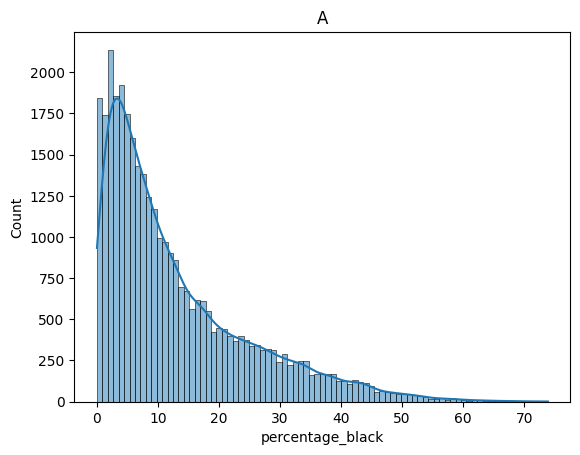

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_black'], kde=True).set(title='A')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='percentage_black', ylabel='Count'>

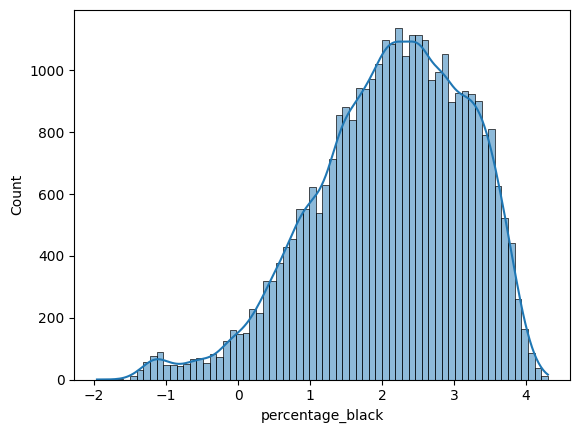

In [ ]:
sns.histplot(np.log(final_merged_gdf_subset['percentage_black']), kde=True)

<Axes: xlabel='percentage_white', ylabel='Count'>

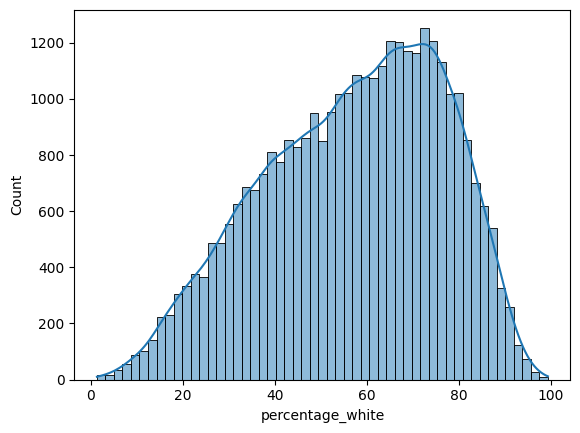

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_white'], kde=True)

<Axes: xlabel='pop_density', ylabel='Count'>

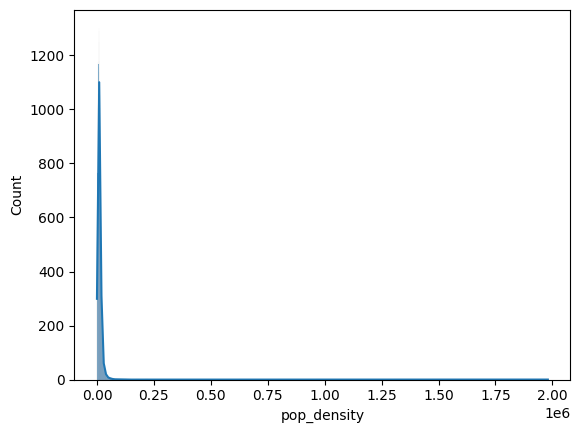

In [ ]:
sns.histplot(final_merged_gdf_subset['pop_density'], kde=True)

<Axes: xlabel='pop_density', ylabel='Count'>

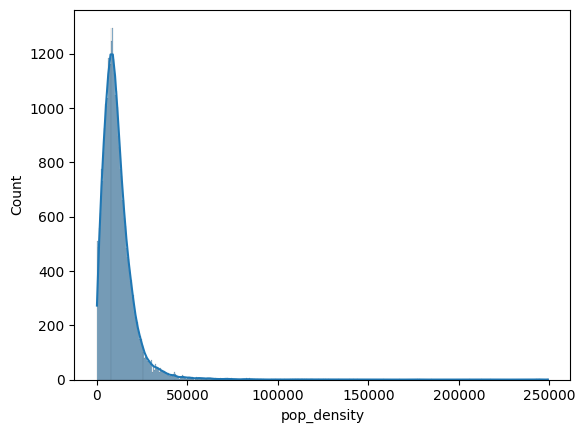

In [ ]:
final_merged_gdf_subset_no_E00014344 = final_merged_gdf_subset.loc[final_merged_gdf_subset['pop_density'] != 1980000.0]
sns.histplot(final_merged_gdf_subset_no_E00014344['pop_density'], kde=True)

<Axes: xlabel='pop_density', ylabel='Count'>

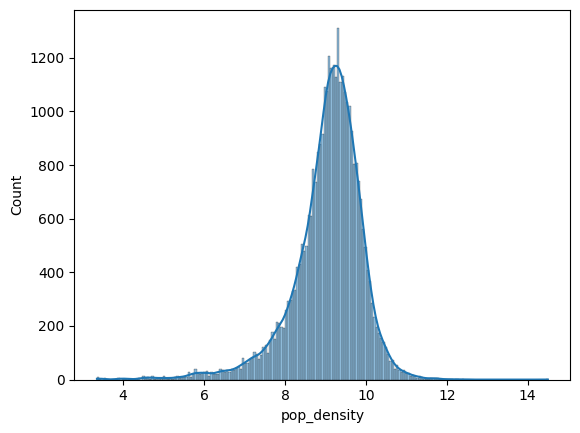

In [ ]:
sns.histplot(np.log(final_merged_gdf_subset['pop_density']), kde=True)

<Axes: xlabel='percentage_deprived', ylabel='Count'>

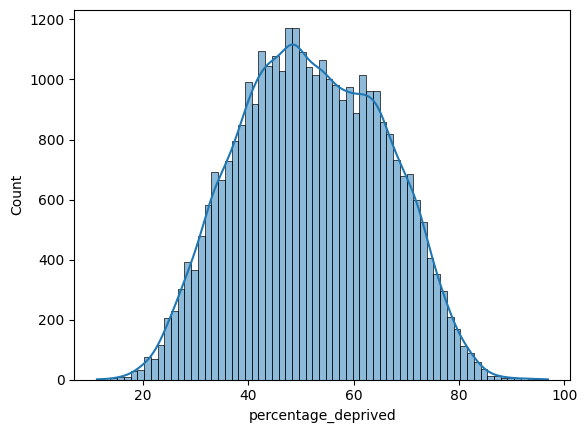

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_deprived'], kde=True)

<Axes: xlabel='percentage_not_deprived', ylabel='Count'>

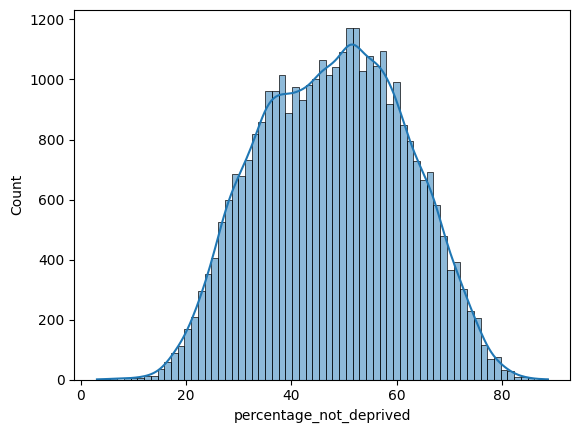

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_not_deprived'] , kde=True)

<Axes: xlabel='percentage_small_hh', ylabel='Count'>

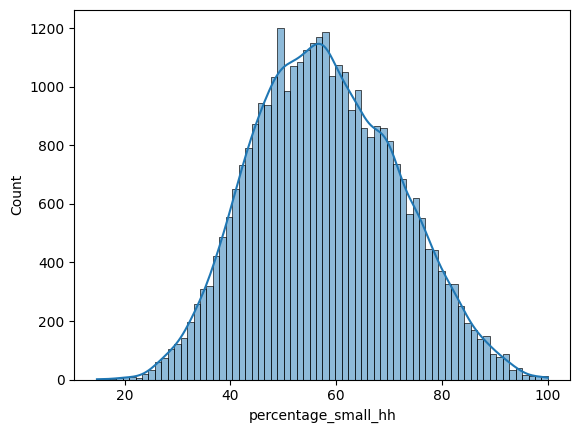

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_small_hh'], kde=True)

<Axes: xlabel='percentage_large_hh', ylabel='Count'>

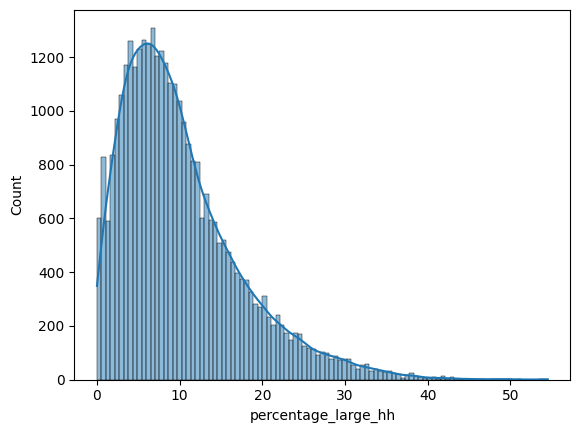

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_large_hh'], kde=True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='percentage_large_hh', ylabel='Count'>

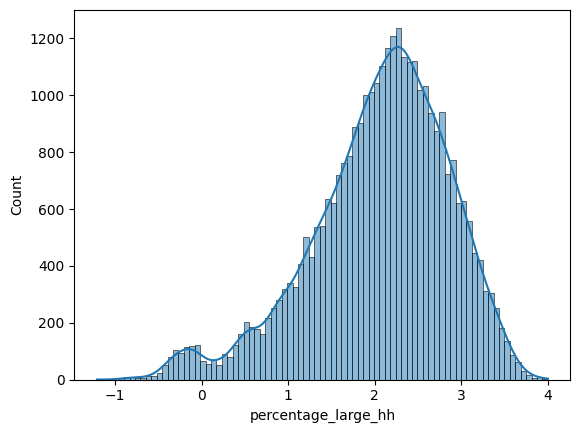

In [ ]:
sns.histplot(np.log(final_merged_gdf_subset['percentage_large_hh']), kde=True)

<Axes: xlabel='percentage_medium_hh', ylabel='Count'>

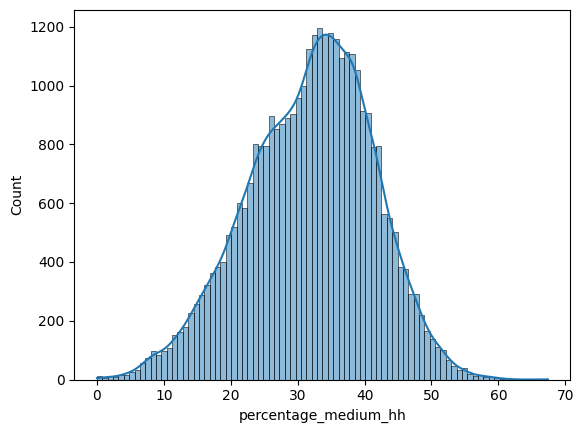

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_medium_hh'], kde=True)

<Axes: xlabel='percentage_no_edu', ylabel='Count'>

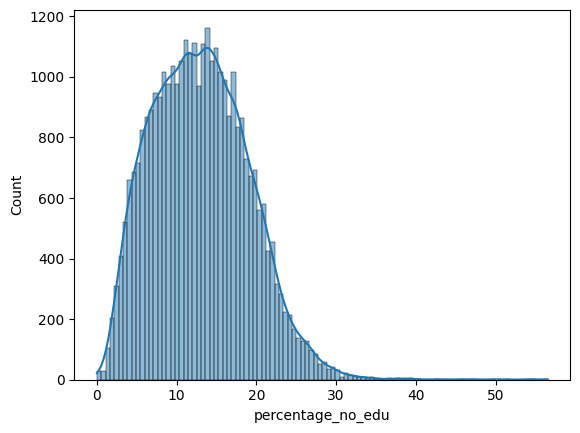

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_no_edu'], kde=True)

<Axes: xlabel='percentage_school_edu', ylabel='Count'>

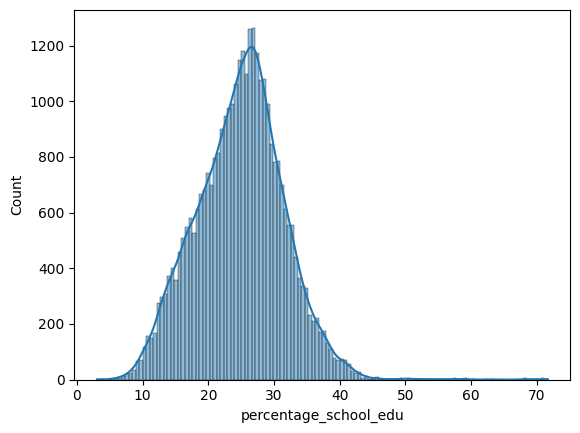

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_school_edu'] , kde=True)

[Text(0.5, 1.0, 'B')]

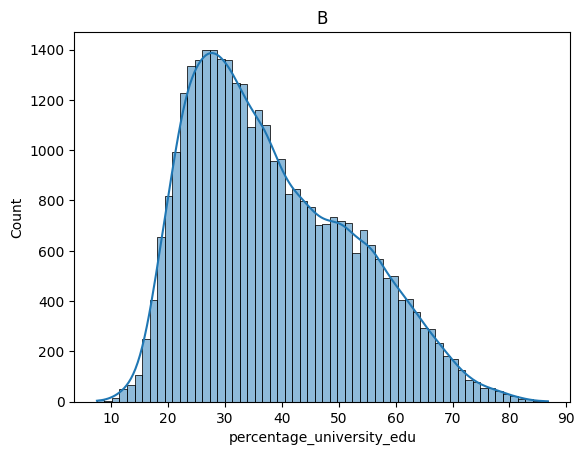

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_university_edu'], kde=True).set(title='B')

<Axes: xlabel='percentage_no_cars', ylabel='Count'>

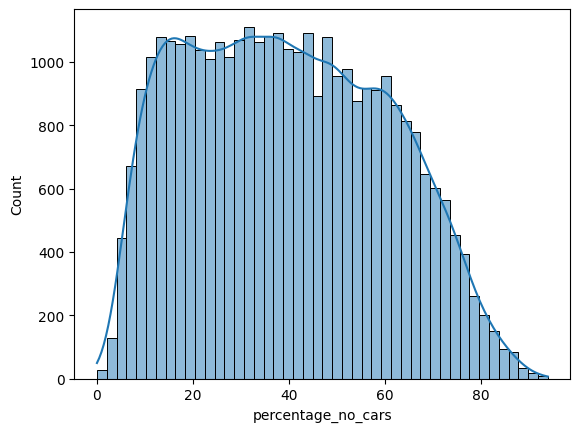

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_no_cars'], kde=True)

<Axes: xlabel='percentage_one_car', ylabel='Count'>

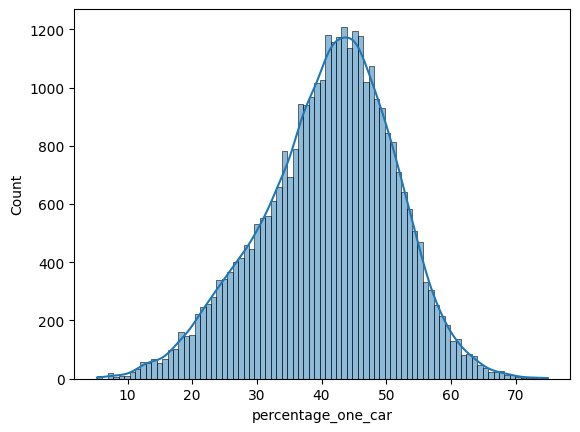

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_one_car'], kde=True)

<Axes: xlabel='percentage_2+_cars', ylabel='Count'>

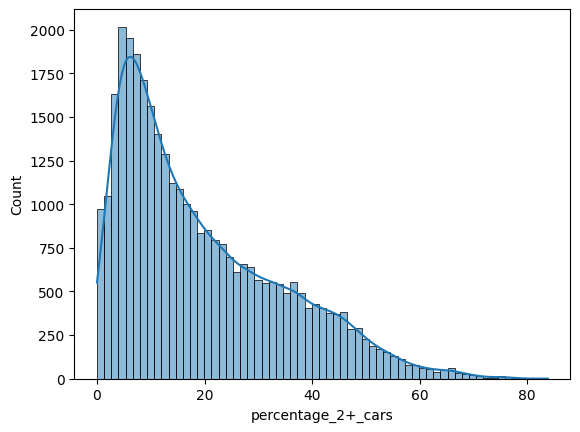

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_2+_cars'] , kde=True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='percentage_2+_cars', ylabel='Count'>

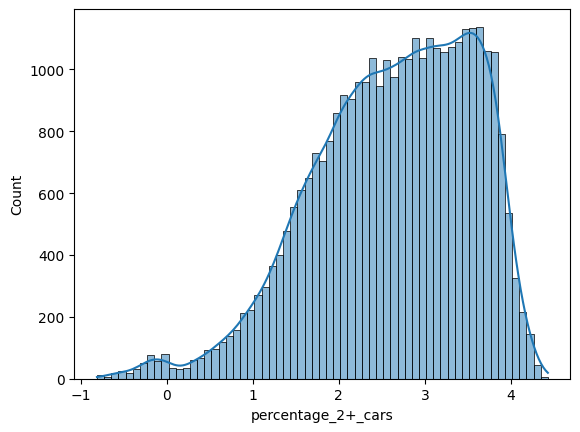

In [ ]:
sns.histplot(np.log(final_merged_gdf_subset['percentage_2+_cars']), kde=True)

[Text(0.5, 1.0, 'C')]

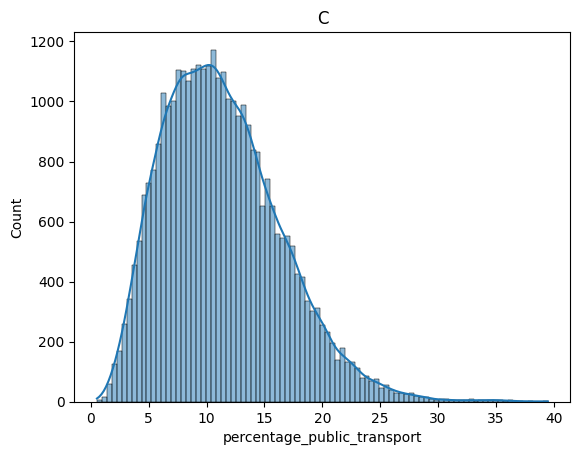

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_public_transport'], kde=True).set(title='C')

<Axes: xlabel='percentage_drive_car', ylabel='Count'>

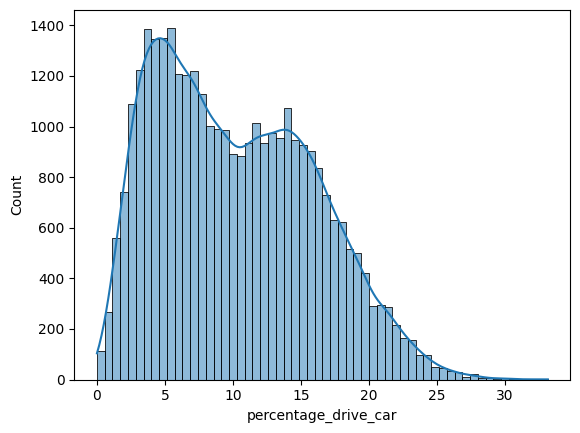

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_drive_car'], kde=True)

[Text(0.5, 1.0, 'D')]

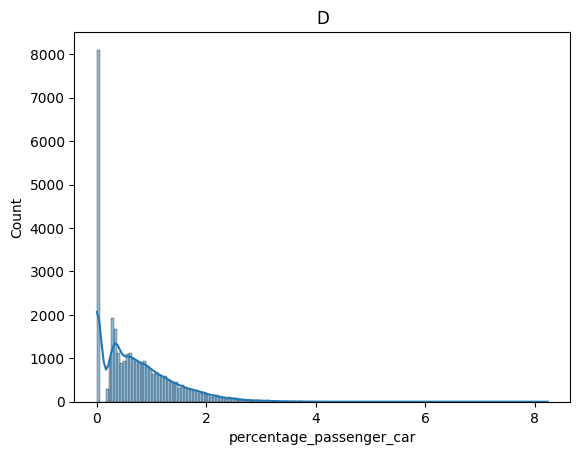

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_passenger_car'], kde=True).set(title='D')
#logging is worse

<Axes: xlabel='median_age', ylabel='Count'>

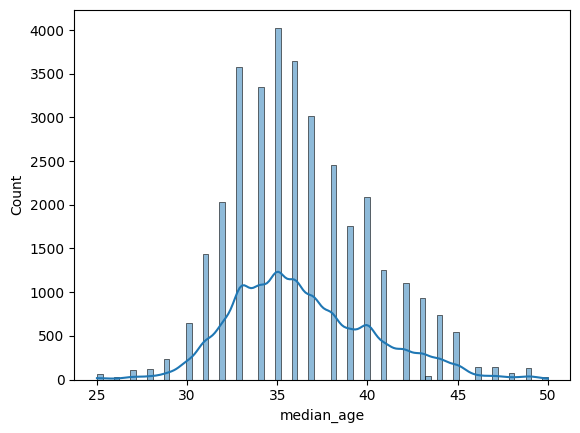

In [ ]:
sns.histplot(final_merged_gdf_subset['median_age'] , kde=True)

<Axes: xlabel='average_income', ylabel='Count'>

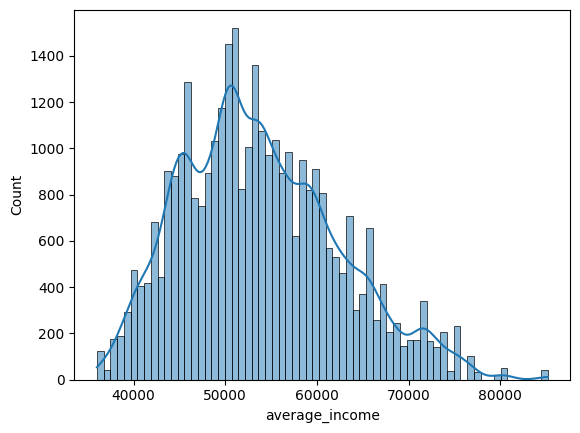

In [ ]:
sns.histplot(final_merged_gdf_subset['average_income'], kde=True)

<Axes: xlabel='percentage_shared_flat', ylabel='Count'>

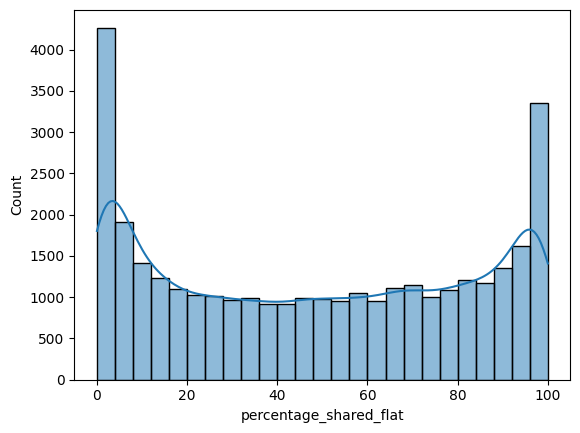

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_shared_flat'], kde=True)
# logging is worse

<Axes: xlabel='percentage_house', ylabel='Count'>

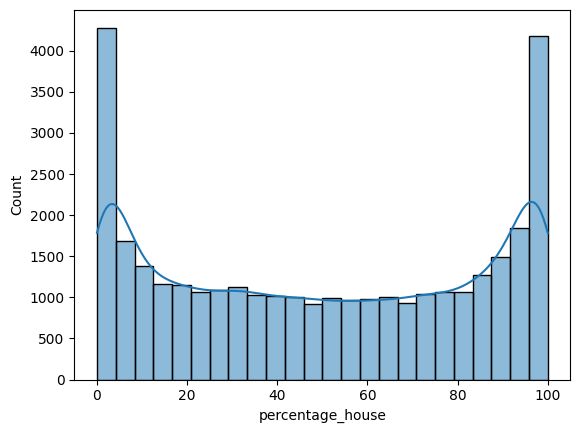

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_house'], kde=True)
#logging is worse

[Text(0.5, 1.0, 'E')]

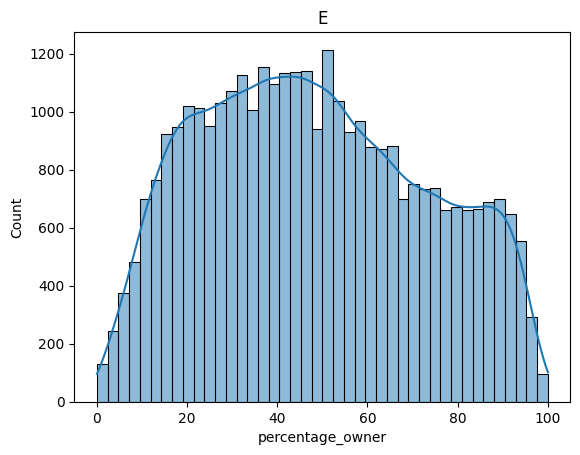

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_owner'] , kde=True).set(title='E')

[Text(0.5, 1.0, 'F')]

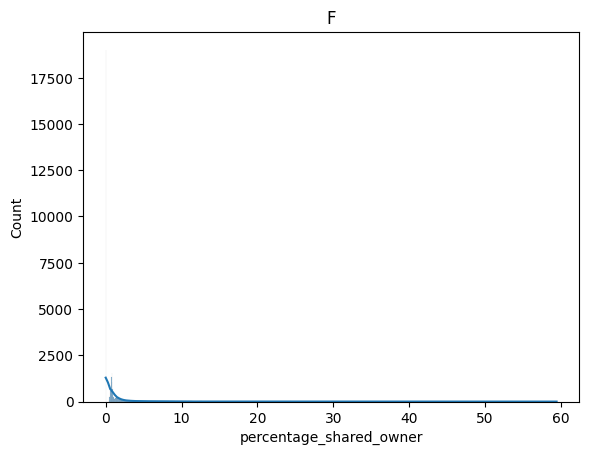

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_shared_owner'], kde=True).set(title='F')
#logging is worse

<Axes: xlabel='percentage_renter', ylabel='Count'>

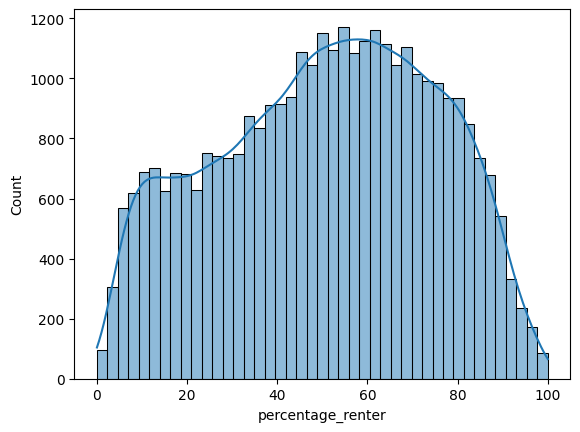

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_renter'], kde=True)

[Text(0.5, 1.0, 'G')]

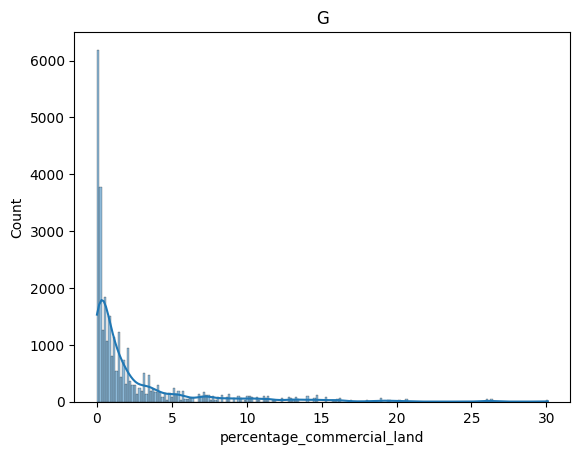

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_commercial_land'], kde=True).set(title='G')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='percentage_commercial_land', ylabel='Count'>

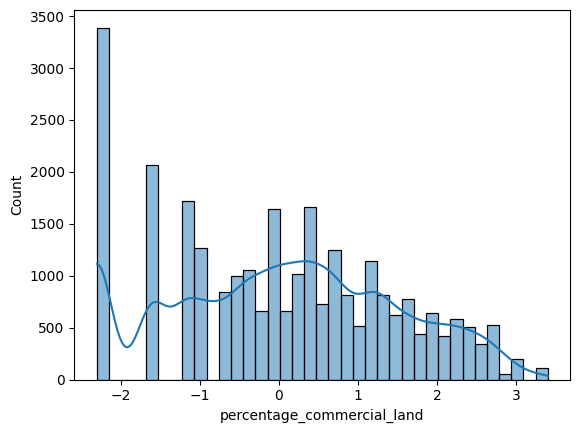

In [ ]:
# return to
sns.histplot(np.log(final_merged_gdf_subset['percentage_commercial_land']), kde=True)

<Axes: xlabel='percentage_roads', ylabel='Count'>

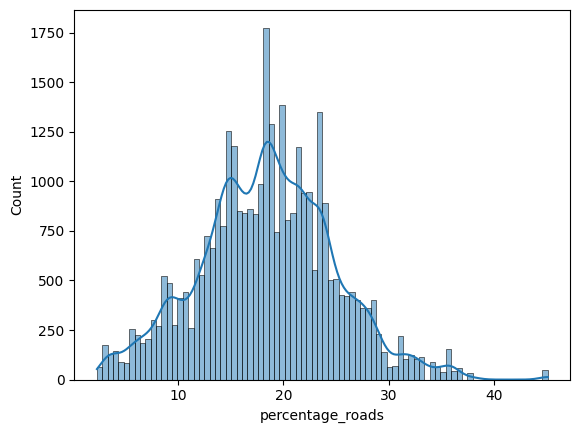

In [ ]:
sns.histplot(final_merged_gdf_subset['percentage_roads'], kde=True)

[Text(0.5, 1.0, 'H')]

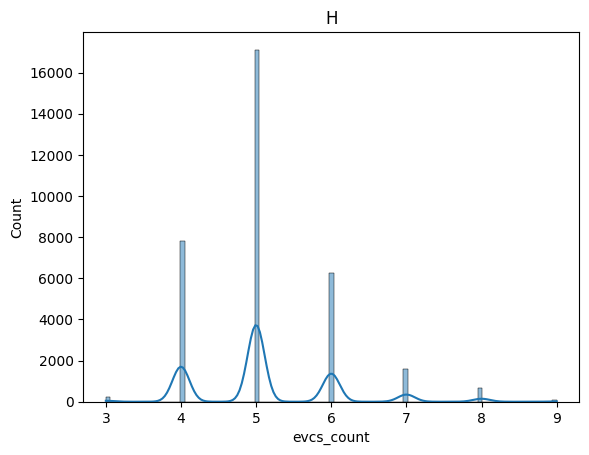

In [ ]:
sns.histplot(final_merged_gdf_subset['evcs_count'], kde=True).set(title='H')

[Text(0.5, 1.0, 'I')]

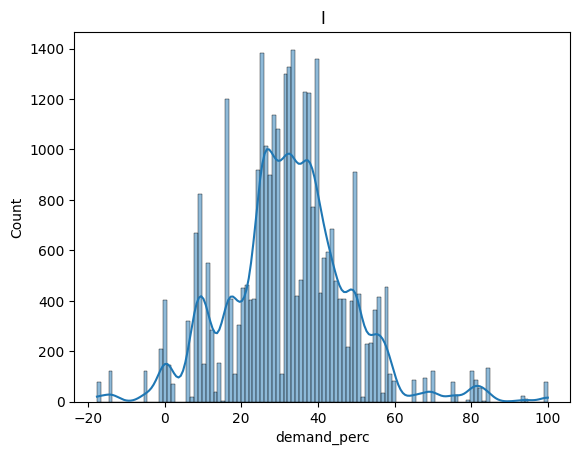

In [ ]:
sns.histplot(final_merged_gdf_subset['demand_perc'], kde=True).set(title='I')

## EDA

### Correlation Matrix

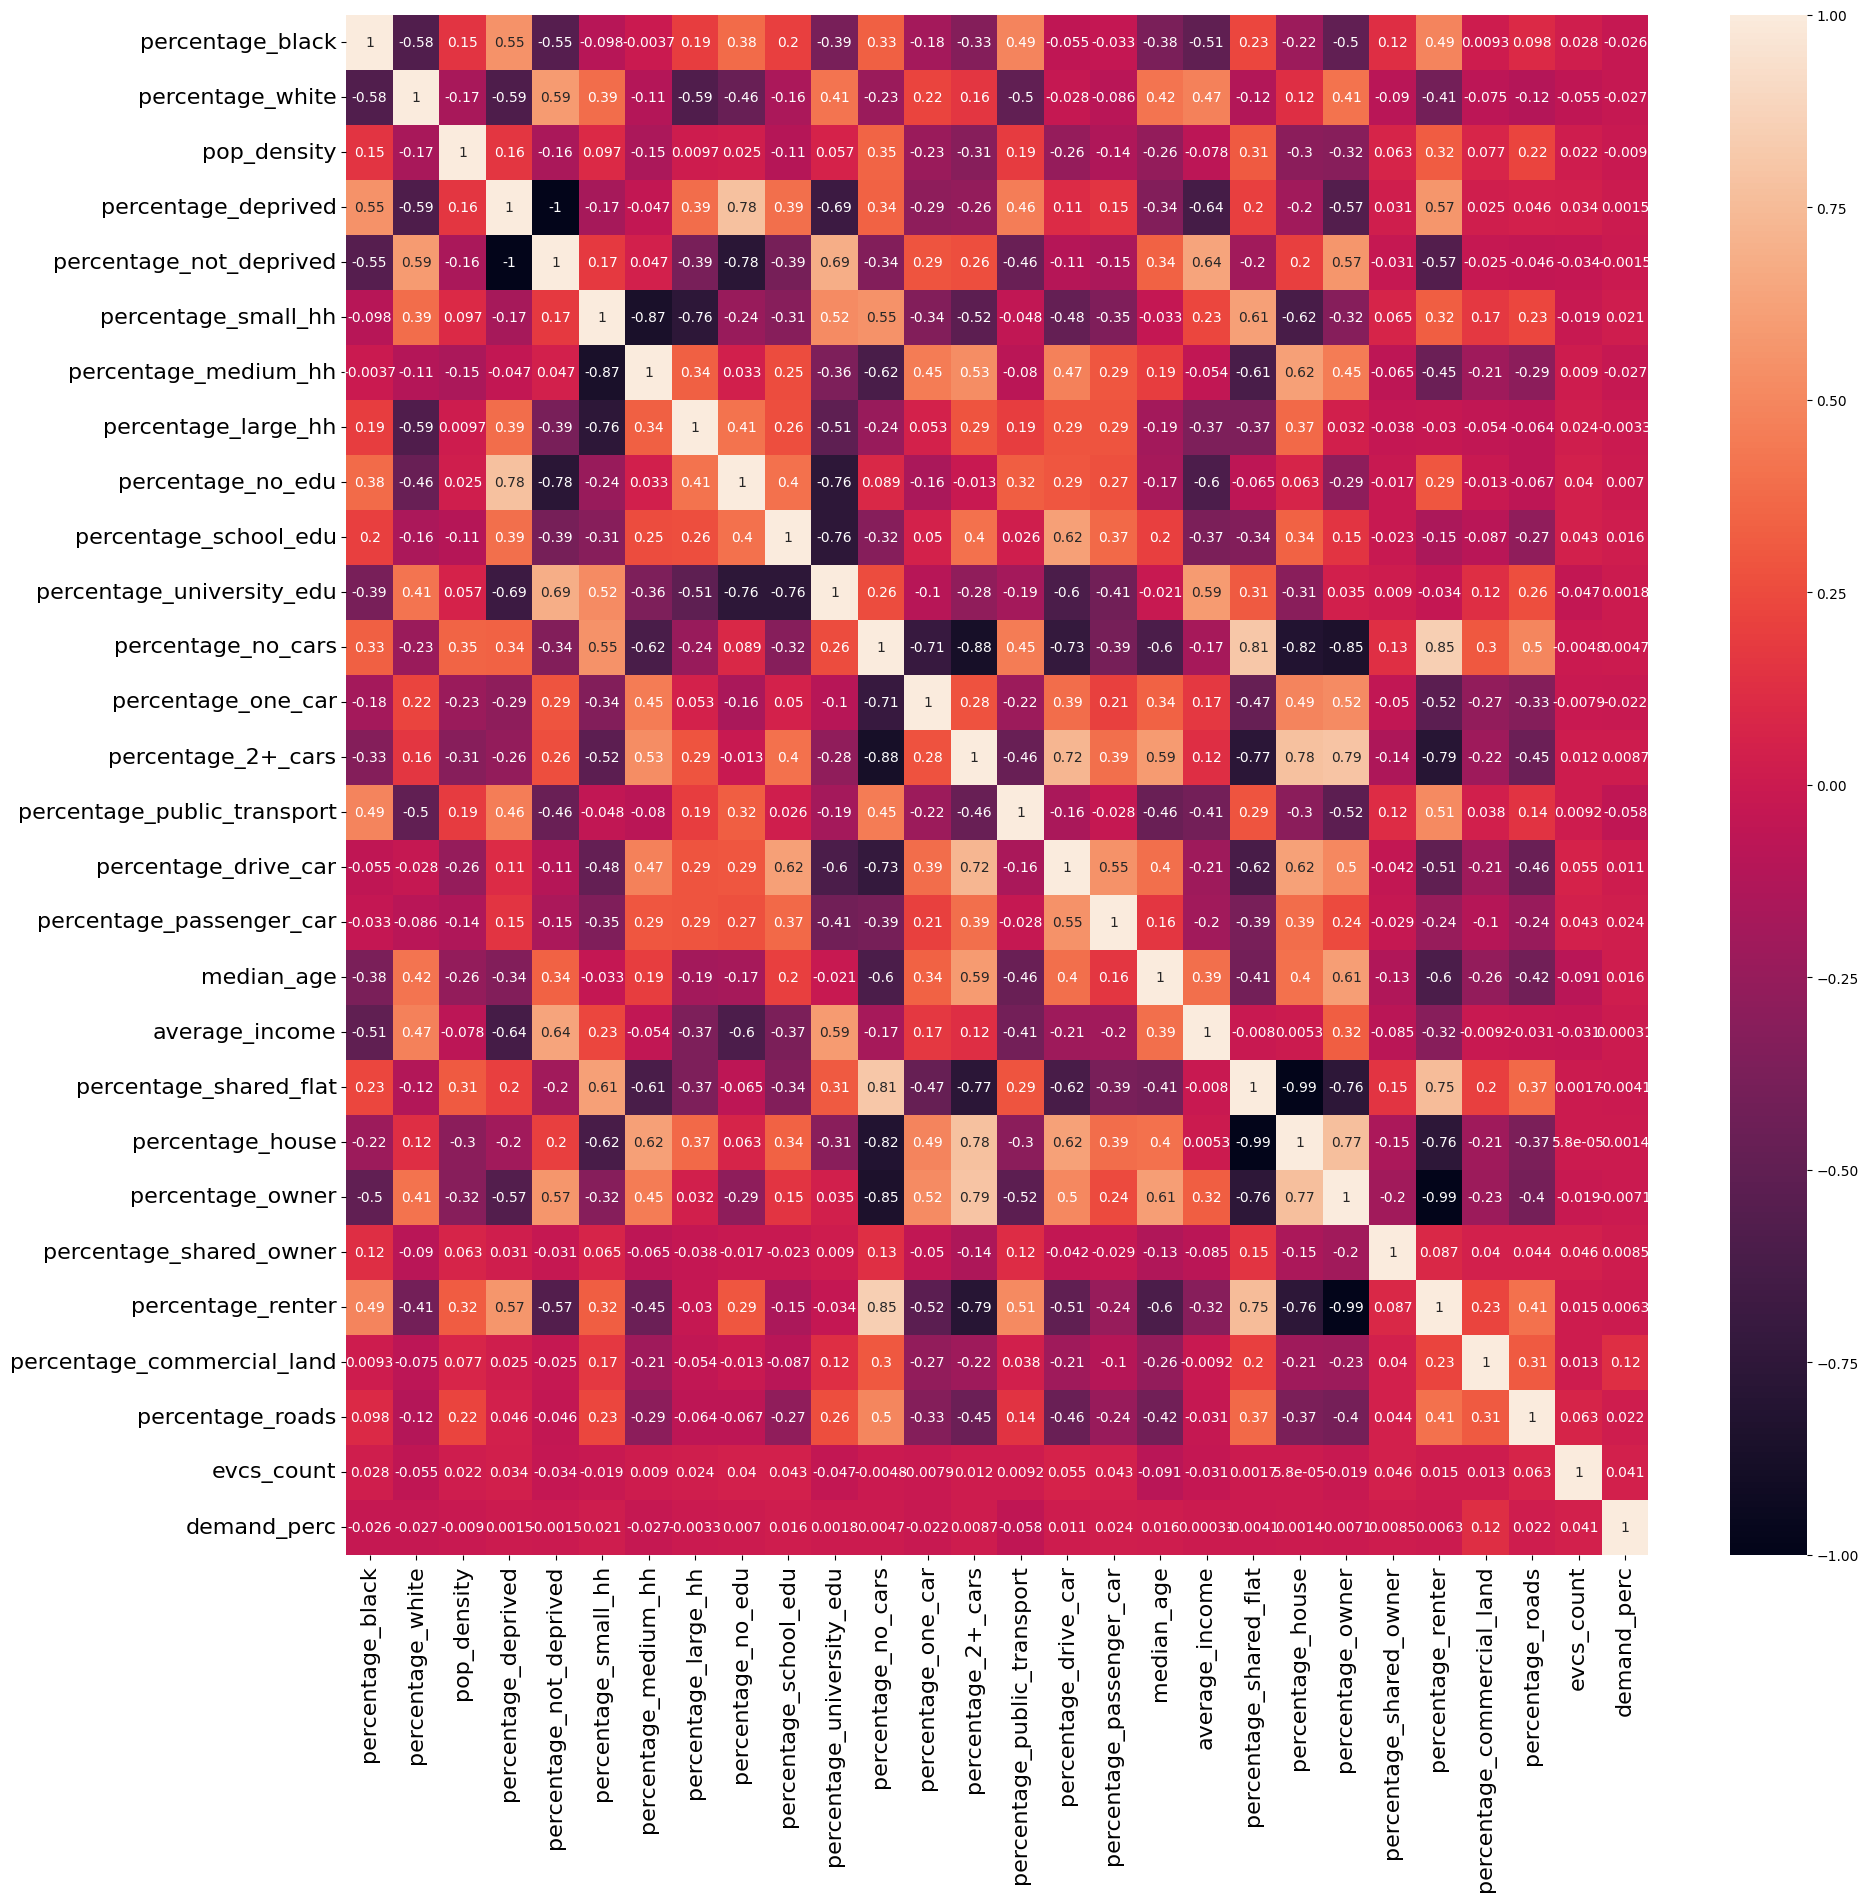

In [ ]:
corr_matrix = final_merged_gdf_subset.corr()

# Set the figure size
plt.figure(figsize=(21, 20))

heat_plot = sns.heatmap(corr_matrix, annot=True)
heat_plot.set_xticklabels(heat_plot.get_xmajorticklabels(), fontsize = 16)
heat_plot.set_yticklabels(heat_plot.get_ymajorticklabels(), fontsize = 16)

plt.savefig('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/corr_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
corr_matrix
# save table as csv
path = '/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/corr_matrix.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  corr_matrix.to_csv(f)

### Scatter plots (assumption testing)
Only done using variables used in ols2 models

#### vs. EVCS

In [ ]:
sns.regplot(y='evcs_count',x='percentage_black', data=final_merged_gdf_subset)
plt.show()

NameError: ignored

In [ ]:
sns.regplot(y='evcs_count',x='log_percentage_black', data=evcs_clean_data_merged_gdf)
plt.show()

In [ ]:
# polynomial?
sns.lmplot(y='evcs_count', x='percentage_black', data=final_merged_gdf_subset, order=2)
# Show the plots
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_white', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='pop_density', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='pop_density', data=final_merged_gdf_subset_no_E00014344)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_deprived', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_large_hh', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='log_percentage_large_hh', data=evcs_clean_data_merged_gdf)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_no_edu', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_university_edu', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_2+_cars', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_drive_car', data=final_merged_gdf_subset)
plt.show()

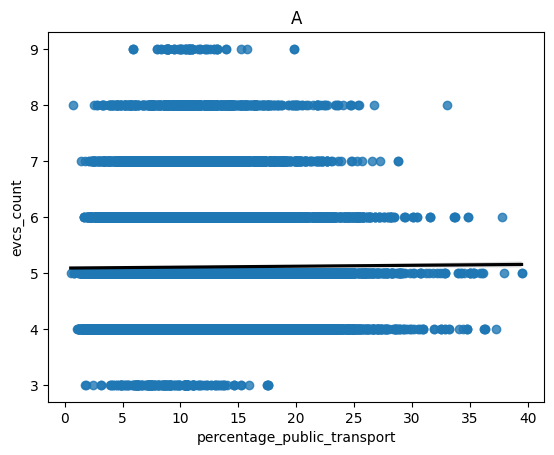

In [ ]:
ax = sns.regplot(y='evcs_count',x='percentage_public_transport', data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='A')
plt.show()

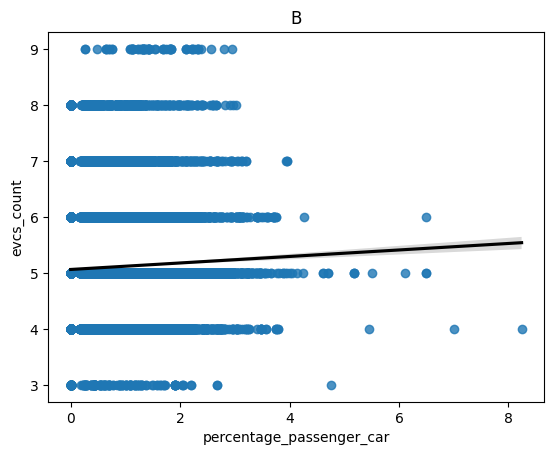

In [ ]:
ax=sns.regplot(y='evcs_count',x='percentage_passenger_car', data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='B')
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='median_age', data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='average_income', data=final_merged_gdf_subset)
plt.show()

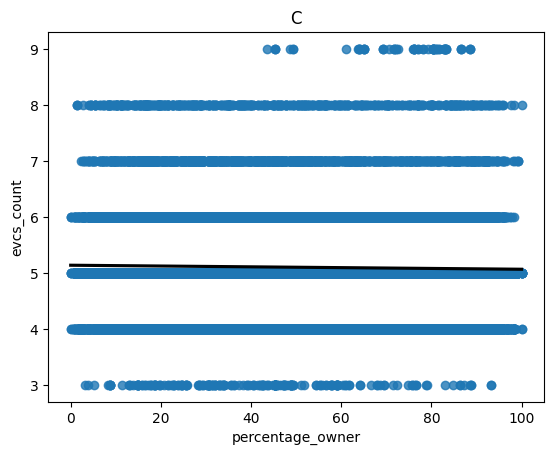

In [ ]:
ax=sns.regplot(y='evcs_count',x='percentage_owner', data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='C')
plt.show()

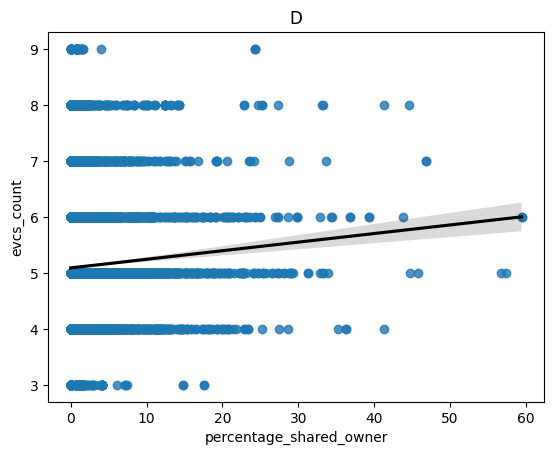

In [ ]:
ax=sns.regplot(y='evcs_count',x='percentage_shared_owner', data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='D')
plt.show()

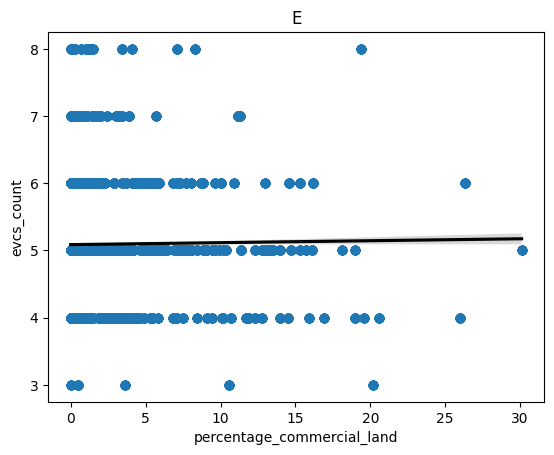

In [ ]:
ax=sns.regplot(y='evcs_count',x='percentage_commercial_land',data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='E')
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='log_percentage_commercial_land',data=evcs_clean_data_merged_gdf)
plt.show()

In [ ]:
sns.regplot(y='evcs_count',x='percentage_roads', data=final_merged_gdf_subset)
plt.show()

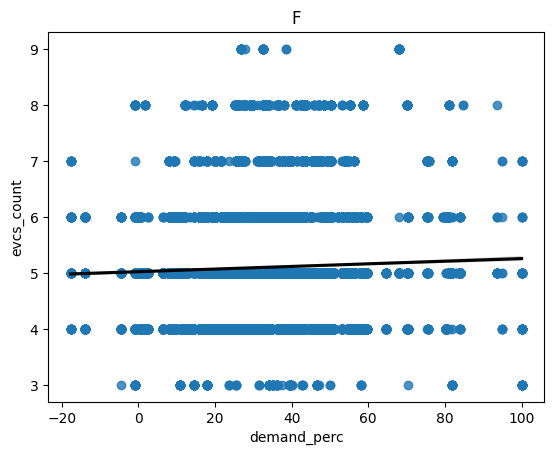

In [ ]:
ax=sns.regplot(y='evcs_count',x='demand_perc', data=final_merged_gdf_subset,
                  line_kws={"color": "black"}).set(title='F')
plt.show()

#### vs. Network Demand Headroom

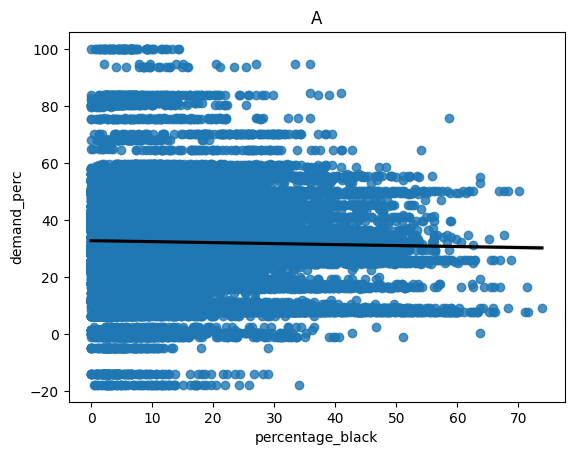

In [ ]:
ax=sns.regplot(y='demand_perc',x='percentage_black',data=final_merged_gdf_subset,
                              line_kws={"color": "black"}).set(title='A')
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='log_percentage_black',data=demand_clean_data_merged_gdf)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_white',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='pop_density',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='log_pop_density',data=demand_clean_data_merged_gdf)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_deprived',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_large_hh',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_school_edu',data=final_merged_gdf_subset)
plt.show()

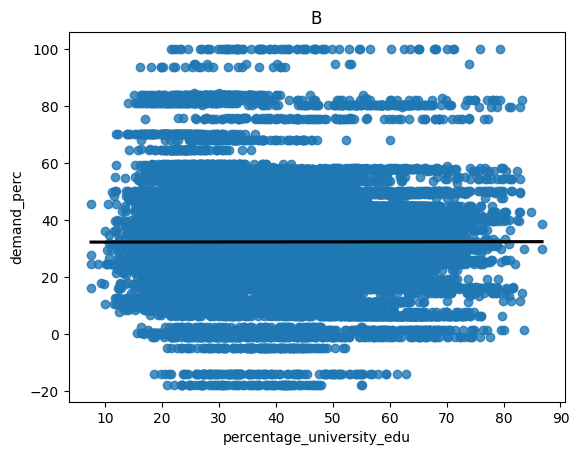

In [ ]:
ax=sns.regplot(y='demand_perc',x='percentage_university_edu',data=final_merged_gdf_subset,
                              line_kws={"color": "black"}).set(title='B')
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_one_car',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_drive_car',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_public_transport',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='median_age',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='average_income',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_shared_flat',data=final_merged_gdf_subset)
plt.show()

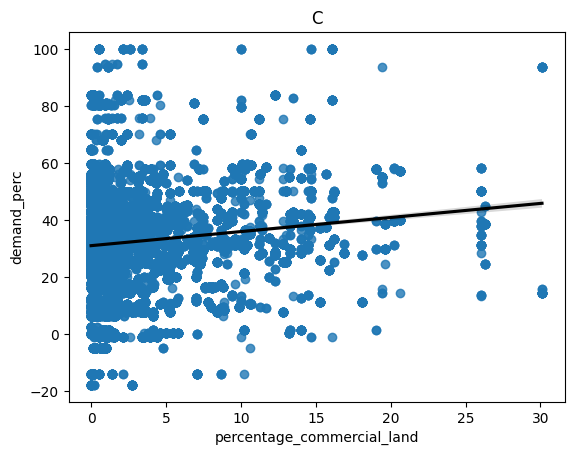

In [ ]:
ax=sns.regplot(y='demand_perc',x='percentage_commercial_land',data=final_merged_gdf_subset,
                                 line_kws={"color": "black"}).set(title='C')
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='percentage_roads',data=final_merged_gdf_subset)
plt.show()

In [ ]:
sns.regplot(y='demand_perc',x='evcs_count',data=final_merged_gdf_subset)
plt.show()

## OLS 1
Initial OLS regression, EDA, all variables included

### EVCS


In [ ]:
# model one now removes pop_density outlier

ols1e = final_merged_gdf_subset_no_E00014344.dropna()

X = ols1e[['percentage_black', 'percentage_white', 'pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car', 'percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads',
       'demand_perc']]

y = ols1e['evcs_count']

In [ ]:
X = sm.add_constant(X)
model_ols1e = sm.OLS(y, X).fit()
ols_summary = model_ols1e.summary()
ols_summary
robust_results = model_ols1e.get_robustcov_results(cov_type='HC3')  # HC3 is a popular robust estimator

# Print the summary with robust standard errors
print(robust_results.summary())
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols1e_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

                            OLS Regression Results                            
Dep. Variable:             evcs_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                 4.249e+04
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:54:42   Log-Likelihood:                -37033.
No. Observations:               29021   AIC:                         7.412e+04
Df Residuals:                   28996   BIC:                         7.432e+04
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 25
  warnings.warn('covariance of constraints does not have full '


### Network Demand Headroom


In [ ]:
# model one now removes pop_density outlier
ols1d = final_merged_gdf_subset_no_E00014344.dropna()

X = ols1d[['percentage_black', 'percentage_white', 'pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car', 'percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads',
       'evcs_count']]

y = ols1d['demand_perc']

In [ ]:
X = sm.add_constant(X)
model_ols1d = sm.OLS(y, X).fit()
ols_summary = model_ols1d.summary()

# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols1d_summary.csv', 'w') as f:
  f.write(ols_summary.as_csv())

## OLS 1DT - Data Transformations

Based on non-normality of residuals from model 1

To make variables look normal distribution:

* log_percentage_black
* log_pop_density
* log_percentage_large_hh
* log_percentage_2+_cars
* log_percentage_commercial_land

AND remove outliers

Re-run OLS with all variables

### EVCS

In [ ]:
# spatial gdf with only variables used in model
evcs_clean_data_merged_gdf = final_merged_gdf[['OA11CD','MSOA11CD','MSOA11NM','geometry','percentage_black', 'percentage_white', 'pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car', 'percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads',
       'demand_perc','evcs_count']]

evcs_clean_data_merged_gdf['log_percentage_black'] = np.log(evcs_clean_data_merged_gdf['percentage_black'])
evcs_clean_data_merged_gdf['log_pop_density'] = np.log(evcs_clean_data_merged_gdf['pop_density'])
evcs_clean_data_merged_gdf['log_percentage_large_hh'] = np.log(evcs_clean_data_merged_gdf['percentage_large_hh'])
evcs_clean_data_merged_gdf['log_percentage_2+_cars'] = np.log(evcs_clean_data_merged_gdf['percentage_2+_cars'])
evcs_clean_data_merged_gdf['log_percentage_commercial_land'] = np.log(evcs_clean_data_merged_gdf['percentage_commercial_land'])

# ensure positive
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf[evcs_clean_data_merged_gdf['log_percentage_black'] >= 0]
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf[evcs_clean_data_merged_gdf['log_pop_density'] >= 0]
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf[evcs_clean_data_merged_gdf['log_percentage_large_hh'] >= 0]
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf[evcs_clean_data_merged_gdf['log_percentage_2+_cars'] >= 0]
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf[evcs_clean_data_merged_gdf['log_percentage_commercial_land'] >= 0]

# replace with nas
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf.replace([np.inf, -np.inf], np.nan)
# drop na
evcs_clean_data_merged_gdf = evcs_clean_data_merged_gdf.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages

In [ ]:
# remove outliers function

def remove_outliers(df, columns, z_threshold=3):
    """
    Remove outliers from specified columns in a pandas DataFrame using Z-score method.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to remove outliers from
    - z_threshold: Z-score threshold for outlier detection (default: 3)

    Returns:
    - df_cleaned: DataFrame with outliers removed
    """
    df_cleaned = df.copy()

    for col in columns:
        z_scores = np.abs(stats.zscore(df_cleaned[col]))
        outliers = z_scores > z_threshold
        df_cleaned = df_cleaned[~outliers]

    return df_cleaned

columns_to_check = ['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']

evcs_clean_data_merged_gdf = remove_outliers(evcs_clean_data_merged_gdf, columns_to_check)

In [ ]:
ols1dte = evcs_clean_data_merged_gdf.dropna()

X = ols1dte[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']]

y = ols1dte['evcs_count']

In [ ]:
X = sm.add_constant(X)
model_ols1dte = sm.OLS(y, X).fit()
ols_summary = model_ols1dte.summary()
ols_summary
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols1dte_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             evcs_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     27.32
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          1.37e-128
Time:                        16:54:55   Log-Likelihood:                -14431.
No. Observations:               10997   AIC:                         2.892e+04
Df Residuals:                   10970   BIC:                         2.911e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0003      0.000      0.959      0.337      -0.000       0.001
log_percentage_black               0.0819      0.015      5.553      0.000       0.053       0.111
percentage_white                   0.0014      0.001      1.734      0.083      -0.000       0.003
log_pop_density                    0.0415      0.016      2.543      0.011       0.010       0.074
percentage_deprived                0.0164      0.017      0.957      0.338      -0.017       0.050
percentage_not_deprived            0.0166      0.017      0.959      0.338      -0.017       0.050
percentage_small_hh                0.0106      0.003      3.044      0.002       0.004       0.017
percentage_medium_hh               0.0050      0.003      1.450      0.147      -0.002       0.012
log_percentage_large_hh           -0.0283      0.032     -0.883      0.377      -0.091       0.034
percentage_no_edu                 -0.0061      0.003     -1.893      0.058      -0.012       0.000
percentage_school_edu             -0.0040      0.003     -1.450      0.147      -0.009       0.001
percentage_university_edu         -0.0127      0.002     -5.798      0.000      -0.017      -0.008
percentage_no_cars                -0.0146      0.003     -5.206      0.000      -0.020      -0.009
percentage_one_car                -0.0136      0.002     -5.881      0.000      -0.018      -0.009
log_percentage_2+_cars            -0.1291      0.030     -4.340      0.000      -0.187      -0.071
percentage_public_transport        0.0119      0.002      5.034      0.000       0.007       0.017
percentage_drive_car               0.0251      0.004      6.402      0.000       0.017       0.033
percentage_passenger_car           0.0146      0.019      0.787      0.431      -0.022       0.051
median_age                        -0.0481      0.004    -12.007      0.000      -0.056      -0.040
average_income                  2.599e-05   1.59e-06     16.339      0.000    2.29e-05    2.91e-05
percentage_shared_flat             0.0036      0.003      1.455      0.146      -0.001       0.009
percentage_house                   0.0043      0.003      1.686      0.092      -0.001       0.009
percentage_owner                   0.0350      0.016      2.150      0.032       0.003       0.067
percentage_shared_owner            0.0624      0.017      3.633      0.000       0.029       0.096
percentage_renter                  0.0342      0.016      2.109      0.035       0.002       0.066
log_percentage_commercial_land    -0.0476      0.011     -4.356      0.000      -0.069      -0.026
percentage_roads                   0.0137      0.002      7.265      0.000       0.010       0.017
demand_perc                        0.0056      0.001      9.381      0.000       0.004       0.007
==============

### Network Demand Headroom

In [ ]:
# spatial gdf with only variables used in model

demand_clean_data_merged_gdf = final_merged_gdf[['OA11CD','MSOA11CD','MSOA11NM','geometry','percentage_black', 'percentage_white', 'pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car', 'percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'percentage_commercial_land', 'percentage_roads',
       'evcs_count','demand_perc']]

demand_clean_data_merged_gdf['log_percentage_black'] = np.log(demand_clean_data_merged_gdf['percentage_black'])
demand_clean_data_merged_gdf['log_pop_density'] = np.log(demand_clean_data_merged_gdf['pop_density'])
demand_clean_data_merged_gdf['log_percentage_large_hh'] = np.log(demand_clean_data_merged_gdf['percentage_large_hh'])
demand_clean_data_merged_gdf['log_percentage_2+_cars'] = np.log(demand_clean_data_merged_gdf['percentage_2+_cars'])
demand_clean_data_merged_gdf['log_percentage_commercial_land'] = np.log(demand_clean_data_merged_gdf['percentage_commercial_land'])

# ensure positive - checked and works
demand_clean_data_merged_gdf = demand_clean_data_merged_gdf[demand_clean_data_merged_gdf['log_percentage_black'] >= 0]
demand_clean_data_merged_gdf = demand_clean_data_merged_gdf[demand_clean_data_merged_gdf['log_pop_density'] >= 0]
demand_clean_data_merged_gdf = demand_clean_data_merged_gdf[demand_clean_data_merged_gdf['log_percentage_large_hh'] >= 0]
demand_clean_data_merged_gdf = demand_clean_data_merged_gdf[demand_clean_data_merged_gdf['log_percentage_2+_cars'] >= 0]
demand_clean_data_merged_gdf = demand_clean_data_merged_gdf[demand_clean_data_merged_gdf['log_percentage_commercial_land'] >= 0]

demand_clean_data_merged_gdf = demand_clean_data_merged_gdf.replace([np.inf, -np.inf], np.nan)

demand_clean_data_merged_gdf = demand_clean_data_merged_gdf.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages

In [ ]:
# remove outliers

def remove_outliers(df, columns, z_threshold=3):
    """
    Remove outliers from specified columns in a pandas DataFrame using Z-score method.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to remove outliers from
    - z_threshold: Z-score threshold for outlier detection (default: 3)

    Returns:
    - df_cleaned: DataFrame with outliers removed
    """
    df_cleaned = df.copy()

    for col in columns:
        z_scores = np.abs(stats.zscore(df_cleaned[col]))
        outliers = z_scores > z_threshold
        df_cleaned = df_cleaned[~outliers]

    return df_cleaned

columns_to_check = ['log_percentage_black', 'percentage_white', 'log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
        'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']

demand_clean_data_merged_gdf = remove_outliers(demand_clean_data_merged_gdf, columns_to_check)

In [ ]:
ols1dtd = demand_clean_data_merged_gdf.dropna()

X = ols1dtd[['log_percentage_black', 'percentage_white', 'log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
        'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']]

y = ols1dtd['demand_perc']

In [ ]:
X = sm.add_constant(X)
model_ols1dtd = sm.OLS(y, X).fit()
ols_summary = model_ols1dtd.summary()

# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols1dtd_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

## Dropping variables 1
Remove variables to deal with multicollinearity shown in correlation matrix

Removed from both EVCS and demand models:
* no edu,
* deprived,
* not deprived,
* school,
* small hh,
* renter,
* no cars,
* drive car,
* house,
* shared flat,
* 2+cars


### EVCS 2 Correlation Matrix

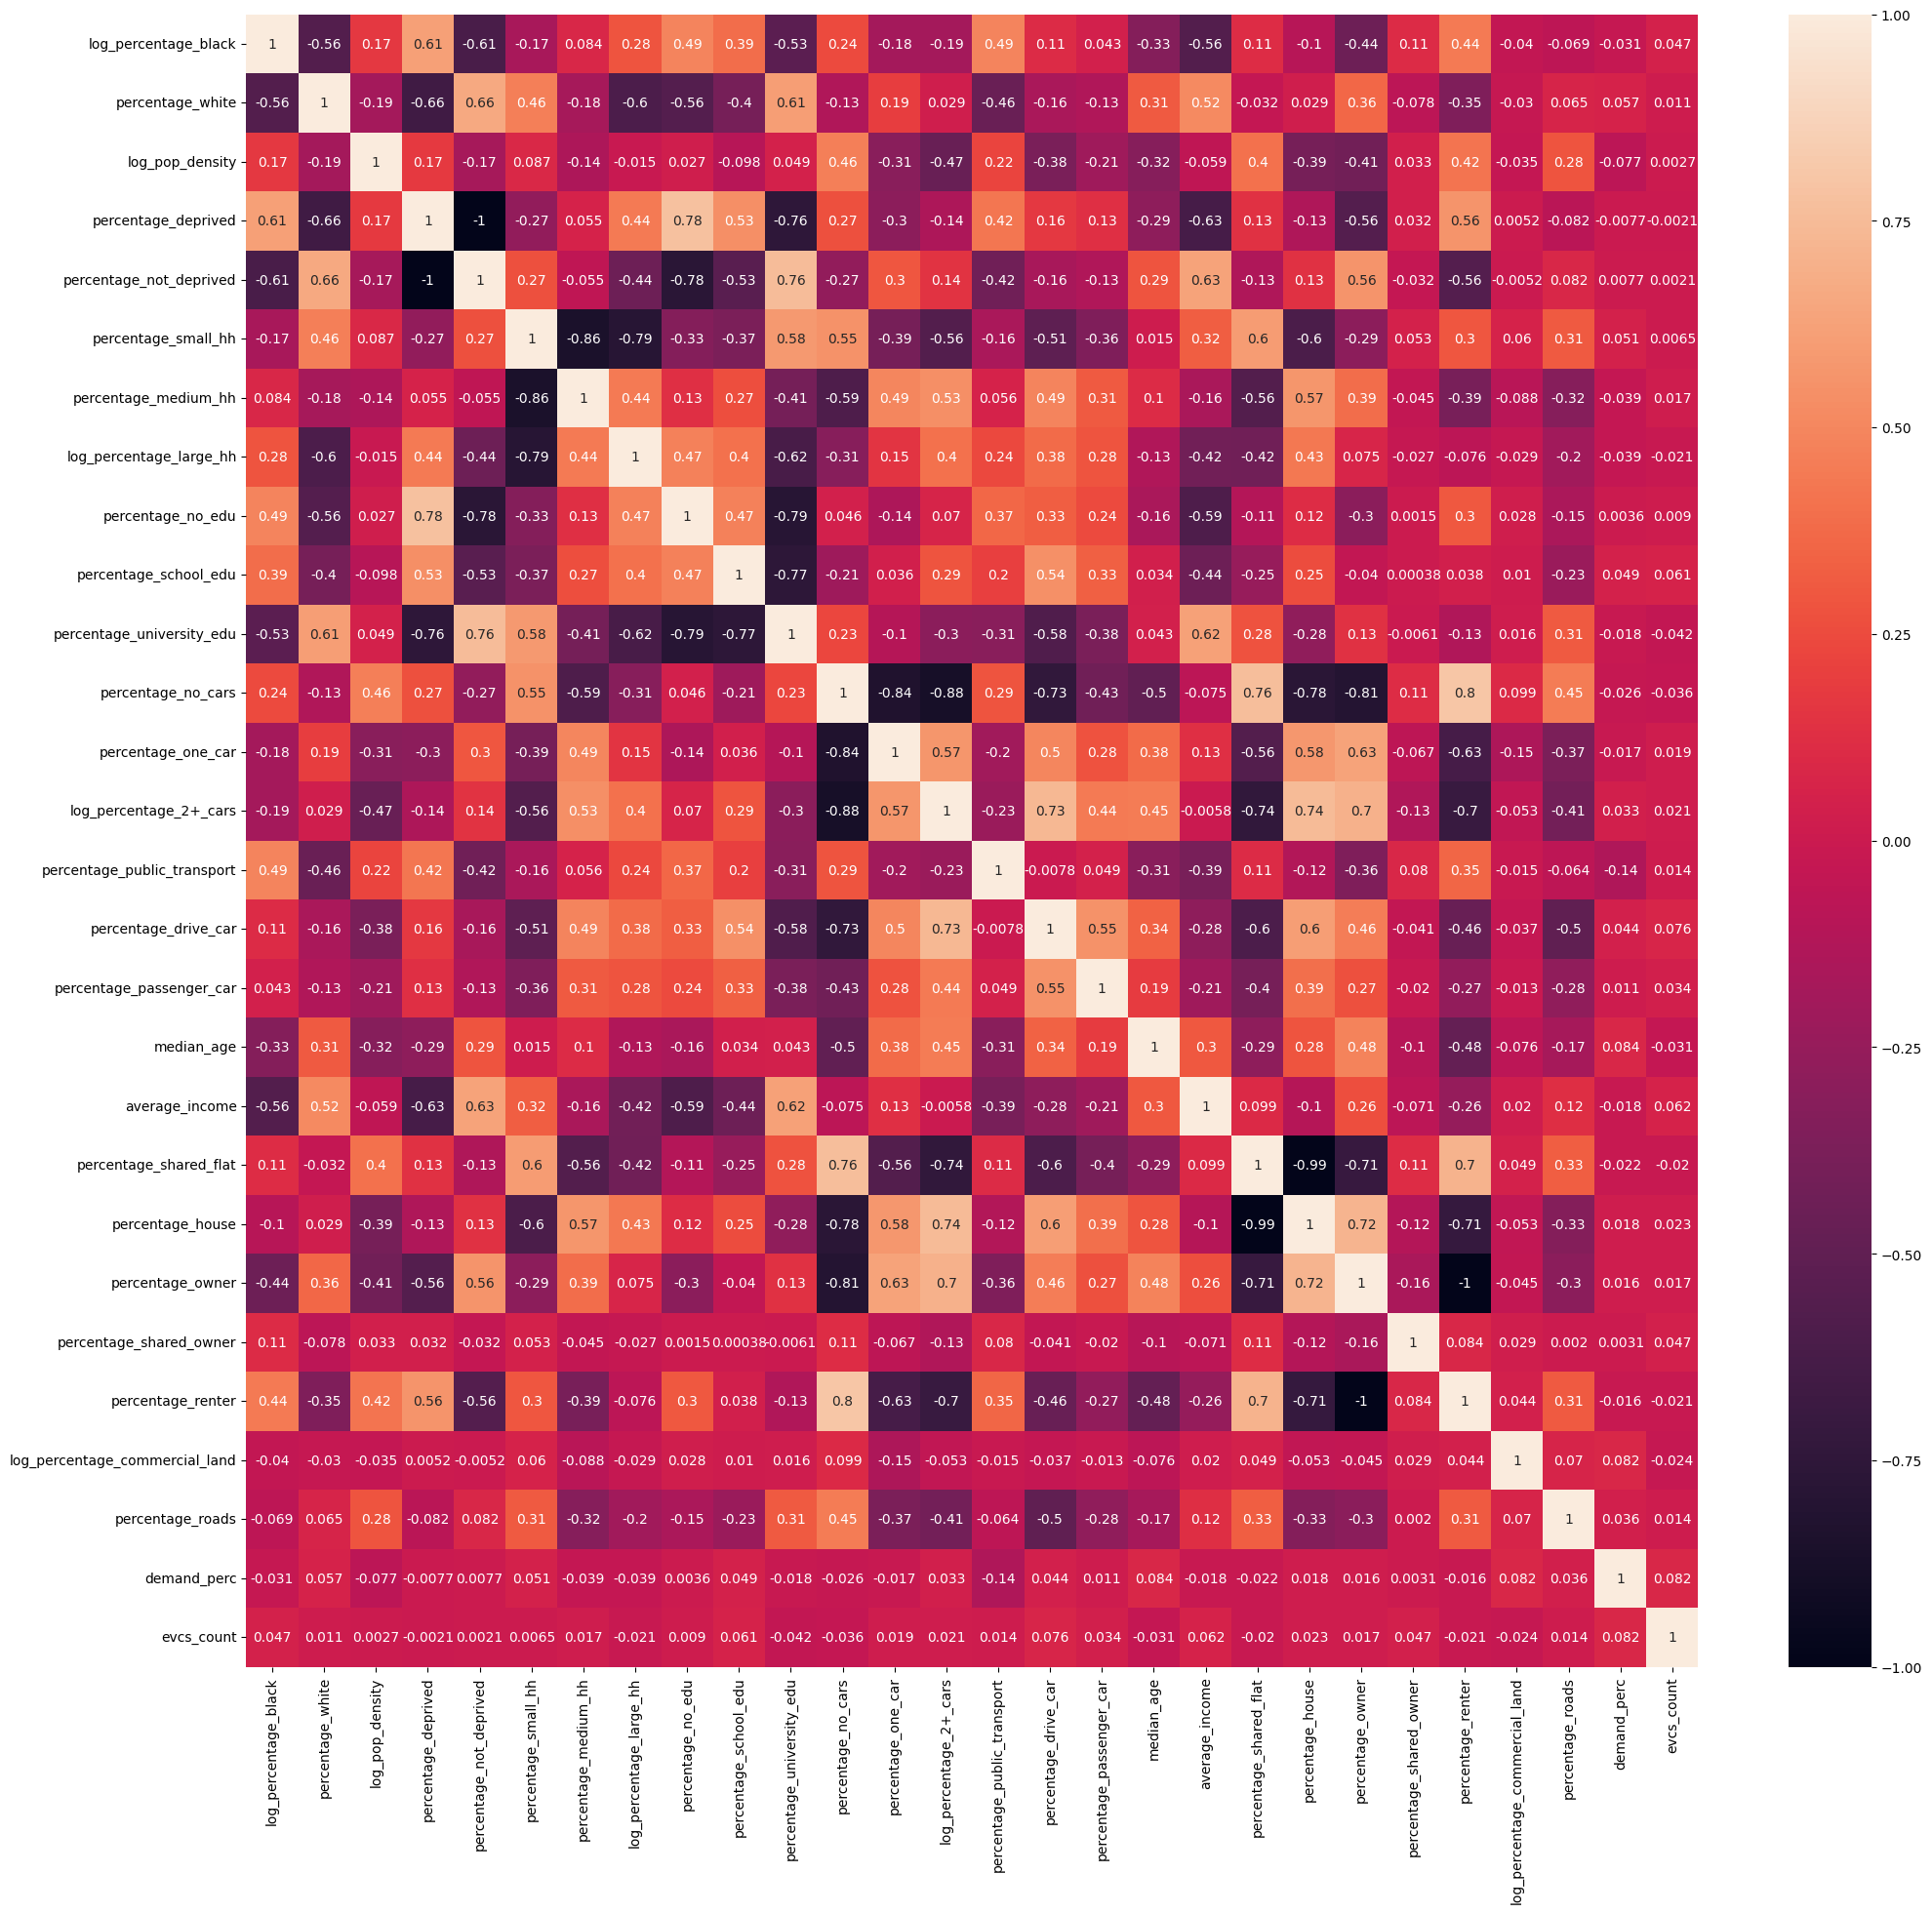

In [ ]:
evcs_subset_2 = evcs_clean_data_merged_gdf[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc','evcs_count']]

# evcs corr matrix
corr_matrix = evcs_subset_2.corr()

# Set the figure size
plt.figure(figsize=(24, 22))

sns.heatmap(corr_matrix, annot=True)
plt.show()

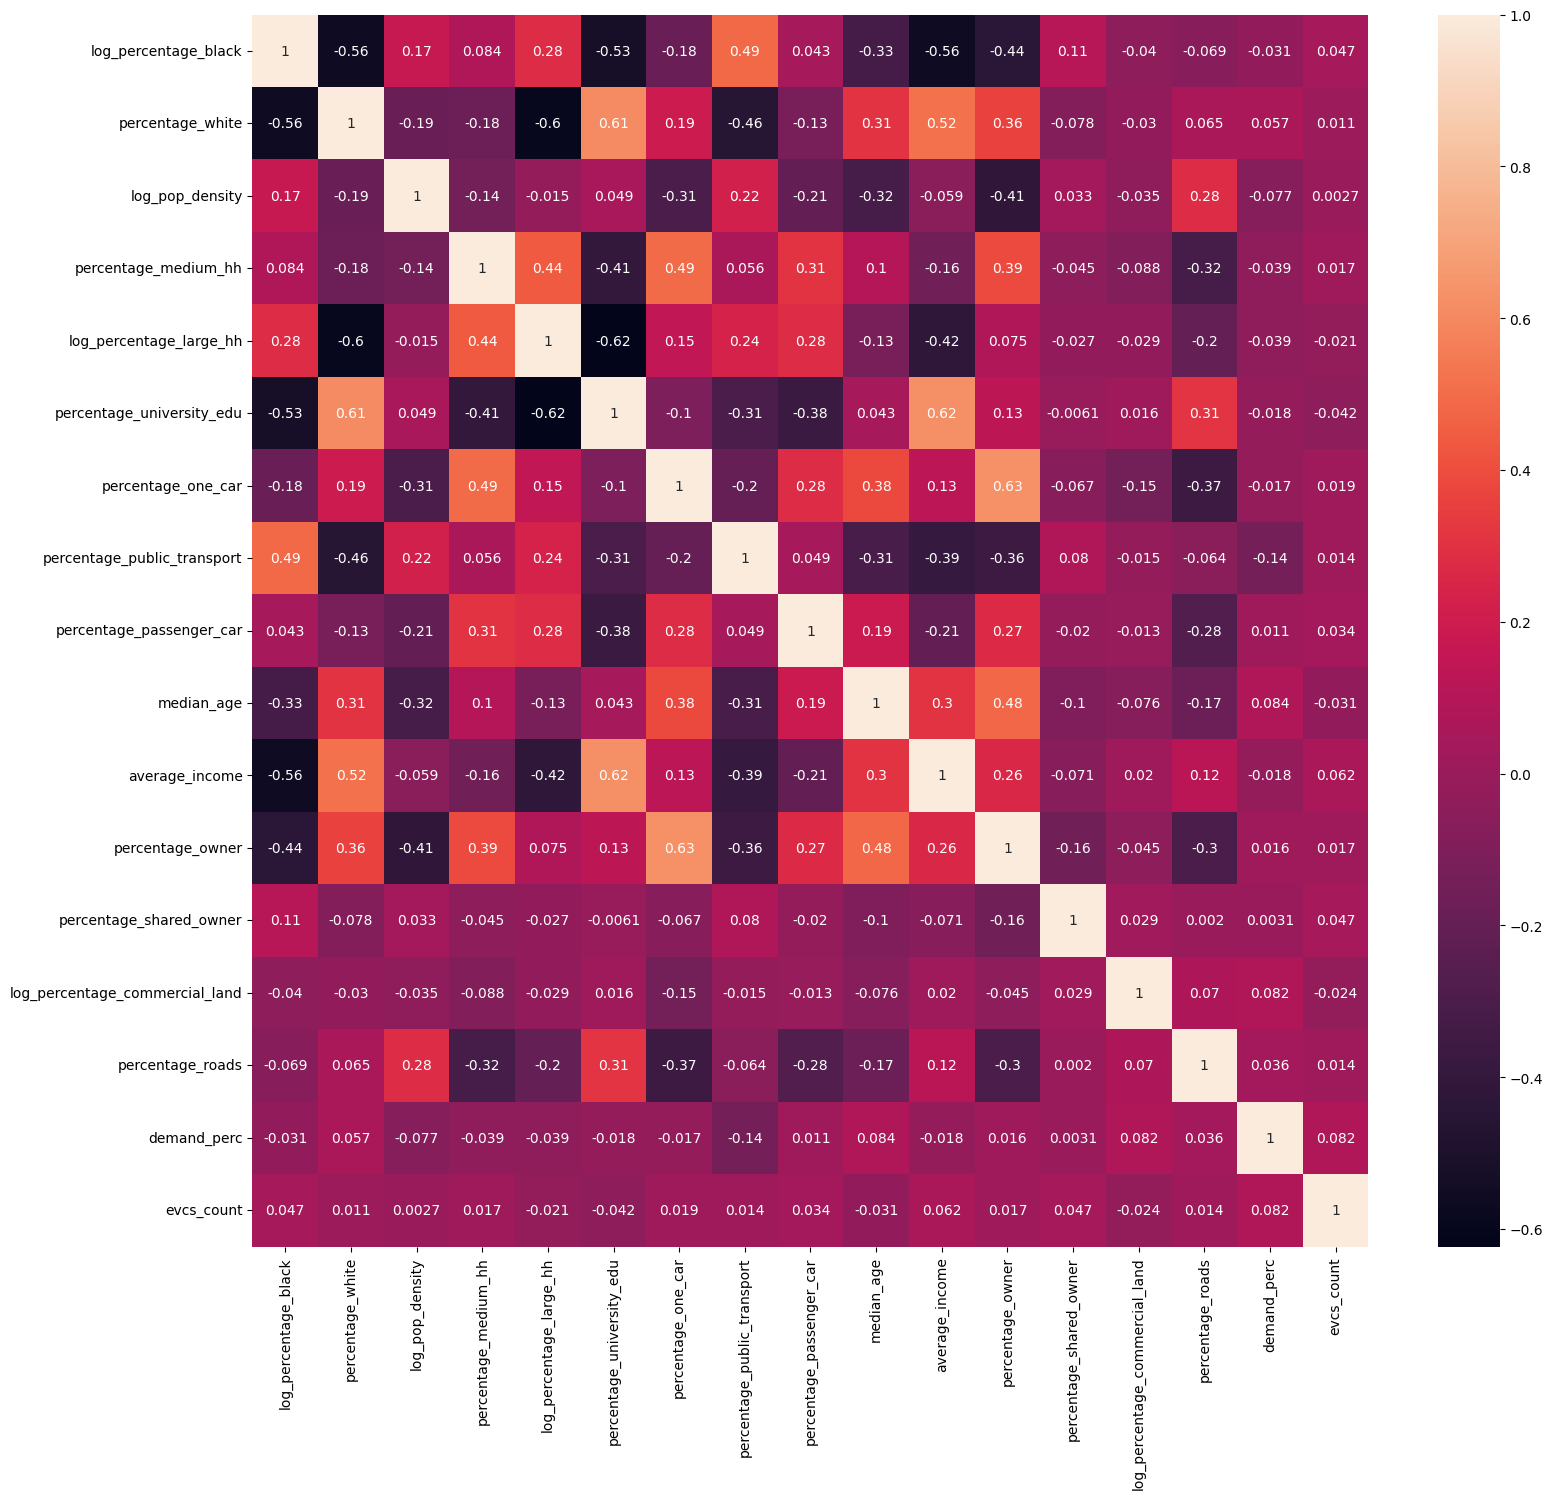

In [ ]:
# MULTICOLLINEARITY CHECK
# removed no edu, deprived, not deprived, school, small hh, renter, no cars, drive car, house, shared flat, 2+cars
evcs_subset_3 = evcs_clean_data_merged_gdf[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_one_car','percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc','evcs_count']]

# evcs corr matrix
corr_matrix = evcs_subset_3.corr()

# Set the figure size
plt.figure(figsize=(18, 16))

sns.heatmap(corr_matrix, annot=True)
plt.show()

### Network Demand Headroom 2 Correlation Matrix

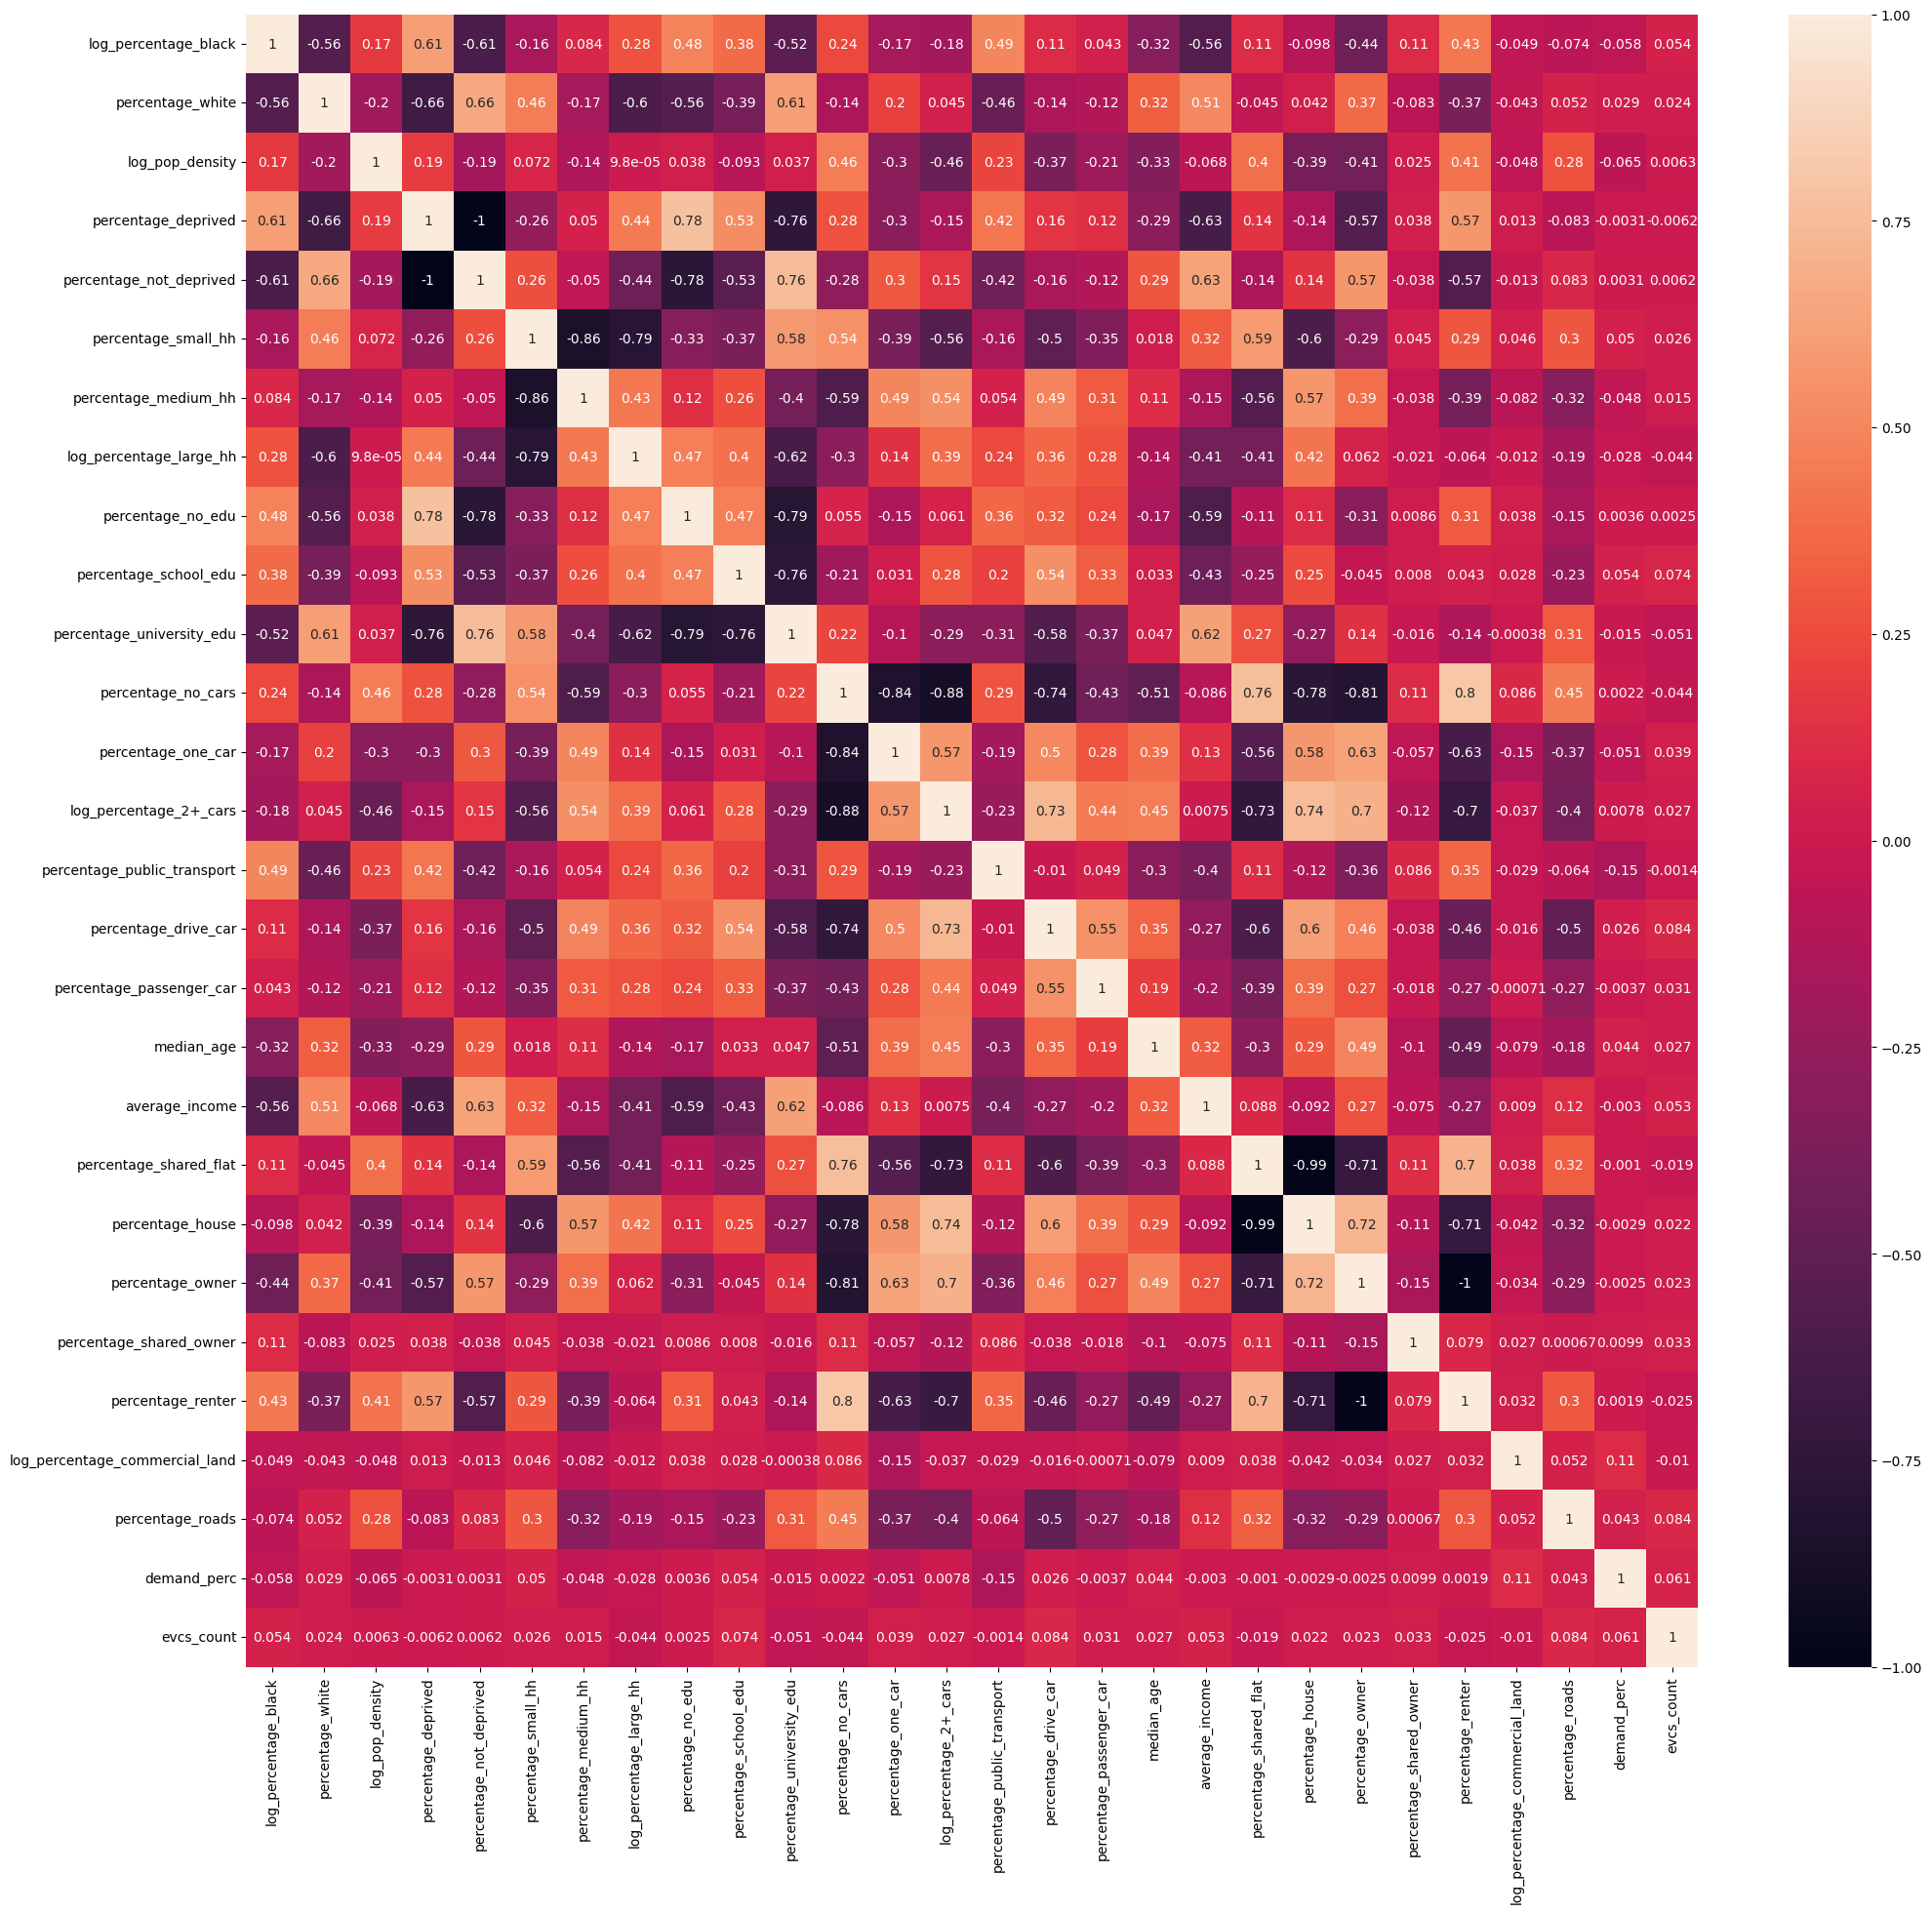

In [ ]:
# only needed to create variables
demand_subset_2 = demand_clean_data_merged_gdf[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_deprived', 'percentage_not_deprived', 'percentage_small_hh',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_no_edu',
       'percentage_school_edu', 'percentage_university_edu',
       'percentage_no_cars', 'percentage_one_car','log_percentage_2+_cars',
       'percentage_public_transport', 'percentage_drive_car',
       'percentage_passenger_car', 'median_age', 'average_income',
       'percentage_shared_flat', 'percentage_house', 'percentage_owner',
       'percentage_shared_owner', 'percentage_renter',
       'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc','evcs_count']]

# evcs corr matrix
corr_matrix = demand_subset_2.corr()

# Set the figure size
plt.figure(figsize=(24, 22))

sns.heatmap(corr_matrix, annot=True)
plt.show()

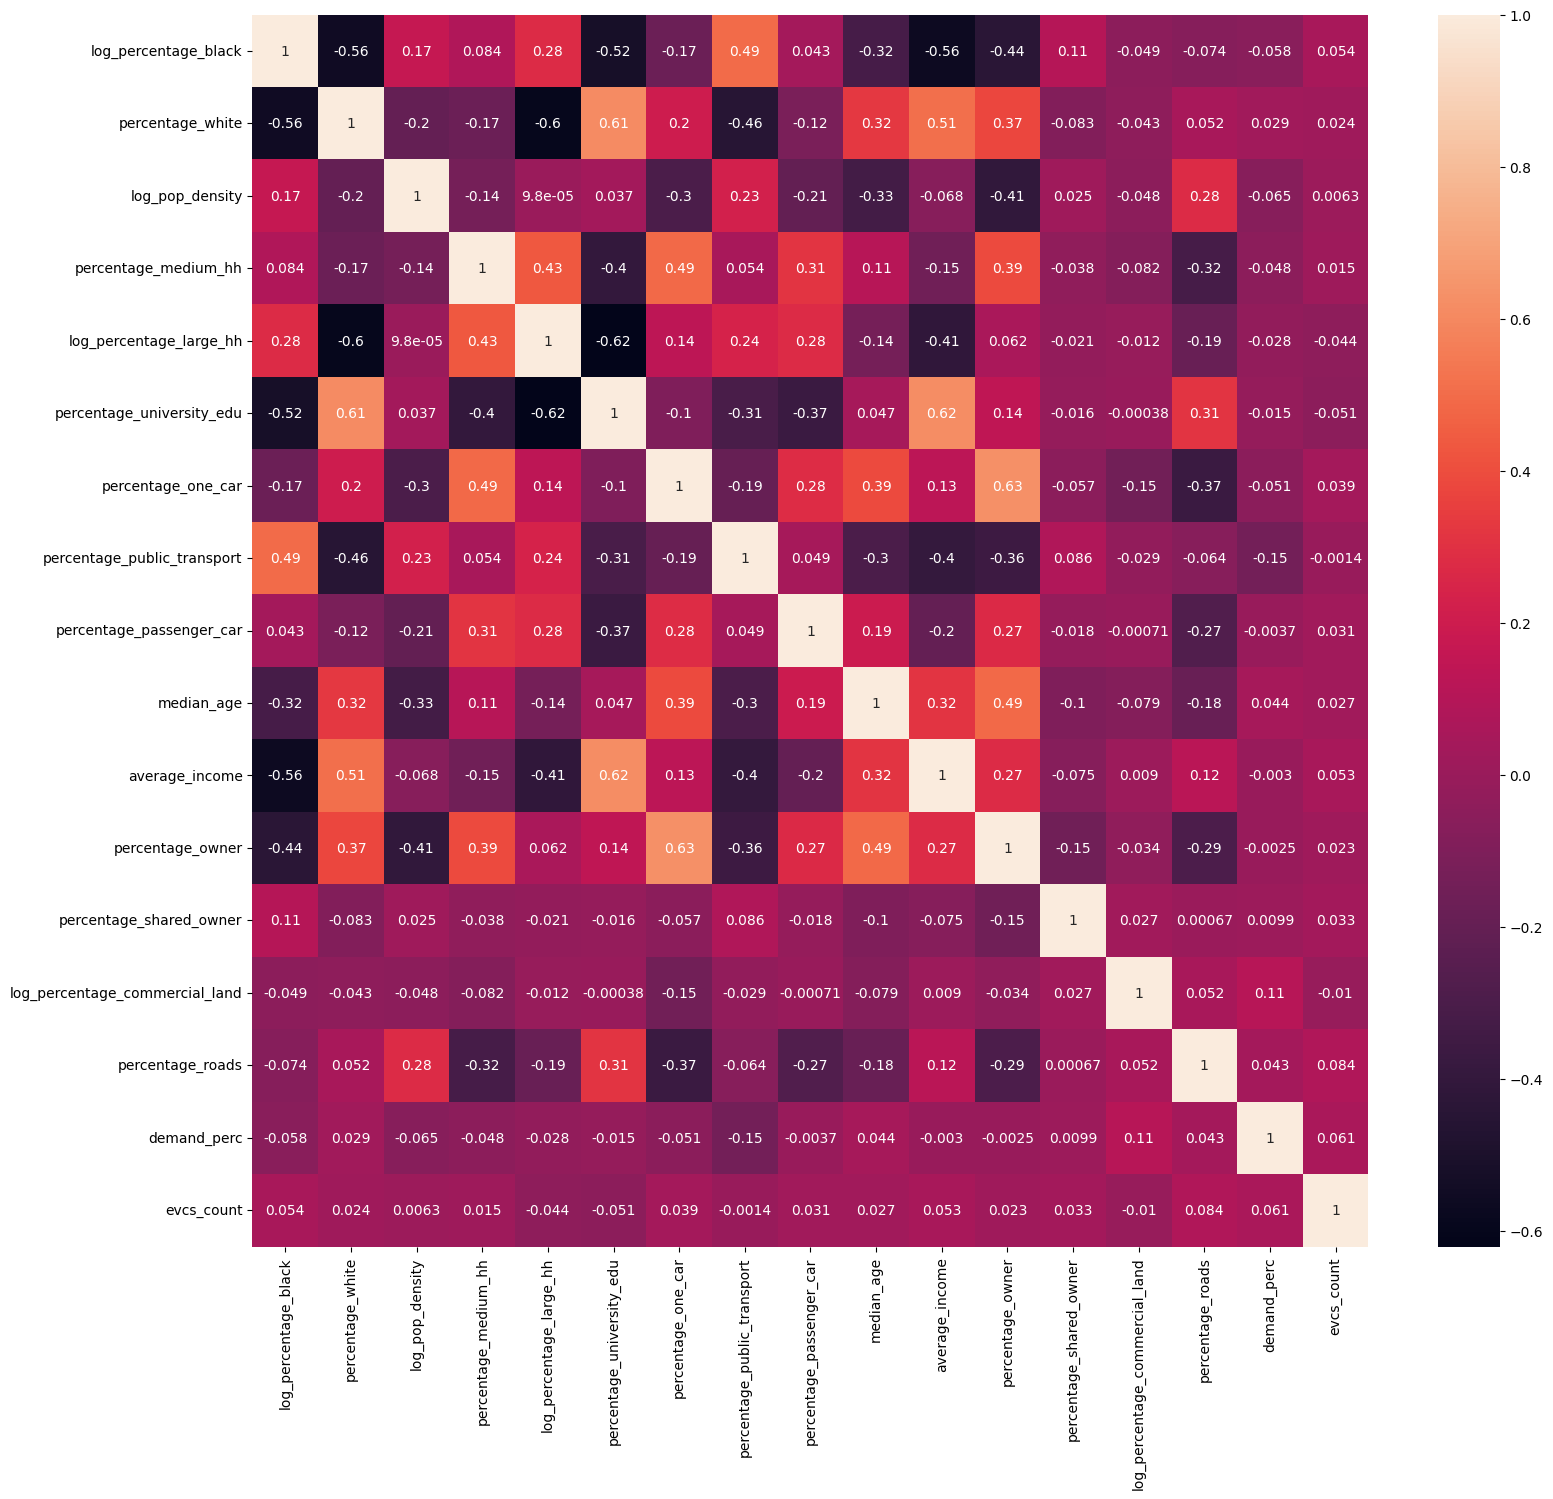

In [ ]:
# only needed to create variables
# MULTICOLLINEARITY CHECK
# removed no edu, deprived, not deprived, school, small hh, renter, no cars, drive car, house, shared flat, 2+cars
demand_subset_3 = demand_clean_data_merged_gdf[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_one_car','percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc','evcs_count']]

# evcs corr matrix
corr_matrix = demand_subset_3.corr()

# Set the figure size
plt.figure(figsize=(18, 16))

sns.heatmap(corr_matrix, annot=True)
plt.show()

## OLS 2
2nd OLS regression aftrer dropping variables 1 - based on trying to reduce multicollinearity from correlation matrix



### EVCS

In [ ]:
ols2e = evcs_subset_3.dropna()

X = ols2e[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_one_car','percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']]

y = ols2e['evcs_count']

In [ ]:
X = sm.add_constant(X)
model_ols2e = sm.OLS(y, X).fit()
ols_summary = model_ols2e.summary()
ols_summary
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols2e_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             evcs_count   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     35.16
Date:                Thu, 24 Aug 2023   Prob (F-statistic):          1.48e-106
Time:                        12:34:47   Log-Likelihood:                -14501.
No. Observations:               10997   AIC:                         2.904e+04
Df Residuals:                   10980   BIC:                         2.916e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.9201      0.241     20.389      0.000       4.447       5.393
log_percentage_black               0.0976      0.014      7.075      0.000       0.071       0.125
percentage_white                   0.0021      0.001      2.798      0.005       0.001       0.004
log_pop_density                    0.0140      0.015      0.913      0.361      -0.016       0.044
percentage_medium_hh              -0.0024      0.001     -1.759      0.079      -0.005       0.000
log_percentage_large_hh           -0.1065      0.018     -5.925      0.000      -0.142      -0.071
percentage_university_edu         -0.0146      0.001    -12.615      0.000      -0.017      -0.012
percentage_one_car                -0.0011      0.001     -0.923      0.356      -0.004       0.001
percentage_public_transport        0.0076      0.002      3.423      0.001       0.003       0.012
percentage_passenger_car           0.0615      0.018      3.424      0.001       0.026       0.097
median_age                        -0.0394      0.004    -10.332      0.000      -0.047      -0.032
average_income                  2.517e-05   1.55e-06     16.254      0.000    2.21e-05    2.82e-05
percentage_owner                   0.0058      0.001      8.156      0.000       0.004       0.007
percentage_shared_owner            0.0328      0.006      5.862      0.000       0.022       0.044
log_percentage_commercial_land    -0.0469      0.011     -4.280      0.000      -0.068      -0.025
percentage_roads                   0.0097      0.002      5.305      0.000       0.006       0.013
demand_perc                        0.0058      0.001      9.775      0.000       0.005       0.007
==============================================================================
Omnibus:                      922.060   Durbin-Watson:                   0.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1212.517
Skew:                           0.727   Prob(JB):                    5.07e-264
Kurtosis:                       3.731   Cond. No.                     1.48e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Network Demand Headroom

In [ ]:
ols2d = demand_subset_3.dropna()

X = ols2d[['log_percentage_black', 'percentage_white','log_pop_density',
       'percentage_medium_hh', 'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_one_car','percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']]

y = ols2d['demand_perc']

In [ ]:
X = sm.add_constant(X)
model_ols2d = sm.OLS(y, X).fit()
ols_summary = model_ols2d.summary()
ols_summary
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols2d_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            demand_perc   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     37.87
Date:                Thu, 24 Aug 2023   Prob (F-statistic):          3.12e-115
Time:                        12:34:48   Log-Likelihood:                -45393.
No. Observations:               10877   AIC:                         9.082e+04
Df Residuals:                   10860   BIC:                         9.094e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             52.4406      4.263     12.302      0.000      44.085      60.797
log_percentage_black              -0.9209      0.240     -3.845      0.000      -1.390      -0.451
percentage_white                  -0.0041      0.013     -0.306      0.760      -0.030       0.022
log_pop_density                   -1.2286      0.268     -4.587      0.000      -1.754      -0.704
percentage_medium_hh              -0.0332      0.023     -1.419      0.156      -0.079       0.013
log_percentage_large_hh           -0.3671      0.314     -1.168      0.243      -0.983       0.249
percentage_university_edu         -0.0943      0.020     -4.610      0.000      -0.134      -0.054
percentage_one_car                -0.1077      0.021     -5.036      0.000      -0.150      -0.066
percentage_public_transport       -0.5462      0.039    -14.162      0.000      -0.622      -0.471
percentage_passenger_car          -0.3392      0.314     -1.081      0.280      -0.955       0.276
median_age                         0.2290      0.067      3.436      0.001       0.098       0.360
average_income                    -0.0001   2.73e-05     -4.687      0.000      -0.000   -7.45e-05
percentage_owner                  -0.0217      0.012     -1.754      0.079      -0.046       0.003
percentage_shared_owner            0.1531      0.099      1.543      0.123      -0.041       0.348
log_percentage_commercial_land     1.7638      0.192      9.206      0.000       1.388       2.139
percentage_roads                   0.0811      0.033      2.492      0.013       0.017       0.145
evcs_count                         1.2372      0.188      6.574      0.000       0.868       1.606
==============================================================================
Omnibus:                      454.316   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.146
Skew:                           0.278   Prob(JB):                    2.41e-213
Kurtosis:                       4.361   Cond. No.                     1.49e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## OLS 3
3rd OLS regression aftrer ddropping insignificant variables from OLS2
Based on remove variables with low p values

EVCS -

Variables dropped:
* pop density
* medium hh,
* one car,

Demand -

Variables dropped:
* white,
* medium hh,
* large hh,
* passenger,
* owner
* shared owner,



### EVCS

In [ ]:
# removed pop density, medium hh, one car
ols3e = evcs_subset_3.dropna()

X = ols3e[['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']]

y = ols3e['evcs_count']

In [ ]:
X = sm.add_constant(X)
model_ols3e = sm.OLS(y, X).fit()
ols_summary = model_ols3e.summary()

# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols3e_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

### Network Demand Headroom

In [ ]:
# removed white, medium hh, large hh, passenger, shared owner, roads

ols3d = demand_subset_3.dropna()

X = ols3d[['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']]

y = ols3d['demand_perc']

In [ ]:
X = sm.add_constant(X)
model_ols3d = sm.OLS(y, X).fit()
ols_summary = model_ols3d.summary()

# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols3d_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

## OLS 4 - FINAL MODELS
4rd OLS regression aftrer dropping multicollinear variables from OLS3
Based on VIF below

EVCS -

Variables dropped:
* median age
* average income
* uni edu
* roads
* large hh
* black
* white

Demand -

Variables dropped:
* ln pop density
* median age
* average income
* evcs count
* roads
* public trans
* one car



### EVCS

In [ ]:
# removed median age, average income, uni edu, roads, large hh, black, white
ols4e = evcs_subset_3.dropna()

X = ols4e[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = ols4e['evcs_count']

In [ ]:
X = sm.add_constant(X)
model_ols4e = sm.OLS(y, X).fit()
ols_summary = model_ols4e.summary()
print(ols_summary)
robust_results = model_ols4e.get_robustcov_results(cov_type='HC3')  # HC3 is a popular robust estimator

# Print the summary with robust standard errors
print(robust_results.summary())
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols4e_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())

# no multicollinearity

                            OLS Regression Results                            
Dep. Variable:             evcs_count   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     20.17
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.37e-23
Time:                        12:34:55   Log-Likelihood:                -14710.
No. Observations:               10997   AIC:                         2.943e+04
Df Residuals:                   10990   BIC:                         2.949e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Network Demand Headroom

In [ ]:
# removed ln pop density, median age, average income, evcs count, roads, public trans, one car

ols4d = demand_subset_3.dropna()

X = ols4d[['log_percentage_black','percentage_university_edu',
       'log_percentage_commercial_land']]

y = ols4d['demand_perc']

In [ ]:
X = sm.add_constant(X)
model_ols4d = sm.OLS(y, X).fit()
ols_summary = model_ols4d.summary()
print(ols_summary)
robust_results = model_ols4d.get_robustcov_results(cov_type='HC3')  # HC3 is a popular robust estimator

# Print the summary with robust standard errors
print(robust_results.summary())
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/ols4d_summary.csv', 'w') as f:
    f.write(ols_summary.as_csv())
# no multicollinearity

                            OLS Regression Results                            
Dep. Variable:            demand_perc   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     53.12
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.44e-34
Time:                        12:34:59   Log-Likelihood:                -45594.
No. Observations:               10877   AIC:                         9.120e+04
Df Residuals:                   10873   BIC:                         9.123e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Poisson Regression

### EVCS

In [ ]:
X = evcs_clean_data_merged_gdf[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']
exog = sm.add_constant(X)
poisson_training_results = sm.GLM(y, exog, family=sm.families.Poisson()).fit()
pois_summary = poisson_training_results.summary()
print(pois_summary)
# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/poisson_4e_summary.csv', 'w') as f:
    f.write(pois_summary.as_csv())
# looks worse based on log likelihood

                 Generalized Linear Model Regression Results                  
Dep. Variable:             evcs_count   No. Observations:                10997
Model:                            GLM   Df Residuals:                    10990
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20109.
Date:                Sun, 20 Aug 2023   Deviance:                       1754.3
Time:                        10:09:07   Pearson chi2:                 1.81e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001971
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Negative Binomial Regression
Not suitable as mean is > variance

### EVCS

In [ ]:
np.mean(evcs_clean_data_merged_gdf[['evcs_count']])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


evcs_count    5.165591
dtype: float64

In [ ]:
np.var(evcs_clean_data_merged_gdf[['evcs_count']])

evcs_count    0.860185
dtype: float64

In [ ]:
X = evcs_clean_data_merged_gdf[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']
exog = sm.add_constant(X)

# Assuming 'y' is the count data (dependent variable) and 'X' is the independent variable matrix
model = sm.GLM(y, exog, family=sm.families.NegativeBinomial())
result = model.fit()
results_sum = result.summary()
print(results_sum)

# Convert the summary to a string and save it to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/negbin_4e_summary.csv', 'w') as f:
    f.write(results_sum.as_csv())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             evcs_count   No. Observations:                10997
Model:                            GLM   Df Residuals:                    10990
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30054.
Date:                Sun, 20 Aug 2023   Deviance:                       280.33
Time:                        10:09:28   Pearson chi2:                     292.
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003210
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## Multinomial Logisitic Regression - NOT APPROPRIATE
On model 4 (5 in paper)

### EVCS

In [ ]:
X = evcs_clean_data_merged_gdf[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']

# define the multinomial logistic regression model with a default penalty
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2',
                           C=1.0, max_iter = 1000000)
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.497 (0.001)


In [ ]:
X = evcs_clean_data_merged_gdf[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']

# Fit a multinomial logistic regression model
multinomial_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
multinomial_model.fit(X, y)

# Predict probabilities and classes
predicted_probabilities = multinomial_model.predict_proba(X)
predicted_classes = multinomial_model.predict(X)

# Print results
print("Predicted Probabilities:\n", predicted_probabilities)
print("Predicted Classes:\n", predicted_classes)

Predicted Probabilities:
 [[4.44305007e-04 2.44698261e-01 4.98648226e-01 1.80870748e-01
  5.18252178e-02 2.35132428e-02]
 [1.77849753e-04 2.42117025e-01 5.01192956e-01 1.80265800e-01
  5.02534426e-02 2.59929261e-02]
 [1.03536857e-04 2.53283418e-01 5.18166828e-01 1.70110995e-01
  3.21588941e-02 2.61763282e-02]
 ...
 [2.72354656e-03 2.19722155e-01 4.88911210e-01 2.05459396e-01
  6.20289666e-02 2.11547261e-02]
 [6.61969868e-04 2.18646326e-01 4.26947295e-01 2.31874334e-01
  9.08739990e-02 3.09960758e-02]
 [1.61760531e-03 2.24055175e-01 4.92528997e-01 2.04772475e-01
  5.58888525e-02 2.11368957e-02]]
Predicted Classes:
 [5 5 5 ... 5 5 5]


## Assumption testing

### Linearity (tested above)

### Normal Errors

#### EVCS

In [ ]:
# Look at Jarque Bera from ols models
#evcs_counts
#Jarque-Bera (JB):	3956.623
#	Prob(JB):	0.00
# residuals are not normal

In [ ]:
#Running plot & giving it a title
stats.probplot(model_ols3e.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

#### Network Demand Headroom

In [ ]:
# Jarque Bera
#Jarque-Bera (JB):	3154.479
# Prob(JB):	0.00
# residuals are not normal

In [ ]:
#Running plot & giving it a title
stats.probplot(model_ols3d.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

### Independence

#### EVCS

In [ ]:
statsmodels.stats.stattools.durbin_watson(model_ols3e.resid)

#### Network Demand Headroom

In [ ]:
statsmodels.stats.stattools.durbin_watson(model_ols3d.resid)

### Homoskedasticity

#### EVCS

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_ols4e.resid, model_ols4e.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 105.9601467978233),
 ('p-value', 1.427685133645914e-20),
 ('f-value', 17.82049019200077),
 ('f p-value', 1.1410794059992727e-20)]

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(robust_results.resid, robust_results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 323.99138974958),
 ('p-value', 6.378296721355726e-70),
 ('f-value', 111.27185023253077),
 ('f p-value', 5.778148021694246e-71)]

#### Network Demand Headroom

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_ols4d.resid, model_ols4d.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 323.99138974958),
 ('p-value', 6.378296721355726e-70),
 ('f-value', 111.27185023253077),
 ('f p-value', 5.778148021694246e-71)]

In [ ]:
# homoskedasicity in both model 3 as both p values significant

### No multicollinearity

#### EVCS

In [ ]:
# For each X, calculate VIF and save in dataframe
# for model 3
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ols3e[['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']].values, i) for i in range(ols3e[['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']].shape[1])]
vif["features"] = ols3e[['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']].columns
vif.round(1)

vif.to_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/VIF_model3_evcs.csv')

VIF Factor                        features
0         13.3            log_percentage_black
1         22.5                percentage_white
2         15.8         log_percentage_large_hh
3         26.0       percentage_university_edu
4         11.2     percentage_public_transport
5          2.8        percentage_passenger_car
6        122.0                      median_age
7         81.7                  average_income
8          9.5                percentage_owner
9          1.3         percentage_shared_owner
10         2.9  log_percentage_commercial_land
11        19.6                percentage_roads
12         5.8                     demand_perc

In [ ]:
# start dropping from highest VIF score and retest multicollinearity
# drop median age
# drop average income
# drop uni edu
# drop roads
# drop large hh
# black
# white

In [ ]:
# MULTICOLLINEARITY CHECKS FOR FINAL MODEL 4 AFTER REMOVAL
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ols4e[[
       'percentage_public_transport','percentage_passenger_car',
       'percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']].values, i) for i in range(ols4e[[
       'percentage_public_transport','percentage_passenger_car',
       'percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']].shape[1])]
vif["features"] = ols4e[[
       'percentage_public_transport','percentage_passenger_car',
       'percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']].columns
vif.round(1)

vif.to_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/VIF_model4_evcs.csv')
# model 4 here is model 5 in paper

VIF Factor                        features
0         4.2     percentage_public_transport
1         2.3        percentage_passenger_car
2         3.8                percentage_owner
3         1.3         percentage_shared_owner
4         2.7  log_percentage_commercial_land
5         4.4                     demand_perc

#### Network Demand Headroom

In [ ]:
# For each X, calculate VIF and save in dataframe
# for model 3
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ols3d[['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']].values, i) for i in range(ols3d[['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']].shape[1])]
vif["features"] = ols3d[['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']].columns
vif.round(1)

vif.to_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/VIF_model3_demand.csv')

VIF Factor                        features
0        13.8            log_percentage_black
1       139.4                 log_pop_density
2        18.4       percentage_university_edu
3        21.5              percentage_one_car
4        11.1     percentage_public_transport
5       125.6                      median_age
6        88.5                  average_income
7         2.9  log_percentage_commercial_land
8        21.8                percentage_roads
9        39.5                      evcs_count

In [ ]:
# drop
# ln pop density
# median age
# average income
# evcs count
# roads
# public trans
# one car

In [ ]:
# MULTICOLLINEARITY CHECKS FOR FINAL MODEL 4 AFTER REMOVAL
# For each X, calculate VIF and save in dataframe

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ols4d[['log_percentage_black',
       'percentage_university_edu',
       'log_percentage_commercial_land']].values, i) for i in range(ols4d[['log_percentage_black',
       'percentage_university_edu',
       'log_percentage_commercial_land']].shape[1])]
vif["features"] = ols4d[['log_percentage_black',
       'percentage_university_edu',
       'log_percentage_commercial_land']].columns
vif.round(1)

vif.to_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/VIF_model4_demand.csv')
# model 4 here is model 5 in paper

VIF Factor                        features
0         3.4            log_percentage_black
1         3.6       percentage_university_edu
2         2.7  log_percentage_commercial_land

## Spatial Autocorrelation

### EVCS

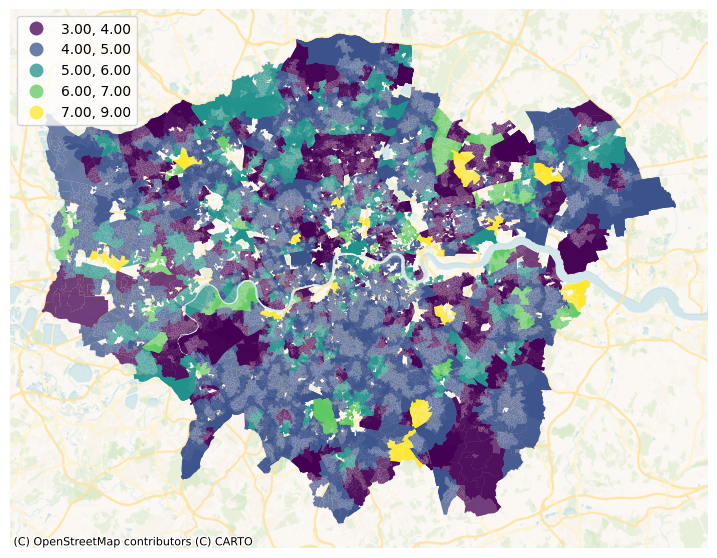

In [ ]:
# map evcs

# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
final_merged_gdf.plot(
    column="evcs_count",
    cmap="viridis",
    scheme="natural_breaks",
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=final_merged_gdf.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off()

plt.savefig('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/evcs_choropleth_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# global moran's I
# Assuming you have a variable called 'your_variable' that you want to calculate Moran's I for
variable = evcs_clean_data_merged_gdf['evcs_count'].values

# Calculate global Moran's I
moran_global = Moran(variable, libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf))
print("Global Moran's I:", moran_global.I)
print("Global Moran's I p-value:", moran_global.p_sim)

In [ ]:
# new morans model 4 (5 in paper)
w = libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf)

# Calculate Moran's I for the residuals
moran_residuals = esda.moran.Moran(model_ols4e.resid, w)

print("Moran's I:", moran_residuals.I)
print("p-value:", moran_residuals.p_sim)

In [ ]:
# for model 1dte (2 in paper)

# new morans model 4 (5 in paper)
w = libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf)

# Calculate Moran's I for the residuals
moran_residuals = esda.moran.Moran(model_ols1dte.resid, w)

print("Moran's I:", moran_residuals.I)
print("p-value:", moran_residuals.p_sim)

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 214 disconnected components.
 There are 42 islands with ids: 423, 556, 1455, 2047, 2441, 2515, 2663, 2681, 2684, 2796, 3387, 3700, 3735, 4134, 4696, 4746, 4842, 5952, 5954, 6247, 6466, 6505, 6664, 6863, 7220, 7224, 7296, 7553, 7561, 7632, 7901, 8555, 8966, 9223, 9231, 9437, 9718, 9826, 10433, 10521, 1

('WARNING: ', 423, ' is an island (no neighbors)')
('WARNING: ', 556, ' is an island (no neighbors)')
('WARNING: ', 1455, ' is an island (no neighbors)')
('WARNING: ', 2047, ' is an island (no neighbors)')
('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2515, ' is an island (no neighbors)')
('WARNING: ', 2663, ' is an island (no neighbors)')
('WARNING: ', 2681, ' is an island (no neighbors)')
('WARNING: ', 2684, ' is an island (no neighbors)')
('WARNING: ', 2796, ' is an island (no neighbors)')
('WARNING: ', 3387, ' is an island (no neighbors)')
('WARNING: ', 3700, ' is an island (no neighbors)')
('WARNING: ', 3735, ' is an island (no neighbors)')
('WARNING: ', 4134, ' is an island (no neighbors)')
('WARNING: ', 4696, ' is an island (no neighbors)')
('WARNING: ', 4746, ' is an island (no neighbors)')
('WARNING: ', 4842, ' is an island (no neighbors)')
('WARNING: ', 5952, ' is an island (no neighbors)')
('WARNING: ', 5954, ' is an island (no neighbors)')
('WARNING: ', 

In [ ]:
# local moran's I

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf))
print("Local Moran's I:", moran_local.Is)
print("Local Moran's I p-values:", moran_local.p_sim)

In [ ]:
# Assuming you have a variable called 'your_variable' that you want to calculate LISA for
variable = evcs_clean_data_merged_gdf['evcs_count'].values

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf))

# Create a LISA cluster map
plot = lisa_cluster(moran_local, evcs_clean_data_merged_gdf)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 7 islands with ids: 7798, 8490, 8510, 15807, 17880, 18393, 21209.
  warnings.warn(message)


('WARNING: ', 7798, ' is an island (no neighbors)')
('WARNING: ', 8490, ' is an island (no neighbors)')
('WARNING: ', 8510, ' is an island (no neighbors)')
('WARNING: ', 15807, ' is an island (no neighbors)')
('WARNING: ', 17880, ' is an island (no neighbors)')
('WARNING: ', 18393, ' is an island (no neighbors)')
('WARNING: ', 21209, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


ModuleNotFoundError: ignored

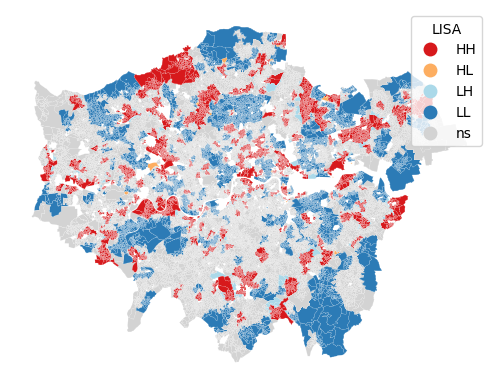

In [ ]:
# from final gdf

# Assuming you have a variable called 'your_variable' that you want to calculate LISA for
variable = final_merged_gdf['evcs_count'].values

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(final_merged_gdf))

# Create a LISA cluster map
lisa_cluster(moran_local, final_merged_gdf, legend_kwds={'title': 'LISA'})

plt.savefig('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/evcs_morans_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Network Demand Headroom

In [ ]:
# map demand headroom

# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
final_merged_gdf.plot(
    column="demand_perc",
    cmap="viridis",
    scheme="natural_breaks",
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=final_merged_gdf.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off()

plt.savefig('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/demand_choropleth_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# QA CHECKS
#final_merged_gdf['demand_perc'][final_merged_gdf['OA11CD']=='E00176932']
final_merged_gdf[final_merged_gdf['OA11CD']=='E00176932']

In [ ]:
# global moran's I
# Assuming you have a variable called 'your_variable' that you want to calculate Moran's I for
# drop na so moran's i value not na

variable = demand_clean_data_merged_gdf['demand_perc'].values

# Calculate global Moran's I
moran_global = Moran(variable, libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf))
print("Global Moran's I:", moran_global.I)
print("Global Moran's I p-value:", moran_global.p_sim)

In [ ]:
# new morans model 4 (5 in paper)
w = libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf)

# Calculate Moran's I for the residuals
moran_residuals = esda.moran.Moran(model_ols4d.resid, w)

print("Moran's I:", moran_residuals.I)
print("p-value:", moran_residuals.p_sim)

In [ ]:
# dtd
# new morans model 4 (5 in paper)
w = libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf)

# Calculate Moran's I for the residuals
moran_residuals = esda.moran.Moran(model_ols1dtd.resid, w)

print("Moran's I:", moran_residuals.I)
print("p-value:", moran_residuals.p_sim)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 213 disconnected components.
 There are 39 islands with ids: 423, 525, 1387, 1979, 2377, 2451, 2599, 2617, 2620, 2733, 3283, 3599, 3634, 4033, 4593, 4643, 5816, 5818, 6111, 6303, 6523, 6722, 7079, 7083, 7155, 7412, 7413, 7500, 7769, 8439, 8816, 9287, 9309, 9593, 9701, 10309, 10397, 10558, 10673.
  warnings.warn(message)


('WARNING: ', 423, ' is an island (no neighbors)')
('WARNING: ', 525, ' is an island (no neighbors)')
('WARNING: ', 1387, ' is an island (no neighbors)')
('WARNING: ', 1979, ' is an island (no neighbors)')
('WARNING: ', 2377, ' is an island (no neighbors)')
('WARNING: ', 2451, ' is an island (no neighbors)')
('WARNING: ', 2599, ' is an island (no neighbors)')
('WARNING: ', 2617, ' is an island (no neighbors)')
('WARNING: ', 2620, ' is an island (no neighbors)')
('WARNING: ', 2733, ' is an island (no neighbors)')
('WARNING: ', 3283, ' is an island (no neighbors)')
('WARNING: ', 3599, ' is an island (no neighbors)')
('WARNING: ', 3634, ' is an island (no neighbors)')
('WARNING: ', 4033, ' is an island (no neighbors)')
('WARNING: ', 4593, ' is an island (no neighbors)')
('WARNING: ', 4643, ' is an island (no neighbors)')
('WARNING: ', 5816, ' is an island (no neighbors)')
('WARNING: ', 5818, ' is an island (no neighbors)')
('WARNING: ', 6111, ' is an island (no neighbors)')
('WARNING: ', 

In [ ]:
# local moran's I

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf))
print("Local Moran's I:", moran_local.Is)
print("Local Moran's I p-values:", moran_local.p_sim)

In [ ]:
# Assuming you have a variable called 'your_variable' that you want to calculate LISA for
variable = demand_clean_data_merged_gdf['demand_perc'].values

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf))

# Create a LISA cluster map
lisa_cluster(moran_local, demand_clean_data_merged_gdf)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 7530, 8222, 8242, 15260, 17189, 17288, 17801, 20425.
  warnings.warn(message)


('WARNING: ', 7530, ' is an island (no neighbors)')
('WARNING: ', 8222, ' is an island (no neighbors)')
('WARNING: ', 8242, ' is an island (no neighbors)')
('WARNING: ', 15260, ' is an island (no neighbors)')
('WARNING: ', 17189, ' is an island (no neighbors)')
('WARNING: ', 17288, ' is an island (no neighbors)')
('WARNING: ', 17801, ' is an island (no neighbors)')
('WARNING: ', 20425, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


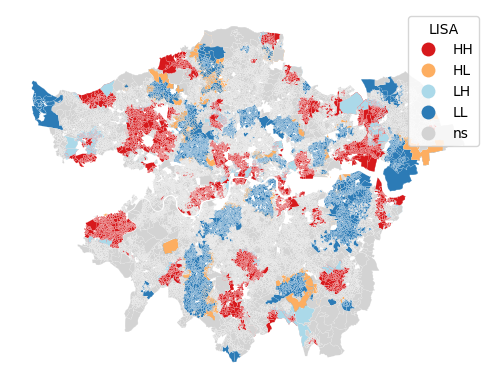

In [ ]:
# from final gdf
f = final_merged_gdf.dropna(subset = 'demand_perc')
# Assuming you have a variable called 'your_variable' that you want to calculate LISA for
variable = f['demand_perc'].values

# Calculate local Moran's I
moran_local = Moran_Local(variable, libpysal.weights.Queen.from_dataframe(f))

# Create a LISA cluster map
lisa_cluster(moran_local, f, legend_kwds={'title': 'LISA'})

plt.savefig('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/demand_morans_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Spatial Error and Lag Models - Regression - OLS 3
Uses variables from final OLS model 3

### EVCS

In [ ]:
# ensure nas dropped
X = evcs_clean_data_merged_gdf[['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']

w = libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf)
w.transform='r'

In [ ]:
x_names = ['log_percentage_black', 'percentage_white',
       'log_percentage_large_hh', 'percentage_university_edu',
       'percentage_public_transport','percentage_passenger_car',
       'median_age', 'average_income','percentage_owner',
       'percentage_shared_owner', 'log_percentage_commercial_land', 'percentage_roads',
       'demand_perc']

y_name = 'evcs_count'
name_ds = 'evcs_clean_data_merged_gdf'
name_w = 'evcs_weights'

In [ ]:
# SPATIAL ERROR
# GeoDataFrame called 'gdf'
# DataFrame called 'y' with the dependent variable and 'X' with independent variables

# Create a spatial error model (SEM) instance
sem_model = spreg.GM_Error(y.values.reshape(-1, 1), X.values, w, name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w)

# Get the results summary
summary_text = sem_model.summary
print(summary_text)
# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_e_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_e_summary.csv', 'w') as f:
    f.write(summary_text)

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = sem_model.predy.flatten()
residuals = sem_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

In [ ]:
# SPATIAL LAG
slm_model = spreg.GM_Lag(y.values[:, None], X.values, \
                  w=w, spat_diag=True,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w)
summary_text = slm_model.summary
print(summary_text)

# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_e_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_e_summary.csv', 'w') as f:
    f.write(summary_text)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :demand_clean_data_merged_gdf
Weights matrix      :demand_weights
Dependent Variable  : demand_perc                Number of Observations:       10877
Mean dependent var  :     32.3821                Number of Variables   :           5
S.D. dependent var  :     16.1439                Degrees of Freedom    :       10872
Pseudo R-squared    :      0.4330
Spatial Pseudo R-squared:  0.0170

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      27.8533326       4.0864698       6.8159889       0.0000000
     log_pop_density      -1.1399757       0.2322549      -4.9082964       0.0000009
percentage_university_edu      -0.0523685

In [ ]:
# Extract the rho value from the model summary
rho_value = slm_model.rho

print("Rho (ρ) value:", rho_value)

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = slm_model.predy.flatten()
residuals = slm_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

### Network Demand Headroom

In [ ]:
X = demand_clean_data_merged_gdf[['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']]

y = demand_clean_data_merged_gdf['demand_perc']

w = libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf)
w.transform='r'

('WARNING: ', 423, ' is an island (no neighbors)')
('WARNING: ', 525, ' is an island (no neighbors)')
('WARNING: ', 1387, ' is an island (no neighbors)')
('WARNING: ', 1979, ' is an island (no neighbors)')
('WARNING: ', 2377, ' is an island (no neighbors)')
('WARNING: ', 2451, ' is an island (no neighbors)')
('WARNING: ', 2599, ' is an island (no neighbors)')
('WARNING: ', 2617, ' is an island (no neighbors)')
('WARNING: ', 2620, ' is an island (no neighbors)')
('WARNING: ', 2733, ' is an island (no neighbors)')
('WARNING: ', 3283, ' is an island (no neighbors)')
('WARNING: ', 3599, ' is an island (no neighbors)')
('WARNING: ', 3634, ' is an island (no neighbors)')
('WARNING: ', 4033, ' is an island (no neighbors)')
('WARNING: ', 4593, ' is an island (no neighbors)')
('WARNING: ', 4643, ' is an island (no neighbors)')
('WARNING: ', 5816, ' is an island (no neighbors)')
('WARNING: ', 5818, ' is an island (no neighbors)')
('WARNING: ', 6111, ' is an island (no neighbors)')
('WARNING: ', 

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 213 disconnected components.
 There are 39 islands with ids: 423, 525, 1387, 1979, 2377, 2451, 2599, 2617, 2620, 2733, 3283, 3599, 3634, 4033, 4593, 4643, 5816, 5818, 6111, 6303, 6523, 6722, 7079, 7083, 7155, 7412, 7413, 7500, 7769, 8439, 8816, 9287, 9309, 9593, 9701, 10309, 10397, 10558, 10673.
  warnings.warn(message)


In [ ]:
# if cut out variables change here
x_names = ['log_percentage_black','log_pop_density',
       'percentage_university_edu',
       'percentage_one_car','percentage_public_transport',
       'median_age', 'average_income',
       'log_percentage_commercial_land', 'percentage_roads',
       'evcs_count']

y_name = 'demand_perc'
name_ds = 'demand_clean_data_merged_gdf'
name_w = 'demand_weights'

In [ ]:
# SPATIAL ERROR MODEL
# GeoDataFrame called 'gdf'
# DataFrame called 'y' with the dependent variable and 'X' with independent variables

# Create a spatial error model (SEM) instance
sem_model = spreg.GM_Error(y.values.reshape(-1, 1), X.values, w,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w, vm=True)

# Get the results summary
summary_text = sem_model.summary

# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_d_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_d_summary.csv', 'w') as f:
    f.write(summary_text)

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = sem_model.predy.flatten()
residuals = sem_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

In [ ]:
# SPATIAL LAG MODEL
slm_model = spreg.GM_Lag(y.values[:, None], X.values, \
                  w=w, spat_diag=True,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w, vm=True)
summary_text = slm_model.summary
print(summary_text)
# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_d_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_d_summary.csv', 'w') as f:
    f.write(summary_text)

In [ ]:
# Extract the rho value from the model summary
rho_value = slm_model.rho

print("Rho (ρ) value:", rho_value)

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = slm_model.predy.flatten()
residuals = slm_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

In [ ]:
# here  = report
# ols 1 = ols 1
# ols dt = ols 2
# ols 2 = ols 3
# ols 3 = ols 4

## Spatial Error and Lag Models - Regression - OLS4 - FINAL MODELS
Uses variables from final OLS model 4
OLS 5 in paper

### EVCS

In [ ]:
# ensure nas dropped
X = evcs_clean_data_merged_gdf[['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']]

y = evcs_clean_data_merged_gdf['evcs_count']

w = libpysal.weights.Queen.from_dataframe(evcs_clean_data_merged_gdf)
w.transform='r'

In [ ]:
x_names = ['percentage_public_transport','percentage_passenger_car',
       'percentage_owner','percentage_shared_owner', 'log_percentage_commercial_land',
       'demand_perc']

y_name = 'evcs_count'
name_ds = 'evcs_clean_data_merged_gdf'
name_w = 'evcs_weights'

In [ ]:
# SPATIAL ERROR
# GeoDataFrame called 'gdf'
# DataFrame called 'y' with the dependent variable and 'X' with independent variables

# Create a spatial error model (SEM) instance
sem_model = spreg.GM_Error(y.values.reshape(-1, 1), X.values, w, name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w)

# Get the results summary
summary_text = sem_model.summary
print(summary_text)
# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_e_ols4_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_e_ols4_summary.csv', 'w') as f:
    f.write(summary_text)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :evcs_clean_data_merged_gdf
Weights matrix      :evcs_weights
Dependent Variable  :  evcs_count                Number of Observations:       10997
Mean dependent var  :      5.1656                Number of Variables   :           7
S.D. dependent var  :      0.9275                Degrees of Freedom    :       10990
Pseudo R-squared    :      0.0022

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.2195319       0.0376078     138.7886645       0.0000000
percentage_public_transport      -0.0015427       0.0010224      -1.5088903       0.1313268
percentage_passenger_car      -0.0063023       0.0061979      -1.01683

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = sem_model.predy.flatten()
residuals = sem_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

Log-Likelihood: -14765.627914612174


In [ ]:
# SPATIAL LAG
slm_model = spreg.GM_Lag(y.values[:, None], X.values, \
                  w=w, spat_diag=True,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w)
summary_text = slm_model.summary
print(summary_text)

# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_e_ols4_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_e_ols4_summary.csv', 'w') as f:
    f.write(summary_text)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :evcs_clean_data_merged_gdf
Weights matrix      :evcs_weights
Dependent Variable  :  evcs_count                Number of Observations:       10997
Mean dependent var  :      5.1656                Number of Variables   :           8
S.D. dependent var  :      0.9275                Degrees of Freedom    :       10989
Pseudo R-squared    :      0.7435
Spatial Pseudo R-squared:  0.0070

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.4970327       0.1543353      22.6586636       0.0000000
percentage_public_transport       0.0036778       0.0015403       2.3877535       0.0169517
percentage_passenger_car       0.02771

In [ ]:
# Extract the rho value from the model summary
rho_value = slm_model.rho

print("Rho (ρ) value:", rho_value)

Rho (ρ) value: [0.2831333]


In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = slm_model.predy.flatten()
residuals = slm_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

Log-Likelihood: -11703.190855606916


### Network Demand Headroom

In [ ]:
X = demand_clean_data_merged_gdf[['log_percentage_black','percentage_university_edu',
       'log_percentage_commercial_land']]

y = demand_clean_data_merged_gdf['demand_perc']

w = libpysal.weights.Queen.from_dataframe(demand_clean_data_merged_gdf)
w.transform='r'

In [ ]:
x_names = ['log_percentage_black','percentage_university_edu',
       'log_percentage_commercial_land']

y_name = 'demand_perc'
name_ds = 'demand_clean_data_merged_gdf'
name_w = 'demand_weights'

In [ ]:
# SPATIAL ERROR MODEL
# GeoDataFrame called 'gdf'
# DataFrame called 'y' with the dependent variable and 'X' with independent variables

# Create a spatial error model (SEM) instance
sem_model = spreg.GM_Error(y.values.reshape(-1, 1), X.values, w,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w, vm=True)

# Get the results summary
summary_text = sem_model.summary

# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_d_ols4_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/sem_d_ols4_summary.csv', 'w') as f:
    f.write(summary_text)

In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = sem_model.predy.flatten()
residuals = sem_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

Log-Likelihood: -45620.268772136704


In [ ]:
# SPATIAL LAG MODEL
slm_model = spreg.GM_Lag(y.values[:, None], X.values, \
                  w=w, spat_diag=True,name_x=x_names,
                           name_y=y_name, name_ds = name_ds, name_w=name_w, vm=True)
summary_text = slm_model.summary
print(summary_text)
# Save the summary to a text file (optional)
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_d_ols4_summary.txt', 'w') as f:
    f.write(summary_text)

# Save the summary text to a CSV file
with open('/content/drive/MyDrive/GDS-Yr2/Dissertation/Tables_and_Figures/slm_d_ols4_summary.csv', 'w') as f:
    f.write(summary_text)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :demand_clean_data_merged_gdf
Weights matrix      :demand_weights
Dependent Variable  : demand_perc                Number of Observations:       10877
Mean dependent var  :     32.3821                Number of Variables   :           5
S.D. dependent var  :     16.1439                Degrees of Freedom    :       10872
Pseudo R-squared    :      0.4330
Spatial Pseudo R-squared:  0.0170

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      27.8533326       4.0864698       6.8159889       0.0000000
log_percentage_black      -1.1399757       0.2322549      -4.9082964       0.0000009
percentage_university_edu      -0.0523685

In [ ]:
# Extract the rho value from the model summary
rho_value = slm_model.rho

print("Rho (ρ) value:", rho_value)

Rho (ρ) value: [0.23313084]


In [ ]:
# log likelihood
# Get the fitted values and residuals from the model
fitted_values = slm_model.predy.flatten()
residuals = slm_model.u.flatten()

# Calculate the log-likelihood manually
n = len(y)  # Number of observations
sigma2 = np.mean(residuals ** 2)  # Estimated variance of residuals

log_likelihood = -0.5 * (n * np.log(2 * np.pi * sigma2) + np.sum(residuals ** 2) / sigma2)
print("Log-Likelihood:", log_likelihood)

Log-Likelihood: -44149.07643198575
